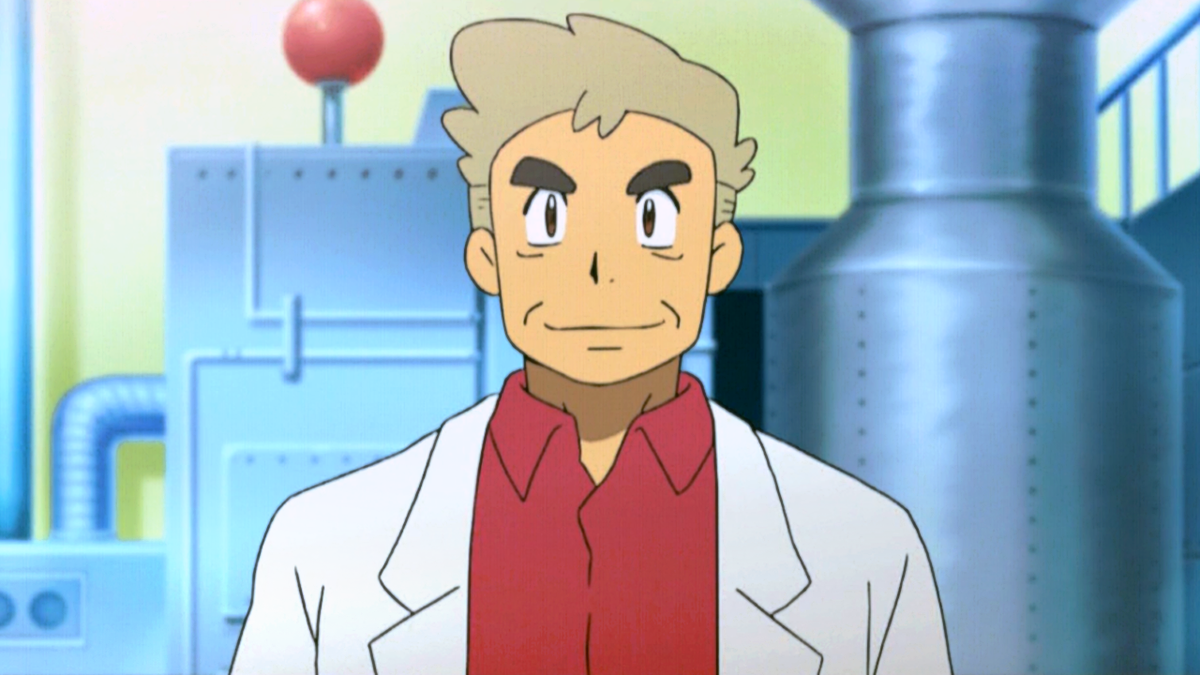

## Jupyter notebook TMT tutorial

#### <font color='red'>Warning</font> this is a pilot (I'm still very new to this) - I'm submitting this work looking for criticism/suggestions/corrections: 

### Rationale: Continue the pipeline started by Robert Mills. He chose this platform while performing microbiome research, particularly because you can create an environment that is fully compatible with QIIME software (Knight lab), and I believe it is also useful for other independent machine learning platforms... You can also create an R environment and run R to create Jupyter notebook tutorials, which is something that I (or if somebody else wants to do it?) plan to use to help convert our lab codes into educational materials next...

#### <font color='blue'>One goal is to share with eachother/create a pipeline for every incoming student. </font>
#### <font color='blue'> Another goal is to create a bootcamp to train the next generation of scientists </font>



### Before beginning, you need to have miniconda installed on your computer. 

### You can find installation instructions for miniconda here: https://docs.conda.io/en/latest/miniconda.html

Next, you will need to access the terminal (command on a PC and terminal on a mac) and create a conda environment. You can create an environment with the name "myfirstenv" by typing the following code in your terminal:

In [1]:
conda create -n myfirstenv

Solving environment: done

## Package Plan ##

  environment location: /Users/jonathanokerblom/miniconda3/envs/myfirstenv



Proceed ([y]/n)? 
Note: you may need to restart the kernel to use updated packages.


Now that the environment is created, you can access it by typing the following command:

In [2]:
conda activate myfirstenv


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


Use the codes below to create your first graph in jupyter notebook... Note that anything that starts with "#" is a comment, which is not part of the initiated code.

Now that you have activated your new environment, you will need to install some packages into it. For this tutorial, you will need to install matplotlib, pandas, seaborn, openpyxl, and jupyter notebook. Install each component by entering the following commands (one at a time):


In [3]:
conda install matplotlib #This will install matplotlib in your environment

conda install pandas #This will install pandas in your environment

conda install openpyxl #This will install openpyxl in your environment

conda install jupyter notebook #This will install jupyter lab notebook in your environment

conda install seaborn #This will install seaborn in your environment

SyntaxError: invalid syntax (<ipython-input-3-dffdb2e8b8b9>, line 1)

By this point hopefully you can continue installing all of the packages you will need below... Some of them may need to be install via PIP instead of conda... Continue this type of installation in your environment until you have installed all of the packages. Once complete, you can run jupyter notebook by entering the following command in the terminal:

In [ ]:
Jupyter notebook

## Now that you are in Jupyter notebook, you can import the packages you installed in your environment (myenv)

Info on packages used during this tutorial:

Math - https://docs.python.org/3/library/math.html

Pandas - https://pandas.pydata.org/

Numpy - https://numpy.org/

Seaborn - https://seaborn.pydata.org/

Matplotlib - https://matplotlib.org/

Bioinforkit - https://pypi.org/project/bioinfokit/0.3/

Sklearn - https://scikit-learn.org/stable/

Miceforest - https://pypi.org/project/miceforest/

#### All of the code below (including defining the functions) needs to be implemented (either by hitting the Run button above, or hitting <font color = "green"> shift + enter</font>)

In [8]:
#Import packages
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import linregress
from bioinfokit import analys, visuz
from bioinfokit.analys import stat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import miceforest as mf

In [9]:
#Set figure resolution to 300dpi
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [10]:
#Optional for disabling warnings 
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## User defined functions (created by Robert) applied during Data Normalization:
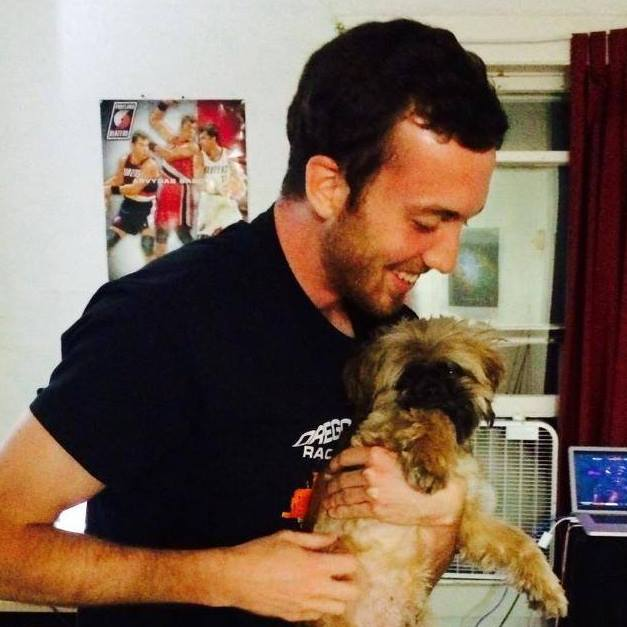

## Filtration (written by Robert):

In [11]:
def PSM_quality_filters(df, labels_df):
    """
    This function takes the raw PSM output file from proteome discoverer and applies several
    quality control filtering; 1) A redundancy filter which removes redundant PSMs that should
    not be included in the protein quantitation, 2) An average signal to noise filter removing
    PSMs with an average signal to noise ratio <10, 3) A spectral interference filter removing
    PSMs with more than 25% interference, 4) Removal of rejected and low confidence PSMs.
    
    As part of the average signal to noise filter, we add a pseudocount of 1 to channels
    missing any quantitation.
    
    parameters
    ----------
    df: pd.DataFrame
    labels_df: pd.DataFrame
    
    returns
    -------
    input dataframe with low quality PSMs removed
    
    """
    channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
    
    #Remove low confidence PSMs, report number removed
    df2 = df[df['Confidence'] == 'High']
    removed = (len(df) - len(df2))
    print("Number of low confidence PSMs removed: %s" % removed)
    
    #Remove Rejected PSMs, report number removed
    df3 = df2[df2['PSM Ambiguity'] != 'Rejected']
    removed = (len(df2) - len(df3))
    print("Number of ambiguous 'rejected' PSMs removed: %s" % removed)
    
    #Remove the PSMs with high interference
    df4 = df3[df3['Isolation Interference [%]'] < 25]
    removed = (len(df3) - len(df4))
    print("Number of PSMs with high interference removed: %s" % removed)
    
    #Remove duplicate & redundant PSMs
    #here we collect the index of each PSM that should not be included
    Keep_list = list(df4[(df4["Peptide Quan Usage"] != "DoNotUse") & (df4["Quan Info"] != "Redundant")].index)
    
    
    #Subset out the keep list PSMs
    df5 = df4.loc[df4.index.isin(Keep_list)]
    removed = (len(df4) - len(df5))
    print("Number of redundant PSMs removed: %s" % removed)
    
    #Remove PSMs with low avg signal
    
    #Replace NaN with 1
    df5 = df5.replace(np.nan, 1)
    #Replace 0 with 1
    df5 = df5.replace(0, 1)
    
    #Detect the na valued channels so we don't count them in the average
    
    #Find and save the channels to use per experiment in a dictionary
    global dataframe_collection
    dataframe_collection = {}
    Experiments = list(labels_df['Experiment'])
    Experiment_labels={}
    Low_avg_removed = 0
    
    for i in Experiments:
        NA_Channels = []
        exp_channels = ['126', '127N', '127C', '128N', '128C', '129N', '129C', '130N','130C','131']
        for j in channels:
            if pd.isnull(labels_df.loc[i][j]) == True:
                NA_Channels.append(j)
        for j in NA_Channels:
            exp_channels.remove(j)
            
        df_sep = df5[df5['Experiment'] == i]
        df_sep[exp_channels] = df_sep[exp_channels].astype('float64')
        df_sep['Avg_Sig2Noise'] = df_sep[exp_channels].mean(axis=1)
        df_sep2 = df_sep[df_sep['Avg_Sig2Noise'] > 10]
        
       
        Low_avg_removed = (len(df_sep) - len(df_sep2)) + Low_avg_removed
        #Save to collection
        dataframe_collection["%s" % i] = df_sep2
        #dataframe_collection["%s_LowSignalFiltered" % i] = df_sep3
        #dataframe_collection["%s_RejectPSMs" % i] = PSM_Reject
    
    removed = (len(df5) - Low_avg_removed)
    print("Number of PSMs with low average signal removed: %s" % Low_avg_removed)
    
    #Report the percent of PSMs removed in quality control
    removed_percent = (len(df) - removed)/len(df)
    print("Percent of PSMs removed during quality filtering: %s" % removed_percent)
    
    return print("Dataframes per experiment with low quality PSMs removed saved under name: dataframe_collection")

## Summation (written by Robert)

In [12]:
def Sum_PSMs_per_Experiment(df_collection, labels_df, experiment_column, bridge_channel):
    """
    This function takes a dictionary of  dataframes containing PSMs seperated per experiment,
    a column name which contains the name of the experiment each PSMs was found in, 
    and a string listing the channel name which was used as a bridge channel. 
    The function outputs the dataframes containing summed signal to noise ratios per protein 
    for each experiment. Each dataframe is placed in a new collection of dataframes.
    
    parameters
    ----------
    df_collection: pd.DataFrame
    labels_df: pd.DataFrame
    experiment_column: string
    bridge_channel: string
    
    returns
    -------
    A collection of dataframes
    
    """
    channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
    
    
    
    Experiment_list = list(labels_df['Experiment'])
    
    #Create dataframes per experiment & sum PSMs per protein
    global dataframe_collection2
    global current_df
    dataframe_collection2 = {}
    bridge_vals = []
    for i in Experiment_list:
        #Subset df
        current_df = df_collection[i]
        #Remove columns without a master protein
        current_df = current_df[current_df['Master Protein Accessions'] != 'nan']
        
        # Take the first Master Protein Accession from the protein groups as the representative
        # Protein. Place this protein name in a new column named "Master Protein"
        current_df['Master Protein Accessions'] = current_df['Master Protein Accessions'].astype('str')
        current_df['Master Protein'] = current_df['Master Protein Accessions'].apply(lambda x: x.split(';')[0])
        
        #Change index
        current_df.index = current_df['Master Protein']
        NA_Channels = []
        for j in channels:
            if pd.isnull(labels_df.loc[i][j]) == True:
                NA_Channels.append(j)
        exp_channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
        for j in NA_Channels:
            exp_channels.remove(j)        
        #subset out only the used channels
        current_df = current_df[exp_channels].astype('float64')
        #Sum by protein
        current_df = current_df[exp_channels].astype('float64').groupby([current_df.index]).agg(['sum'])
        #Add bridge channel values to one list
        bridge_vals = list(current_df[bridge_channel]['sum']) + bridge_vals
        #Print the number of proteins quantified in each experiment
        print("Number of proteins quantified in Experiment %s: %s" % (i, len(current_df)))
        #Save to collection
        dataframe_collection2["%s" % i] = current_df
    global bridge_median
    bridge_median = np.median(bridge_vals)
    
    return print('Collection of dataframes per experiments saved under name: dataframe_collection2; Median of bridge channel saved under name: bridge_median')

## Normalization (written by Robert)

In [13]:
def One_Bridge_Normalization(df_collection,label_df,bridge_channel,bridge_median):
    """
    This function performs two normalization steps analagous to what was developed for 
    normalization of RNA seq data. The first step of normalization largely accounts 
    for differences in the number of peptides used to quantify each protein which would 
    drive all associations when comparing protein quant values between experiments where 
    a different number of PSMs was identified within the same protein. The second step helps
    remove some of the systematic errors that occur between samples
    
    The function takes a collection dataframes with summed protein quant values in separate 
    dataframes dependent on the experiment.
    
    Side note - don't have any sample names that are named 126 or 131 as they interfere with channel names.
    
    parameters
    ----------
    df_collection: pd.dict
    label_df: pd.DataFrame
    bridge_channel: string
    bridge_median: float
    
    returns
    -------
    A new dataframe with normalized values per protein.
    
    """
    channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
    
    #First Normalization step
    #Value/(protein val in bridge/Median of all bridge)
    
    global dataframe_collection3
    global current_df2
    global labels
    global Exp_labels
    global all_samples
    
    dataframe_collection3 = {}
    Experiment_list = list(label_df.index)
    for i in Experiment_list:
        #Subset out label metadata for current experiment
        Exp_labels = label_df[label_df.index == '%s' % i]
        
        #Make a list of channels containing samples in the current experiment
        NA_Channels = []
        for j in channels:
            if pd.isnull(label_df.loc[i][j]) == True:
                NA_Channels.append(j)
        exp_channels = ['126', '127N', '127C', '128N',
       '128C', '129N', '129C', '130N', '130C', '131']
        for j in NA_Channels:
            exp_channels.remove(j)        
        exp_channels.remove(bridge_channel)
        
        #Subset df
        current_df2 = df_collection['%s' % i]
        #Perform normalization into a new column labeled by actual sample name
        #Create a list of the names of samples in this experiment, to subset out only the channels containing names
        Experiment_samples = []
        for j in exp_channels:
            name = Exp_labels.loc['%s' % i][j]
            Experiment_samples.append(name)
            current_df2['%s' % name] = current_df2['%s' % j]/(current_df2[bridge_channel]/bridge_median)
        #Subset out the columns with names of samples
        current_df2 = current_df2[Experiment_samples]
        #Save to collection of dfs with columns containing sample names
        dataframe_collection3["%s" % i] = current_df2
    
    #Make another list of dataframes to merge with first experiment
    Exp1 = Experiment_list[0]
    Experiment_list_remove1 = Experiment_list
    Experiment_list_remove1.remove(Exp1)
    
    #Merge all dataframes by protein accession
    #Start with first experiment in separate df
    global combined_df
    combined_df = dataframe_collection3['%s' % Exp1]
    for i in Experiment_list_remove1:
        current_df3 = dataframe_collection3['%s' % i]
        combined_df = combined_df.merge(current_df3, left_index = True, right_index = True, how = 'outer')
    
    #Remove "Sums" fromt the multi index
    combined_df.columns = combined_df.columns.droplevel(1)
    
    #Create list of all samples
    all_samples = list(combined_df.columns)
    
    #Second Normalization step
    #Value/(Median Value in Sample/Median of all values)
    global Overall_Median
    Overall_Median = np.nanmedian(combined_df)
    for i in all_samples:
            combined_df['%s_adj2' % i] = combined_df[i]/(combined_df[i].median()/Overall_Median)
    #Remove "_adj2" characters
    global Normalized_df
    combined_df2 = combined_df.drop(columns=all_samples)
    combined_df2 = combined_df2.rename(columns = lambda x : str(x)[:-5])
    Normalized_df = combined_df2
    
    return print("Dataframe with normalized protein quants saved under name: Normalized_df")

### Once you are into Jupyter notebook, you will create a new dataframe. You can name this dataframe whatever you want. We will call our first dataframe <font color = "green"> df</font> (short for dataframe).

### Load PSMs and label layout to perform functions (filter, sum, normalize) on:


#### Please note: It's important to append the spectrum files with the experiment or 10plex name. For example, if DG142207 and DG142208 are in the first 10plex and DG142217 and DG142218 are in the second 10plex, you would label them DG142207_10plex1, DG142208_10plex1, DG142207_10plex2, DG142208_10plex2 etc... 

#### All 12 fractions for each 10plex should be appended with the appropriate name after the underscore. The name after the underscore should also match the name of the "Experiment" column in the "Labels" csv file (as shown below).  

In [14]:
#LOAD DATA
df = pd.read_csv('./HeadPlasma_PSMs3.txt',sep='\t') #This is the txt file output from PD imported as dataframe "df"

#visualize dataframe
df

Checked Confidence Identifying Node PSM Ambiguity  \
0        False       High  Sequest HT (A2)   Unambiguous   
1        False       High  Sequest HT (A2)   Unambiguous   
2        False       High  Sequest HT (A2)   Unambiguous   
3        False       High  Sequest HT (A2)   Unambiguous   
4        False       High  Sequest HT (A2)   Unambiguous   
...        ...        ...              ...           ...   
56281    False       High  Sequest HT (A2)   Unambiguous   
56282    False       High  Sequest HT (A2)   Unambiguous   
56283    False       High  Sequest HT (A2)   Unambiguous   
56284    False       High  Sequest HT (A2)   Unambiguous   
56285    False       High  Sequest HT (A2)   Unambiguous   

                            Annotated Sequence  \
0                     nSITLTNLNPGTEYVVSIIAVNGR   
1                                    vLDGYLFSk   
2      tPFITNPGYDTENGIQLPGTTHQQPSVGQQMIFEEHGFR   
3              aTLTVDkPSSTAYMQLSSLTSEDSAVYYcAR   
4                       dQSPASHEIATNLGDFAISLYR   
...                                        ...   
56281                        vGQPGAAGPVSPmcPGR   
56282                               lLEAcTFHkH   
56283                            gTGFLSIEPLDPR   
56284                            hGTDDGVVWmNWk   
56285                       aETFTFHSDIcTLPEkEk   

                                           Modifications  # Protein Groups  \
0                                       N-Term(TMT6plex)                 1   
1                         N-Term(TMT6plex); K9(TMT6plex)                 1   
2                                       N-Term(TMT6plex)                 1   
3      N-Term(TMT6plex); K7(TMT6plex); C29(Carbamidom...                 1   
4                                       N-Term(TMT6plex)                 4   
...                                                  ...               ...   
56281  N-Term(TMT6plex); M13(Oxidation); C14(Carbamid...                 1   
56282  N-Term(TMT6plex); C5(Carbamidomethyl); K9(TMT6...                 1   
56283                                   N-Term(TMT6plex)                 1   
56284    N-Term(TMT6plex); M10(Oxidation); K13(TMT6plex)                 1   
56285  N-Term(TMT6plex); C11(Carbamidomethyl); K16(TM...                 1   

       # Proteins                                 Protein  \
0               7                              A0A087WSN6   
1               2                              A0A571BF69   
2               5                              A0A087WSN6   
3               2                                  P01754   
4               7  P22599; Q00898; A0A0R4J0X5; A0A0A0MQA3   
...           ...                                     ...   
56281           4                                  P29699   
56282           1                                  Q921I1   
56283           1                                  P01029   
56284           1                                  Q8K0E8   
56285           1                                  P07724   

                    Master Protein Accessions  ...    126   127N   127C  \
0                                  A0A087WSN6  ...   14.9   25.5   46.5   
1                                  A0A571BF69  ...  122.2   90.1  145.7   
2                                  A0A087WSN6  ...   23.3   22.8   29.5   
3                                      P01754  ...   37.8   57.6   88.3   
4      P22599; Q00898; A0A0R4J0X5; A0A0A0MQA3  ...   30.8   47.9   26.2   
...                                       ...  ...    ...    ...    ...   
56281                                  P29699  ...    9.4   16.7   16.1   
56282                                  Q921I1  ...   49.1  104.8  168.1   
56283                                  P01029  ...   60.5  120.7   81.3   
56284                                  Q8K0E8  ...   34.8    NaN   59.8   
56285                                  P07724  ...   49.3   72.3   91.1   

        128N   128C   129N   129C   130N   130C    131  
0       29.4   24.4   20.6   25.3   31.6   30.4   23.3  


In [15]:
Labels = pd.read_csv('./LabelLayout.csv',dtype='str') #This is a label layout of the samples imported to dataframe "Labels"
Labels.index = Labels['Experiment'] #This sets the index column of the label layout to the "Experiment" column

In [16]:
#View 10plex Label scheme (dataframe Labels)
Labels

Experiment 126 127N 127C 128N 128C 129N 129C 130N 130C      131
Experiment                                                                
10plex1       10plex1  29   23   33   27   22   36   42   21   41  bridge1
10plex2       10plex2  39   35   37   20   18   32   28   45   26  bridge2
10plex3       10plex3  19   25   38   30   44   34   24   31   40  bridge3

In [17]:
#View dataframe df (data imported from Proteome Discoverer)
df.head(10)

Checked Confidence Identifying Node PSM Ambiguity  \
0    False       High  Sequest HT (A2)   Unambiguous   
1    False       High  Sequest HT (A2)   Unambiguous   
2    False       High  Sequest HT (A2)   Unambiguous   
3    False       High  Sequest HT (A2)   Unambiguous   
4    False       High  Sequest HT (A2)   Unambiguous   
5    False       High  Sequest HT (A2)   Unambiguous   
6    False       High  Sequest HT (A2)   Unambiguous   
7    False       High  Sequest HT (A2)   Unambiguous   
8    False       High  Sequest HT (A2)   Unambiguous   
9    False       High  Sequest HT (A2)   Unambiguous   

                        Annotated Sequence  \
0                 nSITLTNLNPGTEYVVSIIAVNGR   
1                                vLDGYLFSk   
2  tPFITNPGYDTENGIQLPGTTHQQPSVGQQMIFEEHGFR   
3          aTLTVDkPSSTAYMQLSSLTSEDSAVYYcAR   
4                   dQSPASHEIATNLGDFAISLYR   
5                          lSQTFPNADFAEITk   
6                      iFNSGADLSGITEENAPLk   
7                           lVAYYTLIGASGQR   
8                           lFVDPSQGLEVTGk   
9                      iFNSGADLSGITEENAPLk   

                                       Modifications  # Protein Groups  \
0                                   N-Term(TMT6plex)                 1   
1                     N-Term(TMT6plex); K9(TMT6plex)                 1   
2                                   N-Term(TMT6plex)                 1   
3  N-Term(TMT6plex); K7(TMT6plex); C29(Carbamidom...                 1   
4                                   N-Term(TMT6plex)                 4   
5                    N-Term(TMT6plex); K15(TMT6plex)                 1   
6                    N-Term(TMT6plex); K19(TMT6plex)                 1   
7                                   N-Term(TMT6plex)                 1   
8                    N-Term(TMT6plex); K14(TMT6plex)                 2   
9                    N-Term(TMT6plex); K19(TMT6plex)                 1   

   # Proteins                                 Protein  \
0           7                              A0A087WSN6   
1           2                              A0A571BF69   
2           5                              A0A087WSN6   
3           2                                  P01754   
4           7  P22599; Q00898; A0A0R4J0X5; A0A0A0MQA3   
5           1                                  P07724   
6           1                                  Q00898   
7           1                                  P01027   
8           3                          E9PVD2; A6X935   
9           1                                  Q00898   

                Master Protein Accessions  ...    126   127N   127C   128N  \
0                              A0A087WSN6  ...   14.9   25.5   46.5   29.4   
1                              A0A571BF69  ...  122.2   90.1  145.7   89.8   
2                              A0A087WSN6  ...   23.3   22.8   29.5   28.5   
3                                  P01754  ...   37.8   57.6   88.3  106.6   
4  P22599; Q00898; A0A0R4J0X5; A0A0A0MQA3  ...   30.8   47.9   26.2   26.7   
5                                  P07724  ...   71.7   68.4   95.0   61.3   
6                                  Q00898  ...   70.9  185.2   90.6   59.3   
7                                  P01027  ...   18.8   24.2   35.1   27.6   
8                          E9PVD2; A6X935  ...  190.7  409.7  228.2  201.9   
9                                  Q00898  ...   91.6  241.5  119.2   75.7   

    128C   129N   129C   130N   130C    131  
0   24.4   20.6   25.3   31.6   30.4   23.3  
1  130.1  131.9  141.2  103.5  116.3   96.3  
2   16.9   15.3   32.1   21.1   35.1   15.8  
3   30.9   27.5  240.5  111.4  192.5   54.7  
4   19.3   30.8   52.9   28.5   57.6   22.6  
5   95.4   77.0  100.2   69.8   96.3   53.2  
6   41.4   90.8  200.5   46.1  184.3   80.0  
7   21.4   13.3   24.3   31.6   30.9   15.1  
8  117.5  244.3  487.1  152.9  482.5  195.8  
9   57.6  140.7  270.9   65.6  308.9  123.0  

[10 rows x 46 columns]

In [18]:
#Removing characters from beginning and end of the spectrum files to make a columns consistent for each experiment
def remove_raw_f(x):
    return x[9:-4]

df['Experiment'] = df['Spectrum File'].apply(remove_raw_f)
df['Experiment']

0        10plex1
1        10plex1
2        10plex1
3        10plex1
4        10plex1
          ...   
56281    10plex3
56282    10plex3
56283    10plex3
56284    10plex3
56285    10plex3
Name: Experiment, Length: 56286, dtype: object

In [19]:
#Remove duplicate rows based on all columns
df['Experiment'].drop_duplicates()

0        10plex1
18677    10plex2
37636    10plex3
Name: Experiment, dtype: object

In [20]:
#Perform quality filtering function (shown above in user defined functions)
PSM_quality_filters(df, Labels)

Number of low confidence PSMs removed: 0
Number of ambiguous 'rejected' PSMs removed: 29
Number of PSMs with high interference removed: 10651
Number of redundant PSMs removed: 3168
Number of PSMs with low average signal removed: 2645
Percent of PSMs removed during quality filtering: 0.2930213552215471
Dataframes per experiment with low quality PSMs removed saved under name: dataframe_collection


In [21]:
#Sum the data using sum function *shown above in user defined functions)
Sum_PSMs_per_Experiment(df_collection=dataframe_collection, labels_df=Labels, experiment_column='Experiment',bridge_channel='131')

Number of proteins quantified in Experiment 10plex1: 676
Number of proteins quantified in Experiment 10plex2: 668
Number of proteins quantified in Experiment 10plex3: 664
Collection of dataframes per experiments saved under name: dataframe_collection2; Median of bridge channel saved under name: bridge_median


In [22]:
#If curious, you can check the bridge median:
bridge_median

155.2

In [23]:
#Apply the one bridge normalization function (shown above in user defined functions)
One_Bridge_Normalization(df_collection=dataframe_collection2,label_df=Labels,bridge_channel='131', bridge_median=bridge_median)

Dataframe with normalized protein quants saved under name: Normalized_df


In [24]:
#If curious, you can check Normalized_df
Normalized_df

29          23          33          27          22  \
Master Protein                                                               
A0A075B5K0      364.338575  112.903267  138.240201  124.442726   98.758266   
A0A075B5K2      314.600469  178.041912  231.303910  135.333896   82.257854   
A0A075B5K6      250.808397  109.799638  156.952938  109.195173  135.845034   
A0A075B5L1      134.925285   91.270391  319.192166  123.452601  120.367252   
A0A075B5L3      133.060455   65.451233  470.370640   57.168664   66.670667   
...                    ...         ...         ...         ...         ...   
Q9Z2K1           39.521323   37.291501   43.979228   42.667970   58.515460   
Q9Z2L6          155.716268  271.086037  215.214448  318.155723  248.637140   
Q9Z2U0          160.394209  139.080826  192.965840  165.341787  145.515410   
Q9Z2U1          171.357107  162.145436  183.637853  176.435919  202.094764   
Q9Z331          129.467575  139.153517  150.697255  154.232965  206.878537   

                        36          42          21          41          39  \
Master Protein                                                               
A0A075B5K0      255.299453  178.989838  165.674286  183.975238  106.755853   
A0A075B5K2      164.596444  184.328125  134.813408  175.445522  144.908942   
A0A075B5K6      194.076338  222.853993  148.077972  192.882902  167.345348   
A0A075B5L1      130.937027  187.671429  126.460023  220.775422   85.443715   
A0A075B5L3      178.754522   72.117660  228.406080  209.578596         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2K1           50.430442   28.146328  202.776510   35.878917  150.447283   
Q9Z2L6          136.640537  158.183398  147.438329  155.537306  175.746491   
Q9Z2U0          167.694086  163.655865  139.866469  185.696159    6.865450   
Q9Z2U1          163.303275  170.894231  182.236912  200.873111  208.815769   
Q9Z331          176.837155   96.298909  152.792781   98.248433         NaN   

                ...          26          19          25          38  \
Master Protein  ...                                                   
A0A075B5K0      ...  117.205388  149.455396  100.466405  174.591700   
A0A075B5K2      ...  108.579084  167.275585   69.319974  138.197279   
A0A075B5K6      ...  249.768354   89.670999  112.410310  186.851484   
A0A075B5L1      ...  127.445550   52.255501  168.980525   55.902964   
A0A075B5L3      ...         NaN         NaN         NaN         NaN   
...             ...         ...         ...         ...         ...   
Q9Z2K1          ...  140.919226  155.662106  154.255451  152.972834   
Q9Z2L6          ...  179.767682  141.424181  175.017280  151.010837   
Q9Z2U0          ...   97.345615  172.130514  180.361788  170.116475   
Q9Z2U1          ...  207.640724  108.888944  161.496914  174.902283   
Q9Z331          ...         NaN  169.650364  223.481676  171.157844   

                        30          44          34          24          31  \
Master Protein                                                               
A0A075B5K0      220.022180  147.155775  127.934449  122.270686  500.675708   
A0A075B5K2      129.281858  131.335315  170.392253   91.110384  197.801262   
A0A075B5K6      126.690255  143.479821  196.214906   90.643023  107.835970   
A0A075B5L1      395.870746  133.953459   96.172195  141.061164  122.252164   
A0A075B5L3             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          132.195046  162.562763  265.676715  197.816836  183.046955   
Q9Z2L6          173.758950  155.566052  149.546141  173.694392  136.422662   
Q9Z2U0          170.523353  140.511273  172.838089  177.535300  254.057414   
Q9Z2U1          185.248272  154.594436  173.978568  174.001283  149.722246   
Q9Z331          203.751133  140.348948  210.123956  176.971732  267.751889   

                        40  
Master Protein            

In [25]:
#Import protein names from head dataset for reference - we will use this later to add annotation to the Master Protein list
proteinlist = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Genenames.xlsx', index_col=0) 

#View dataframe
proteinlist.head()

Protein
Master Protein        
E9Q414            Apob
P01027              C3
P28665            Mug1
A0A087WSN6         Fn1
Q61838             Pzp

In [26]:
#Determine the number of missing values in each sample column
Normalized_df.isnull().sum()

29    185
23    185
33    185
27    185
22    185
36    185
42    185
21    185
41    185
39    193
35    193
37    193
20    193
18    193
32    193
28    193
45    193
26    193
19    197
25    197
38    197
30    197
44    197
34    197
24    197
31    197
40    197
dtype: int64

In [27]:
#Determine the % of total missing values in each column
copydf = Normalized_df
copydf.isnull().sum()/len(copydf)

29    0.214866
23    0.214866
33    0.214866
27    0.214866
22    0.214866
36    0.214866
42    0.214866
21    0.214866
41    0.214866
39    0.224158
35    0.224158
37    0.224158
20    0.224158
18    0.224158
32    0.224158
28    0.224158
45    0.224158
26    0.224158
19    0.228804
25    0.228804
38    0.228804
30    0.228804
44    0.228804
34    0.228804
24    0.228804
31    0.228804
40    0.228804
dtype: float64

## Visualizing the data without imputation (preferred method for some)

In [86]:
#Drop all missing values from Normalized_df and assign a new name (df1)
df1 = Normalized_df.dropna()
df1.isnull().sum().head()

29    0
23    0
33    0
27    0
22    0
dtype: int64

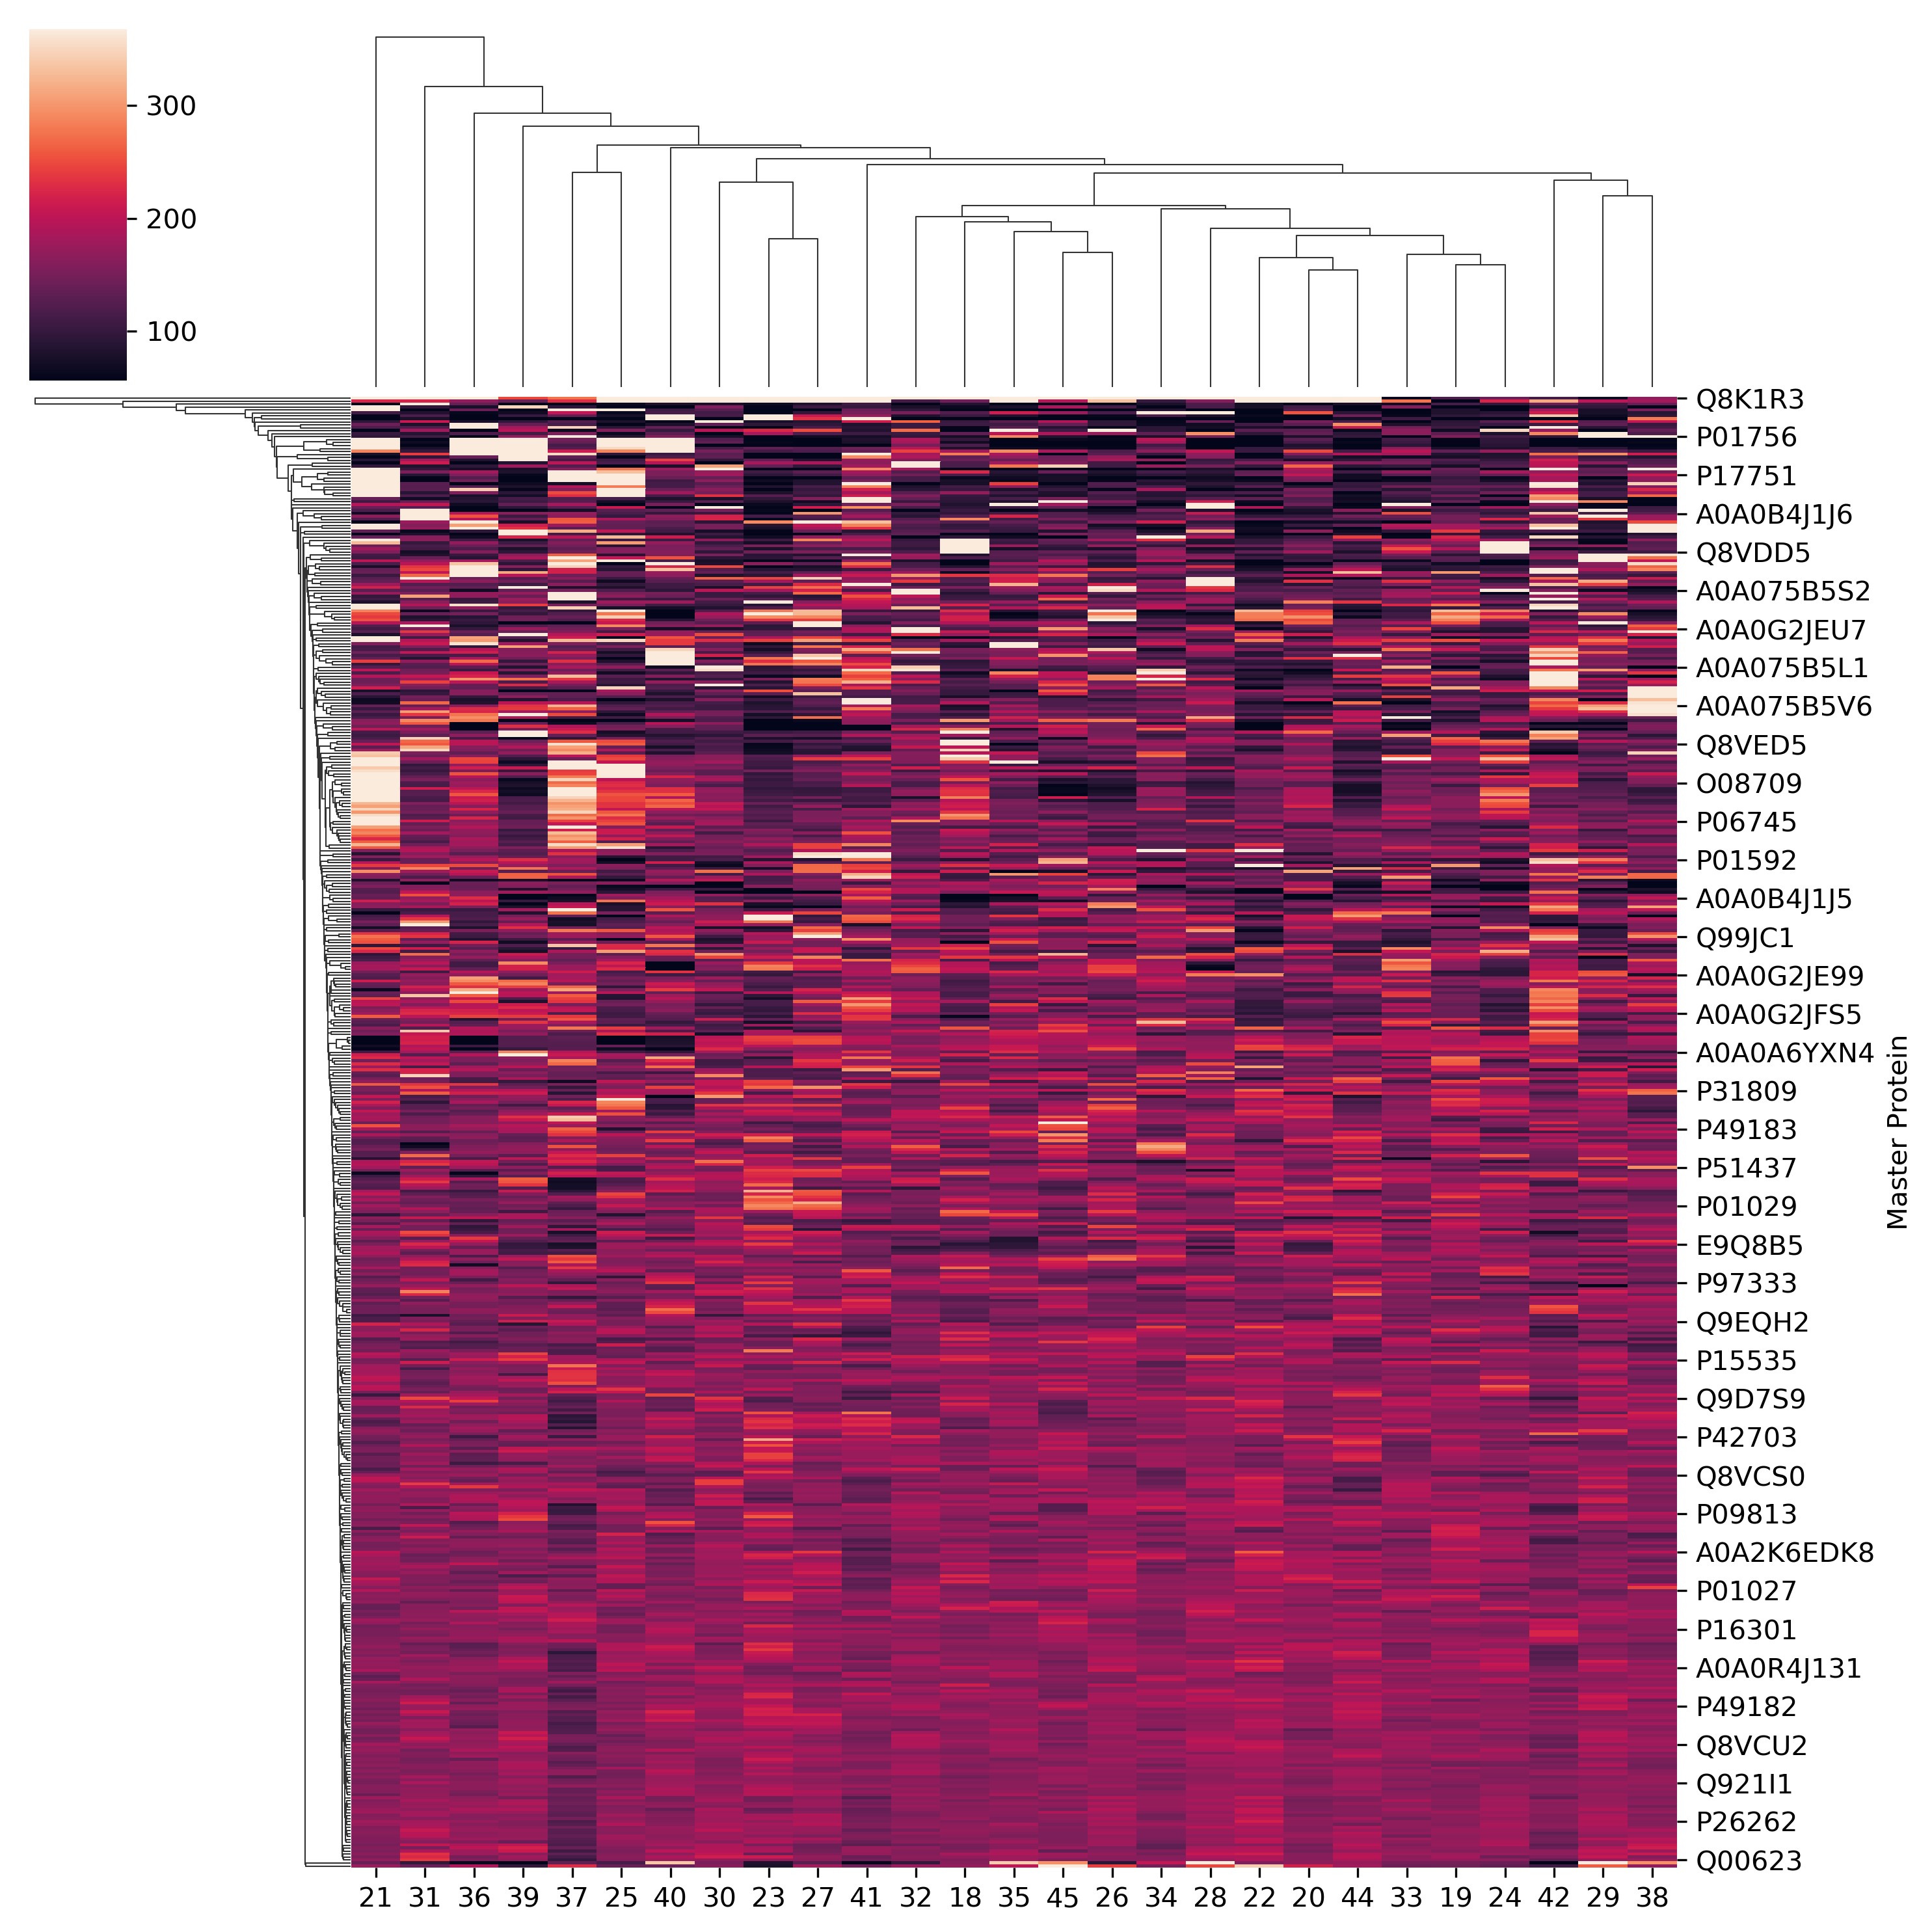

In [87]:
#Perform a mainly default settings (added robustness for better visualization) heirchical clustering analysis on the data using seaborn clustermap to look for batch effects
sns.clustermap(df1, robust = True)

In [88]:
#View the labels (batches) to compare and contrast) 
Labels

Experiment 126 127N 127C 128N 128C 129N 129C 130N 130C      131
Experiment                                                                
10plex1       10plex1  29   23   33   27   22   36   42   21   41  bridge1
10plex2       10plex2  39   35   37   20   18   32   28   45   26  bridge2
10plex3       10plex3  19   25   38   30   44   34   24   31   40  bridge3

In [89]:
#Export dataframes to csv with index - 
Normalized_df.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Normalized_df.csv')


At this point I opened the Normalized_df file in excel, renamed the columns with the correct genotypes, and saved it as an excel file (Normalized_df_named). For some reason in this stem, I couldn't rename them in pandas. I had to rename them in excel and upload them for downstream steps to be compatible for reasons I don't yet entirely understand

In [90]:
# load data file
Normalized_df2 = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Normalized_df_named.xlsx', index_col=0)

## ANOVA by group on normalized data (no imputation)

In [91]:
#Visualize data
Normalized_df2

3m - wt   3m - wt.1   3m - wt.2   3m - wt.3   3m - wt.4  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L3             NaN         NaN         NaN  228.406080   66.670667   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          283.616464  155.662106  199.804524  202.776510   58.515460   
Q9Z2L6          190.181268  141.424181  167.683747  147.438329  248.637140   
Q9Z2U0            6.917337  172.130514    6.868211  139.866469  145.515410   
Q9Z2U1          189.551177  108.888944  170.633984  182.236912  202.094764   
Q9Z331                 NaN  169.650364         NaN  152.792781  206.878537   

                3m - appki  3m - appki.1  3m - appki.2  3m - appki.3  \
Master Protein                                                         
A0A075B5K0      112.903267    122.270686    100.466405    117.205388   
A0A075B5K2      178.041912     91.110384     69.319974    108.579084   
A0A075B5K6      109.799638     90.643023    112.410310    249.768354   
A0A075B5L1       91.270391    141.061164    168.980525    127.445550   
A0A075B5L3       65.451233           NaN           NaN           NaN   
...                    ...           ...           ...           ...   
Q9Z2K1           37.291501    197.816836    154.255451    140.919226   
Q9Z2L6          271.086037    173.694392    175.017280    179.767682   
Q9Z2U0          139.080826    177.535300    180.361788     97.345615   
Q9Z2U1          162.145436    174.001283    161.496914    207.640724   
Q9Z331          139.153517    176.971732    223.481676           NaN   

                3m - appki.4  ...  6m - appki.2  6m - appki.3  6m - appki.4  \
Master Protein                ...                                             
A0A075B5K0        124.442726  ...    138.240201    127.934449    221.879408   
A0A075B5K2        135.333896  ...    231.303910    170.392253    217.500829   
A0A075B5K6        109.195173  ...    156.952938    196.214906    224.137667   
A0A075B5L1        123.452601  ...    319.192166     96.172195    145.560006   
A0A075B5L3         57.168664  ...    470.370640           NaN           NaN   
...                      ...  ...           ...           ...           ...   
Q9Z2K1             42.667970  ...     43.979228    265.676715     81.688972   
Q9Z2L6            318.155723  ...    215.214448    149.546141    179.392235   
Q9Z2U0            165.341787  ...    192.965840    172.838089      6.933033   
Q9Z2U1            176.435919  ...    183.637853    173.978568    177.368416   
Q9Z331            154.232965  ...    150.697255    210.123956           NaN   

                  12m - wt  12m - wt.1  12m - wt.2  12m - appki  \
Master Protein                                                    
A0A075B5K0      255.299453  165.889178  174.591700   106.755853   
A0A075B5K2      164.596444  128.407653  138.197279   144.908942   
A0A075B5K6      194.076338  212.844239  186.851484   167.345348   
A0A075B5L1      130.937027  184.181088   55.902964    85.443715   
A0A075B5L3      178.754522         NaN         NaN          NaN   
...                    ...         ...         ...          ...   
Q9Z2K1           50.430442  209.770156  152.972834   150.447283   
Q9Z2L6          136.640537  134.070246  151.010837   175.746491   
Q9Z2U0          167.694086    6.260730  170.116475     6.865450   
Q9Z2U1          163.303275  329.591862  174.902283   208.815769   
Q9Z331          176.837155         NaN  171.157844          NaN   

                12m - appki.1  12m - appki.2  12m - appki.3  
Master Protein                                               
A0A075B5K0         165.060503     183.97523

In [92]:
df2 = Normalized_df2.dropna()
df2

3m - wt   3m - wt.1   3m - wt.2   3m - wt.3   3m - wt.4  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L7      103.093031  120.866463  116.232200  167.238277  161.054466   
...                    ...         ...         ...         ...         ...   
Q9Z1T2          219.284377  182.525597  227.753663  185.253666  187.747318   
Q9Z2K1          283.616464  155.662106  199.804524  202.776510   58.515460   
Q9Z2L6          190.181268  141.424181  167.683747  147.438329  248.637140   
Q9Z2U0            6.917337  172.130514    6.868211  139.866469  145.515410   
Q9Z2U1          189.551177  108.888944  170.633984  182.236912  202.094764   

                3m - appki  3m - appki.1  3m - appki.2  3m - appki.3  \
Master Protein                                                         
A0A075B5K0      112.903267    122.270686    100.466405    117.205388   
A0A075B5K2      178.041912     91.110384     69.319974    108.579084   
A0A075B5K6      109.799638     90.643023    112.410310    249.768354   
A0A075B5L1       91.270391    141.061164    168.980525    127.445550   
A0A075B5L7      187.762499    154.143959    130.304196     92.757273   
...                    ...           ...           ...           ...   
Q9Z1T2          254.485677    162.225457    182.057165    222.318250   
Q9Z2K1           37.291501    197.816836    154.255451    140.919226   
Q9Z2L6          271.086037    173.694392    175.017280    179.767682   
Q9Z2U0          139.080826    177.535300    180.361788     97.345615   
Q9Z2U1          162.145436    174.001283    161.496914    207.640724   

                3m - appki.4  ...  6m - appki.2  6m - appki.3  6m - appki.4  \
Master Protein                ...                                             
A0A075B5K0        124.442726  ...    138.240201    127.934449    221.879408   
A0A075B5K2        135.333896  ...    231.303910    170.392253    217.500829   
A0A075B5K6        109.195173  ...    156.952938    196.214906    224.137667   
A0A075B5L1        123.452601  ...    319.192166     96.172195    145.560006   
A0A075B5L7        156.880173  ...    198.986925    187.362298    300.806980   
...                      ...  ...           ...           ...           ...   
Q9Z1T2            219.428020  ...    142.221550    168.467820    185.637906   
Q9Z2K1             42.667970  ...     43.979228    265.676715     81.688972   
Q9Z2L6            318.155723  ...    215.214448    149.546141    179.392235   
Q9Z2U0            165.341787  ...    192.965840    172.838089      6.933033   
Q9Z2U1            176.435919  ...    183.637853    173.978568    177.368416   

                  12m - wt  12m - wt.1  12m - wt.2  12m - appki  \
Master Protein                                                    
A0A075B5K0      255.299453  165.889178  174.591700   106.755853   
A0A075B5K2      164.596444  128.407653  138.197279   144.908942   
A0A075B5K6      194.076338  212.844239  186.851484   167.345348   
A0A075B5L1      130.937027  184.181088   55.902964    85.443715   
A0A075B5L7      194.747347  254.196834  268.380670   263.927520   
...                    ...         ...         ...          ...   
Q9Z1T2          151.667064  171.967732  132.647176   152.915208   
Q9Z2K1           50.430442  209.770156  152.972834   150.447283   
Q9Z2L6          136.640537  134.070246  151.010837   175.746491   
Q9Z2U0          167.694086    6.260730  170.116475     6.865450   
Q9Z2U1          163.303275  329.591862  174.902283   208.815769   

                12m - appki.1  12m - appki.2  12m - appki.3  
Master Protein                                               
A0A075B5K0         165.060503     183.97523

In [93]:
df2 = np.log2(Normalized_df2) #log2transforms the data
df2 

3m - wt  3m - wt.1  3m - wt.2  3m - wt.3  3m - wt.4  \
Master Protein                                                         
A0A075B5K0      6.960917   7.223571   6.680968   7.372206   6.625830   
A0A075B5K2      6.963976   7.386083   7.855503   7.074820   6.362082   
A0A075B5K6      7.622107   6.486570   7.402371   7.210213   7.085818   
A0A075B5L1      6.696484   5.707511   6.776522   6.982538   6.911299   
A0A075B5L3           NaN        NaN        NaN   7.835457   6.058980   
...                  ...        ...        ...        ...        ...   
Q9Z2K1          8.147797   7.282274   7.642445   7.663747   5.870746   
Q9Z2L6          7.571231   7.143885   7.389599   7.203968   7.957898   
Q9Z2U0          2.790217   7.427359   2.779934   7.127906   7.185028   
Q9Z2U1          7.566444   6.766714   7.414761   7.509671   7.658888   
Q9Z331               NaN   7.406421        NaN   7.255433   7.692640   

                3m - appki  3m - appki.1  3m - appki.2  3m - appki.3  \
Master Protein                                                         
A0A075B5K0        6.818943      6.933935      6.650569      6.872895   
A0A075B5K2        7.476073      6.509544      6.115199      6.762602   
A0A075B5K6        6.778729      6.502124      6.812631      7.964447   
A0A075B5L1        6.512075      7.140177      7.400713      6.993737   
A0A075B5L3        6.032348           NaN           NaN           NaN   
...                    ...           ...           ...           ...   
Q9Z2K1            5.220775      7.628021      7.269178      7.138725   
Q9Z2L6            8.082607      7.440407      7.451354      7.489990   
Q9Z2U0            7.119780      7.471962      7.494750      6.605044   
Q9Z2U1            7.341145      7.442954      7.335363      7.697946   
Q9Z331            7.120534      7.467375      7.804013           NaN   

                3m - appki.4  ...  6m - appki.2  6m - appki.3  6m - appki.4  \
Master Protein                ...                                             
A0A075B5K0          6.959338  ...      7.111033      6.999261      7.793632   
A0A075B5K2          7.080379  ...      7.853646      7.412716      7.764877   
A0A075B5K6          6.770765  ...      7.294188      7.616291      7.808241   
A0A075B5L1          6.947813  ...      8.318281      6.587548      7.185470   
A0A075B5L3          5.837153  ...      8.877654           NaN           NaN   
...                      ...  ...           ...           ...           ...   
Q9Z2K1              5.415082  ...      5.458750      8.053528      6.352069   
Q9Z2L6              8.313589  ...      7.749631      7.224447      7.486974   
Q9Z2U0              7.369308  ...      7.592202      7.433277      2.793487   
Q9Z2U1              7.463000  ...      7.520720      7.442766      7.470605   
Q9Z331              7.268967  ...      7.235509      7.715097           NaN   

                12m - wt  12m - wt.1  12m - wt.2  12m - appki  12m - appki.1  \
Master Protein                                                                 
A0A075B5K0      7.996047    7.374076    7.447841     6.738171       7.366851   
A0A075B5K2      7.362789    7.004587    7.110585     7.179003       6.997819   
A0A075B5K6      7.600480    7.733654    7.545748     7.386685       7.863478   
A0A075B5L1      7.032729    7.524981    5.804853     6.416902       6.100169   
A0A075B5L3      7.481836         NaN         NaN          NaN            NaN   
...                  ...         ...         ...          ...            ...   
Q9Z2K1          5.656223    7.712666    7.257132     7.233114       6.797839   
Q9Z2L6          7.094242    7.066845    7.238508     7.457352       7.363830   
Q9Z2U0          7.389688    2.646331    7.410379     2.779354       7.341463   
Q9Z2U1          7.351410    8.364537    7.450405     7.706087       7.436888   
Q9Z331          7.466278         NaN    7.419184          NaN       7.183115   

                12m - appki.2  12m - appki.3  
Master Protein             

In [94]:
df2 = df2.dropna()
df2

3m - wt  3m - wt.1  3m - wt.2  3m - wt.3  3m - wt.4  \
Master Protein                                                         
A0A075B5K0      6.960917   7.223571   6.680968   7.372206   6.625830   
A0A075B5K2      6.963976   7.386083   7.855503   7.074820   6.362082   
A0A075B5K6      7.622107   6.486570   7.402371   7.210213   7.085818   
A0A075B5L1      6.696484   5.707511   6.776522   6.982538   6.911299   
A0A075B5L7      6.687803   6.917270   6.860866   7.385761   7.331405   
...                  ...        ...        ...        ...        ...   
Q9Z1T2          7.776659   7.511955   7.831330   7.533358   7.552648   
Q9Z2K1          8.147797   7.282274   7.642445   7.663747   5.870746   
Q9Z2L6          7.571231   7.143885   7.389599   7.203968   7.957898   
Q9Z2U0          2.790217   7.427359   2.779934   7.127906   7.185028   
Q9Z2U1          7.566444   6.766714   7.414761   7.509671   7.658888   

                3m - appki  3m - appki.1  3m - appki.2  3m - appki.3  \
Master Protein                                                         
A0A075B5K0        6.818943      6.933935      6.650569      6.872895   
A0A075B5K2        7.476073      6.509544      6.115199      6.762602   
A0A075B5K6        6.778729      6.502124      6.812631      7.964447   
A0A075B5L1        6.512075      7.140177      7.400713      6.993737   
A0A075B5L7        7.552765      7.268135      7.025740      6.535389   
...                    ...           ...           ...           ...   
Q9Z1T2            7.991441      7.341856      7.508248      7.796483   
Q9Z2K1            5.220775      7.628021      7.269178      7.138725   
Q9Z2L6            8.082607      7.440407      7.451354      7.489990   
Q9Z2U0            7.119780      7.471962      7.494750      6.605044   
Q9Z2U1            7.341145      7.442954      7.335363      7.697946   

                3m - appki.4  ...  6m - appki.2  6m - appki.3  6m - appki.4  \
Master Protein                ...                                             
A0A075B5K0          6.959338  ...      7.111033      6.999261      7.793632   
A0A075B5K2          7.080379  ...      7.853646      7.412716      7.764877   
A0A075B5K6          6.770765  ...      7.294188      7.616291      7.808241   
A0A075B5L1          6.947813  ...      8.318281      6.587548      7.185470   
A0A075B5L7          7.293519  ...      7.636530      7.549687      8.232694   
...                      ...  ...           ...           ...           ...   
Q9Z1T2              7.777604  ...      7.151996      7.396329      7.536348   
Q9Z2K1              5.415082  ...      5.458750      8.053528      6.352069   
Q9Z2L6              8.313589  ...      7.749631      7.224447      7.486974   
Q9Z2U0              7.369308  ...      7.592202      7.433277      2.793487   
Q9Z2U1              7.463000  ...      7.520720      7.442766      7.470605   

                12m - wt  12m - wt.1  12m - wt.2  12m - appki  12m - appki.1  \
Master Protein                                                                 
A0A075B5K0      7.996047    7.374076    7.447841     6.738171       7.366851   
A0A075B5K2      7.362789    7.004587    7.110585     7.179003       6.997819   
A0A075B5K6      7.600480    7.733654    7.545748     7.386685       7.863478   
A0A075B5L1      7.032729    7.524981    5.804853     6.416902       6.100169   
A0A075B5L7      7.605460    7.989802    8.068137     8.043998       7.352288   
...                  ...         ...         ...          ...            ...   
Q9Z1T2          7.244764    7.425994    7.051450     7.256588       7.206921   
Q9Z2K1          5.656223    7.712666    7.257132     7.233114       6.797839   
Q9Z2L6          7.094242    7.066845    7.238508     7.457352       7.363830   
Q9Z2U0          7.389688    2.646331    7.410379     2.779354       7.341463   
Q9Z2U1          7.351410    8.364537    7.450405     7.706087       7.436888   

                12m - appki.2  12m - appki.3  
Master Protein             

In [95]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df2.reset_index(), id_vars=['Master Protein'], value_vars=['3m - wt', '3m - appki', '6m - wt', '6m - appki', '12m - wt', '12m - appki'])
# replace column names
df_melt.columns = ['index', 'group', 'value']
df_melt

index        group     value
0     A0A075B5K0      3m - wt  6.960917
1     A0A075B5K2      3m - wt  6.963976
2     A0A075B5K6      3m - wt  7.622107
3     A0A075B5L1      3m - wt  6.696484
4     A0A075B5L7      3m - wt  6.687803
...          ...          ...       ...
2977      Q9Z1T2  12m - appki  7.256588
2978      Q9Z2K1  12m - appki  7.233114
2979      Q9Z2L6  12m - appki  7.457352
2980      Q9Z2U0  12m - appki  2.779354
2981      Q9Z2U1  12m - appki  7.706087

[2982 rows x 3 columns]

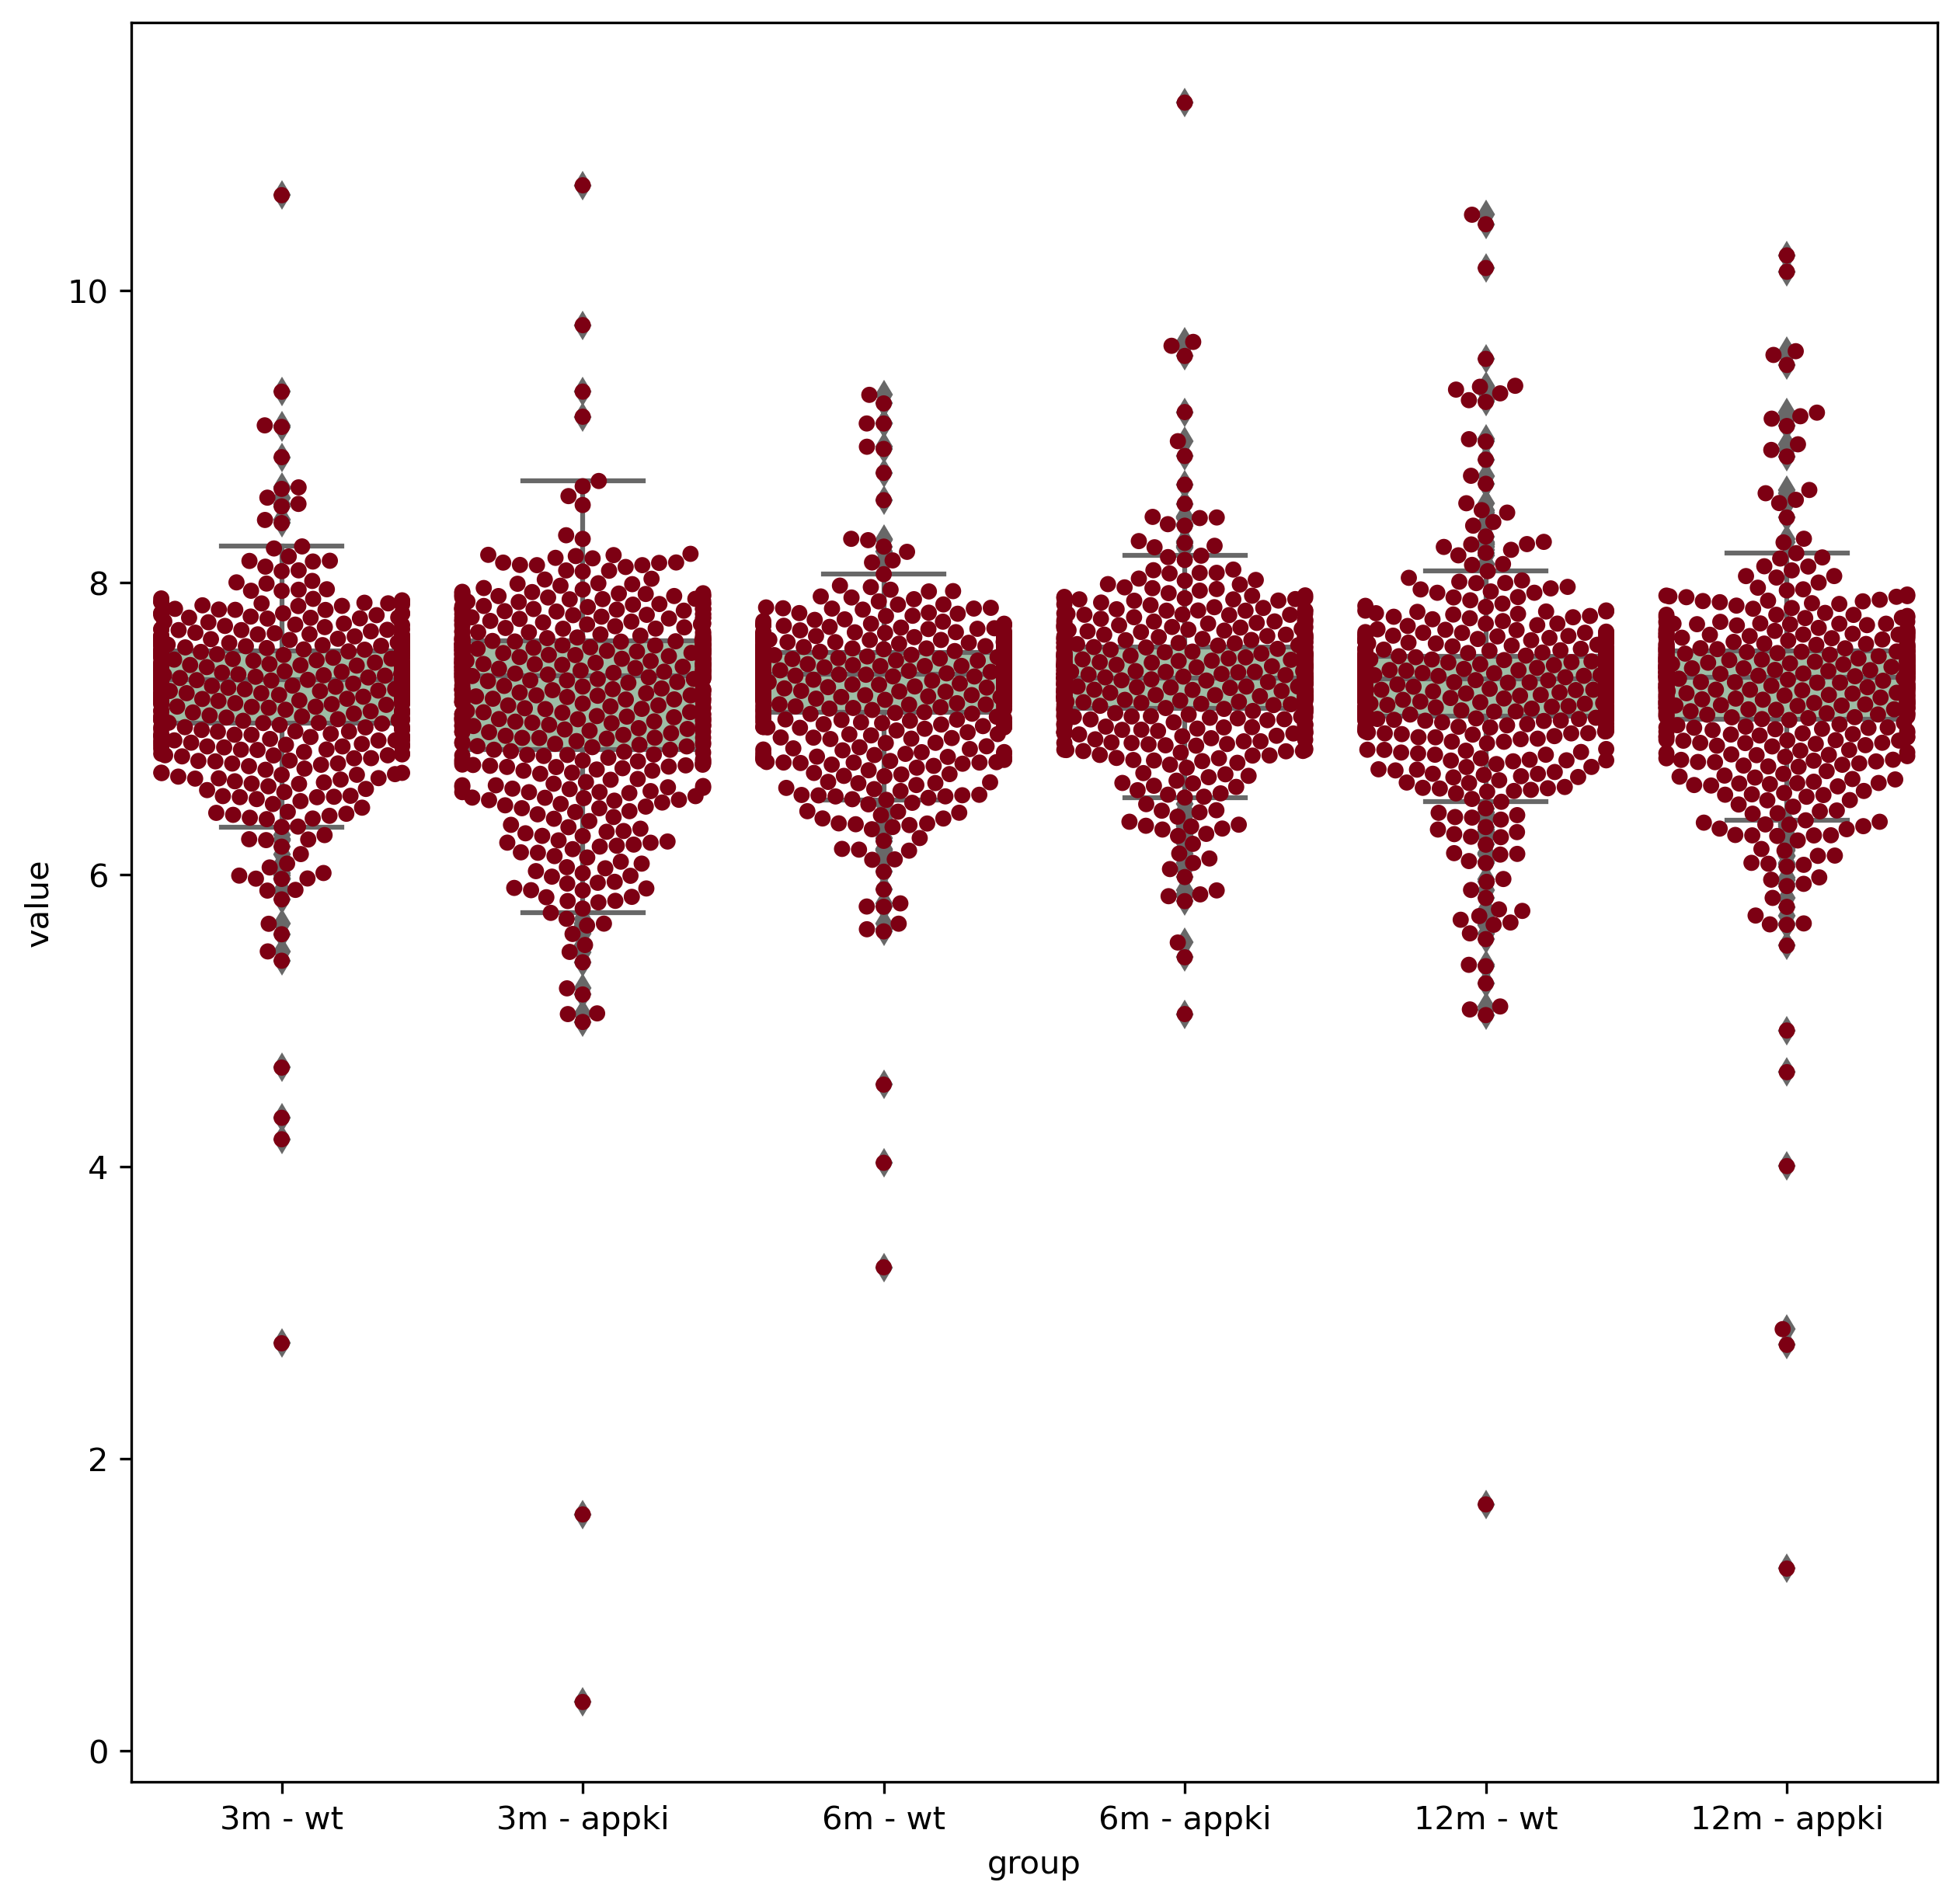

In [96]:
# generate a boxplot to see the data distribution
plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='group', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="group", y="value", data=df_melt, color='#7d0013')
plt.show()

In [97]:
# ANOVA table using bioinfokit v1.0.3 or later 
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(group)')
res.anova_summary
# output (ANOVA F and p value)

df       sum_sq   mean_sq         F    PR(>F)
C(group)     5.0     5.733798  1.146760  2.727041  0.018279
Residual  2976.0  1251.450311  0.420514       NaN       NaN

In [98]:
# perform multiple pairwise comparison (Tukey's HSD)
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='group', anova_model='value ~ C(group)')
res.tukey_summary

group1       group2      Diff     Lower     Upper   q-value   p-value
0      3m - wt   3m - appki  0.061762 -0.055540  0.179064  2.123293  0.641857
1      3m - wt      6m - wt  0.017833 -0.099469  0.135135  0.613077  0.900000
2      3m - wt   6m - appki  0.085566 -0.031736  0.202868  2.941648  0.298061
3      3m - wt     12m - wt  0.029952 -0.087350  0.147254  1.029701  0.900000
4      3m - wt  12m - appki  0.001577 -0.115725  0.118879  0.054210  0.900000
5   3m - appki      6m - wt  0.079595 -0.037707  0.196897  2.736370  0.382169
6   3m - appki   6m - appki  0.147328  0.030026  0.264630  5.064941  0.004674
7   3m - appki     12m - wt  0.091714 -0.025588  0.209016  3.152993  0.224452
8   3m - appki  12m - appki  0.060185 -0.057117  0.177487  2.069083  0.663984
9      6m - wt   6m - appki  0.067733 -0.049569  0.185035  2.328571  0.558064
10     6m - wt     12m - wt  0.012119 -0.105183  0.129421  0.416623  0.900000
11     6m - wt  12m - appki  0.019410 -0.097892  0.136712  0.667287  0.900000
12  6m - appki     12m - wt  0.055615 -0.061688  0.172917  1.911947  0.728126
13  6m - appki  12m - appki  0.087143 -0.030159  0.204445  2.995858  0.277954
14    12m - wt  12m - appki  0.031529 -0.085773  0.148831  1.083911  0.900000

In [99]:
#rename columns
df_pca = df2
df_pca.columns = ['3m wt', '3m wt', '3m wt', '3m wt', '3m wt', '3m appki', '3m appki', '3m appki', '3m appki', '3m appki', '6m wt', '6m wt', '6m wt', '6m wt', '6m wt', '6m appki', '6m appki', '6m appki', '6m appki', '6m appki', '12m wt', '12m wt', '12m wt',  '12m appki', '12 mappki', '12m appki', '12m appki']
df_pca

3m wt     3m wt     3m wt     3m wt     3m wt  3m appki  \
Master Protein                                                               
A0A075B5K0      6.960917  7.223571  6.680968  7.372206  6.625830  6.818943   
A0A075B5K2      6.963976  7.386083  7.855503  7.074820  6.362082  7.476073   
A0A075B5K6      7.622107  6.486570  7.402371  7.210213  7.085818  6.778729   
A0A075B5L1      6.696484  5.707511  6.776522  6.982538  6.911299  6.512075   
A0A075B5L7      6.687803  6.917270  6.860866  7.385761  7.331405  7.552765   
...                  ...       ...       ...       ...       ...       ...   
Q9Z1T2          7.776659  7.511955  7.831330  7.533358  7.552648  7.991441   
Q9Z2K1          8.147797  7.282274  7.642445  7.663747  5.870746  5.220775   
Q9Z2L6          7.571231  7.143885  7.389599  7.203968  7.957898  8.082607   
Q9Z2U0          2.790217  7.427359  2.779934  7.127906  7.185028  7.119780   
Q9Z2U1          7.566444  6.766714  7.414761  7.509671  7.658888  7.341145   

                3m appki  3m appki  3m appki  3m appki  ...  6m appki  \
Master Protein                                          ...             
A0A075B5K0      6.933935  6.650569  6.872895  6.959338  ...  7.111033   
A0A075B5K2      6.509544  6.115199  6.762602  7.080379  ...  7.853646   
A0A075B5K6      6.502124  6.812631  7.964447  6.770765  ...  7.294188   
A0A075B5L1      7.140177  7.400713  6.993737  6.947813  ...  8.318281   
A0A075B5L7      7.268135  7.025740  6.535389  7.293519  ...  7.636530   
...                  ...       ...       ...       ...  ...       ...   
Q9Z1T2          7.341856  7.508248  7.796483  7.777604  ...  7.151996   
Q9Z2K1          7.628021  7.269178  7.138725  5.415082  ...  5.458750   
Q9Z2L6          7.440407  7.451354  7.489990  8.313589  ...  7.749631   
Q9Z2U0          7.471962  7.494750  6.605044  7.369308  ...  7.592202   
Q9Z2U1          7.442954  7.335363  7.697946  7.463000  ...  7.520720   

                6m appki  6m appki    12m wt    12m wt    12m wt  12m appki  \
Master Protein                                                                
A0A075B5K0      6.999261  7.793632  7.996047  7.374076  7.447841   6.738171   
A0A075B5K2      7.412716  7.764877  7.362789  7.004587  7.110585   7.179003   
A0A075B5K6      7.616291  7.808241  7.600480  7.733654  7.545748   7.386685   
A0A075B5L1      6.587548  7.185470  7.032729  7.524981  5.804853   6.416902   
A0A075B5L7      7.549687  8.232694  7.605460  7.989802  8.068137   8.043998   
...                  ...       ...       ...       ...       ...        ...   
Q9Z1T2          7.396329  7.536348  7.244764  7.425994  7.051450   7.256588   
Q9Z2K1          8.053528  6.352069  5.656223  7.712666  7.257132   7.233114   
Q9Z2L6          7.224447  7.486974  7.094242  7.066845  7.238508   7.457352   
Q9Z2U0          7.433277  2.793487  7.389688  2.646331  7.410379   2.779354   
Q9Z2U1          7.442766  7.470605  7.351410  8.364537  7.450405   7.706087   

                12 mappki  12m appki  12m appki  
Master Protein                                   
A0A075B5K0       7.366851   7.523368   7.483734  
A0A075B5K2       6.997819   7.454879   7.526132  
A0A075B5K6       7.863478   7.591581   7.799955  
A0A075B5L1       6.100169   7.786436   7.552065  
A0A075B5L7       7.352288   8.317210   8.104452  
...                   ...        ...        ...  
Q9Z1T2           7.206921   7.215472   7.320819  
Q9Z2K1           6.797839   5.165064   4.814875  
Q9Z2L6           7.363830   7.281117   7.305454  
Q9Z2U0           7.341463   7.536800   7.354521  
Q9Z2U1           7.436888   7.650141   7.416960  

[497 rows x 27 columns]

In [100]:
#transpose the data and reset index
dfidgroup = df_pca.transpose()
dfidgroup2 = dfidgroup.reset_index()
dfidgroup2

Master Protein      index  A0A075B5K0  A0A075B5K2  A0A075B5K6  A0A075B5L1  \
0                   3m wt    6.960917    6.963976    7.622107    6.696484   
1                   3m wt    7.223571    7.386083    6.486570    5.707511   
2                   3m wt    6.680968    7.855503    7.402371    6.776522   
3                   3m wt    7.372206    7.074820    7.210213    6.982538   
4                   3m wt    6.625830    6.362082    7.085818    6.911299   
5                3m appki    6.818943    7.476073    6.778729    6.512075   
6                3m appki    6.933935    6.509544    6.502124    7.140177   
7                3m appki    6.650569    6.115199    6.812631    7.400713   
8                3m appki    6.872895    6.762602    7.964447    6.993737   
9                3m appki    6.959338    7.080379    6.770765    6.947813   
10                  6m wt    7.184684    9.285259    7.709199    7.196586   
11                  6m wt    8.509136    8.297377    7.970442    7.076017   
12                  6m wt    7.781505    7.014376    6.985162    8.628886   
13                  6m wt    7.201200    7.037111    7.164704    7.065588   
14                  6m wt    6.966568    7.388662    7.488894    6.771771   
15               6m appki    8.967733    7.627908    6.752695    6.933716   
16               6m appki    6.481527    7.895568    8.022487    8.414367   
17               6m appki    7.111033    7.853646    7.294188    8.318281   
18               6m appki    6.999261    7.412716    7.616291    6.587548   
19               6m appki    7.793632    7.764877    7.808241    7.185470   
20                 12m wt    7.996047    7.362789    7.600480    7.032729   
21                 12m wt    7.374076    7.004587    7.733654    7.524981   
22                 12m wt    7.447841    7.110585    7.545748    5.804853   
23              12m appki    6.738171    7.179003    7.386685    6.416902   
24              12 mappki    7.366851    6.997819    7.863478    6.100169   
25              12m appki    7.523368    7.454879    7.591581    7.786436   
26              12m appki    7.483734    7.526132    7.799955    7.552065   

Master Protein  A0A075B5L7  A0A075B5M1  A0A075B5M3  A0A075B5M4  A0A075B5M7  \
0                 6.687803    7.056873    7.241895    7.150489    5.662964   
1                 6.917270    6.241744    7.694640    6.915061    6.093708   
2                 6.860866    6.844369    6.613603    6.241210    5.878353   
3                 7.385761    5.666929    6.837074    6.498795    6.884795   
4                 7.331405    5.914977    7.285993    6.850146    5.843773   
5                 7.552765    5.818746    6.205259    7.063958    7.359646   
6                 7.268135    6.412059    6.843763    6.619875    5.633696   
7                 7.025740    5.903441    6.755174    6.736355    5.528434   
8                 6.535389    7.433901    8.400010    7.553207    6.399270   
9                 7.293519    5.750123    7.302124    6.402537    7.029632   
10                7.614628    7.346945    7.649424    6.675833    6.800387   
11                7.241130    6.638389    7.339159    6.819656    7.352748   
12                6.774245    7.065391    7.322760    6.601718    6.320536   
13                7.457984    6.243332    6.482377    6.571777    7.071942   
14                7.939615    7.149884    7.584772    7.195427    7.442813   
15                7.203331    6.547080    6.912789    7.506850    7.632352   
16                7.658531    7.574421    8.118724    7.301214    6.812219   
17                7.636530    6.096044    8.098895    7.084835    6.738786   
18                7.549687    5.578451    6.121004    7.441767    6.541110   
19                8.232694    7.412062    7.358126    7.100476    7.481354   
20                7.605460    7.131663    7.604909    6.393889    8.389348   
21                7.989802    7.048336    7.073149    6.782145    8.881028   
22                8.068137    6.405353    6.91999

In [101]:
#create two new columns (age and genotype) after splitting the index by the space
dfidgroup2[['age','genotype']] = dfidgroup2['index'].str.split(' ',expand=True)
dfidgroup2.head()

Master Protein  index  A0A075B5K0  A0A075B5K2  A0A075B5K6  A0A075B5L1  \
0               3m wt    6.960917    6.963976    7.622107    6.696484   
1               3m wt    7.223571    7.386083    6.486570    5.707511   
2               3m wt    6.680968    7.855503    7.402371    6.776522   
3               3m wt    7.372206    7.074820    7.210213    6.982538   
4               3m wt    6.625830    6.362082    7.085818    6.911299   

Master Protein  A0A075B5L7  A0A075B5M1  A0A075B5M3  A0A075B5M4  A0A075B5M7  \
0                 6.687803    7.056873    7.241895    7.150489    5.662964   
1                 6.917270    6.241744    7.694640    6.915061    6.093708   
2                 6.860866    6.844369    6.613603    6.241210    5.878353   
3                 7.385761    5.666929    6.837074    6.498795    6.884795   
4                 7.331405    5.914977    7.285993    6.850146    5.843773   

Master Protein  ...    Q9Z126    Q9Z1R3    Q9Z1R9    Q9Z1T2    Q9Z2K1  \
0               ...  6.877556  7.354349  7.102156  7.776659  8.147797   
1               ...  5.077722  7.632111  7.108514  7.511955  7.282274   
2               ...  6.364371  7.481286  7.212869  7.831330  7.642445   
3               ...  8.934750  7.377963  6.996380  7.533358  7.663747   
4               ...  4.987075  7.683251  7.189876  7.552648  5.870746   

Master Protein    Q9Z2L6    Q9Z2U0    Q9Z2U1  age  genotype  
0               7.571231  2.790217  7.566444   3m        wt  
1               7.143885  7.427359  6.766714   3m        wt  
2               7.389599  2.779934  7.414761   3m        wt  
3               7.203968  7.127906  7.509671   3m        wt  
4               7.957898  7.185028  7.658888   3m        wt  

[5 rows x 500 columns]

In [102]:
#Assign unique numbers based upon the age column
dfidgroup2['ageid'] = dfidgroup2.groupby(['age']).ngroup()
dfidgroup2

Master Protein      index  A0A075B5K0  A0A075B5K2  A0A075B5K6  A0A075B5L1  \
0                   3m wt    6.960917    6.963976    7.622107    6.696484   
1                   3m wt    7.223571    7.386083    6.486570    5.707511   
2                   3m wt    6.680968    7.855503    7.402371    6.776522   
3                   3m wt    7.372206    7.074820    7.210213    6.982538   
4                   3m wt    6.625830    6.362082    7.085818    6.911299   
5                3m appki    6.818943    7.476073    6.778729    6.512075   
6                3m appki    6.933935    6.509544    6.502124    7.140177   
7                3m appki    6.650569    6.115199    6.812631    7.400713   
8                3m appki    6.872895    6.762602    7.964447    6.993737   
9                3m appki    6.959338    7.080379    6.770765    6.947813   
10                  6m wt    7.184684    9.285259    7.709199    7.196586   
11                  6m wt    8.509136    8.297377    7.970442    7.076017   
12                  6m wt    7.781505    7.014376    6.985162    8.628886   
13                  6m wt    7.201200    7.037111    7.164704    7.065588   
14                  6m wt    6.966568    7.388662    7.488894    6.771771   
15               6m appki    8.967733    7.627908    6.752695    6.933716   
16               6m appki    6.481527    7.895568    8.022487    8.414367   
17               6m appki    7.111033    7.853646    7.294188    8.318281   
18               6m appki    6.999261    7.412716    7.616291    6.587548   
19               6m appki    7.793632    7.764877    7.808241    7.185470   
20                 12m wt    7.996047    7.362789    7.600480    7.032729   
21                 12m wt    7.374076    7.004587    7.733654    7.524981   
22                 12m wt    7.447841    7.110585    7.545748    5.804853   
23              12m appki    6.738171    7.179003    7.386685    6.416902   
24              12 mappki    7.366851    6.997819    7.863478    6.100169   
25              12m appki    7.523368    7.454879    7.591581    7.786436   
26              12m appki    7.483734    7.526132    7.799955    7.552065   

Master Protein  A0A075B5L7  A0A075B5M1  A0A075B5M3  A0A075B5M4  A0A075B5M7  \
0                 6.687803    7.056873    7.241895    7.150489    5.662964   
1                 6.917270    6.241744    7.694640    6.915061    6.093708   
2                 6.860866    6.844369    6.613603    6.241210    5.878353   
3                 7.385761    5.666929    6.837074    6.498795    6.884795   
4                 7.331405    5.914977    7.285993    6.850146    5.843773   
5                 7.552765    5.818746    6.205259    7.063958    7.359646   
6                 7.268135    6.412059    6.843763    6.619875    5.633696   
7                 7.025740    5.903441    6.755174    6.736355    5.528434   
8                 6.535389    7.433901    8.400010    7.553207    6.399270   
9                 7.293519    5.750123    7.302124    6.402537    7.029632   
10                7.614628    7.346945    7.649424    6.675833    6.800387   
11                7.241130    6.638389    7.339159    6.819656    7.352748   
12                6.774245    7.065391    7.322760    6.601718    6.320536   
13                7.457984    6.243332    6.482377    6.571777    7.071942   
14                7.939615    7.149884    7.584772    7.195427    7.442813   
15                7.203331    6.547080    6.912789    7.506850    7.632352   
16                7.658531    7.574421    8.118724    7.301214    6.812219   
17                7.636530    6.096044    8.098895    7.084835    6.738786   
18                7.549687    5.578451    6.121004    7.441767    6.541110   
19                8.232694    7.412062    7.358126    7.100476    7.481354   
20                7.605460    7.131663    7.604909    6.393889    8.389348   
21                7.989802    7.048336    7.073149    6.782145    8.881028   
22                8.068137    6.405353    6.91999

In [103]:
#Assign unique numbers based upon the genotype column
dfidgroup2['genotypeid'] = dfidgroup2.groupby(['genotype']).ngroup()
dfidgroup2

Master Protein      index  A0A075B5K0  A0A075B5K2  A0A075B5K6  A0A075B5L1  \
0                   3m wt    6.960917    6.963976    7.622107    6.696484   
1                   3m wt    7.223571    7.386083    6.486570    5.707511   
2                   3m wt    6.680968    7.855503    7.402371    6.776522   
3                   3m wt    7.372206    7.074820    7.210213    6.982538   
4                   3m wt    6.625830    6.362082    7.085818    6.911299   
5                3m appki    6.818943    7.476073    6.778729    6.512075   
6                3m appki    6.933935    6.509544    6.502124    7.140177   
7                3m appki    6.650569    6.115199    6.812631    7.400713   
8                3m appki    6.872895    6.762602    7.964447    6.993737   
9                3m appki    6.959338    7.080379    6.770765    6.947813   
10                  6m wt    7.184684    9.285259    7.709199    7.196586   
11                  6m wt    8.509136    8.297377    7.970442    7.076017   
12                  6m wt    7.781505    7.014376    6.985162    8.628886   
13                  6m wt    7.201200    7.037111    7.164704    7.065588   
14                  6m wt    6.966568    7.388662    7.488894    6.771771   
15               6m appki    8.967733    7.627908    6.752695    6.933716   
16               6m appki    6.481527    7.895568    8.022487    8.414367   
17               6m appki    7.111033    7.853646    7.294188    8.318281   
18               6m appki    6.999261    7.412716    7.616291    6.587548   
19               6m appki    7.793632    7.764877    7.808241    7.185470   
20                 12m wt    7.996047    7.362789    7.600480    7.032729   
21                 12m wt    7.374076    7.004587    7.733654    7.524981   
22                 12m wt    7.447841    7.110585    7.545748    5.804853   
23              12m appki    6.738171    7.179003    7.386685    6.416902   
24              12 mappki    7.366851    6.997819    7.863478    6.100169   
25              12m appki    7.523368    7.454879    7.591581    7.786436   
26              12m appki    7.483734    7.526132    7.799955    7.552065   

Master Protein  A0A075B5L7  A0A075B5M1  A0A075B5M3  A0A075B5M4  A0A075B5M7  \
0                 6.687803    7.056873    7.241895    7.150489    5.662964   
1                 6.917270    6.241744    7.694640    6.915061    6.093708   
2                 6.860866    6.844369    6.613603    6.241210    5.878353   
3                 7.385761    5.666929    6.837074    6.498795    6.884795   
4                 7.331405    5.914977    7.285993    6.850146    5.843773   
5                 7.552765    5.818746    6.205259    7.063958    7.359646   
6                 7.268135    6.412059    6.843763    6.619875    5.633696   
7                 7.025740    5.903441    6.755174    6.736355    5.528434   
8                 6.535389    7.433901    8.400010    7.553207    6.399270   
9                 7.293519    5.750123    7.302124    6.402537    7.029632   
10                7.614628    7.346945    7.649424    6.675833    6.800387   
11                7.241130    6.638389    7.339159    6.819656    7.352748   
12                6.774245    7.065391    7.322760    6.601718    6.320536   
13                7.457984    6.243332    6.482377    6.571777    7.071942   
14                7.939615    7.149884    7.584772    7.195427    7.442813   
15                7.203331    6.547080    6.912789    7.506850    7.632352   
16                7.658531    7.574421    8.118724    7.301214    6.812219   
17                7.636530    6.096044    8.098895    7.084835    6.738786   
18                7.549687    5.578451    6.121004    7.441767    6.541110   
19                8.232694    7.412062    7.358126    7.100476    7.481354   
20                7.605460    7.131663    7.604909    6.393889    8.389348   
21                7.989802    7.048336    7.073149    6.782145    8.881028   
22                8.068137    6.405353    6.91999

In [104]:
#Reset the index
dfidgroups = dfidgroup2.set_index('index')
dfidgroups

Master Protein  A0A075B5K0  A0A075B5K2  A0A075B5K6  A0A075B5L1  A0A075B5L7  \
index                                                                        
3m wt             6.960917    6.963976    7.622107    6.696484    6.687803   
3m wt             7.223571    7.386083    6.486570    5.707511    6.917270   
3m wt             6.680968    7.855503    7.402371    6.776522    6.860866   
3m wt             7.372206    7.074820    7.210213    6.982538    7.385761   
3m wt             6.625830    6.362082    7.085818    6.911299    7.331405   
3m appki          6.818943    7.476073    6.778729    6.512075    7.552765   
3m appki          6.933935    6.509544    6.502124    7.140177    7.268135   
3m appki          6.650569    6.115199    6.812631    7.400713    7.025740   
3m appki          6.872895    6.762602    7.964447    6.993737    6.535389   
3m appki          6.959338    7.080379    6.770765    6.947813    7.293519   
6m wt             7.184684    9.285259    7.709199    7.196586    7.614628   
6m wt             8.509136    8.297377    7.970442    7.076017    7.241130   
6m wt             7.781505    7.014376    6.985162    8.628886    6.774245   
6m wt             7.201200    7.037111    7.164704    7.065588    7.457984   
6m wt             6.966568    7.388662    7.488894    6.771771    7.939615   
6m appki          8.967733    7.627908    6.752695    6.933716    7.203331   
6m appki          6.481527    7.895568    8.022487    8.414367    7.658531   
6m appki          7.111033    7.853646    7.294188    8.318281    7.636530   
6m appki          6.999261    7.412716    7.616291    6.587548    7.549687   
6m appki          7.793632    7.764877    7.808241    7.185470    8.232694   
12m wt            7.996047    7.362789    7.600480    7.032729    7.605460   
12m wt            7.374076    7.004587    7.733654    7.524981    7.989802   
12m wt            7.447841    7.110585    7.545748    5.804853    8.068137   
12m appki         6.738171    7.179003    7.386685    6.416902    8.043998   
12 mappki         7.366851    6.997819    7.863478    6.100169    7.352288   
12m appki         7.523368    7.454879    7.591581    7.786436    8.317210   
12m appki         7.483734    7.526132    7.799955    7.552065    8.104452   

Master Protein  A0A075B5M1  A0A075B5M3  A0A075B5M4  A0A075B5M7  A0A075B5N3  \
index                                                                        
3m wt             7.056873    7.241895    7.150489    5.662964    6.994071   
3m wt             6.241744    7.694640    6.915061    6.093708    7.234925   
3m wt             6.844369    6.613603    6.241210    5.878353    7.382396   
3m wt             5.666929    6.837074    6.498795    6.884795    6.017614   
3m wt             5.914977    7.285993    6.850146    5.843773    6.722735   
3m appki          5.818746    6.205259    7.063958    7.359646    6.930753   
3m appki          6.412059    6.843763    6.619875    5.633696    6.906333   
3m appki          5.903441    6.755174    6.736355    5.528434    7.261984   
3m appki          7.433901    8.400010    7.553207    6.399270    7.231894   
3m appki          5.750123    7.302124    6.402537    7.029632    7.784792   
6m wt             7.346945    7.649424    6.675833    6.800387    7.372240   
6m wt             6.638389    7.339159    6.819656    7.352748    7.337004   
6m wt             7.065391    7.322760    6.601718    6.320536    7.672836   
6m wt             6.243332    6.482377    6.571777    7.071942    7.445196   
6m wt             7.149884    7.584772    7.195427    7.442813    7.313016   
6m appki          6.547080    6.912789    7.506850    7.632352    7.596990   
6m appki          7.574421    8.118724    7.301214    6.812219    7.087943   
6m appki          6.096044    8.098895    7.084835    6.738786    7.545500   
6m appki          5.578451    6.121004    7.441767    6.541110    7.425989   
6m appki          7.412062    7.358126    7.100476    7.481354    7.008679   
12m wt            7.1

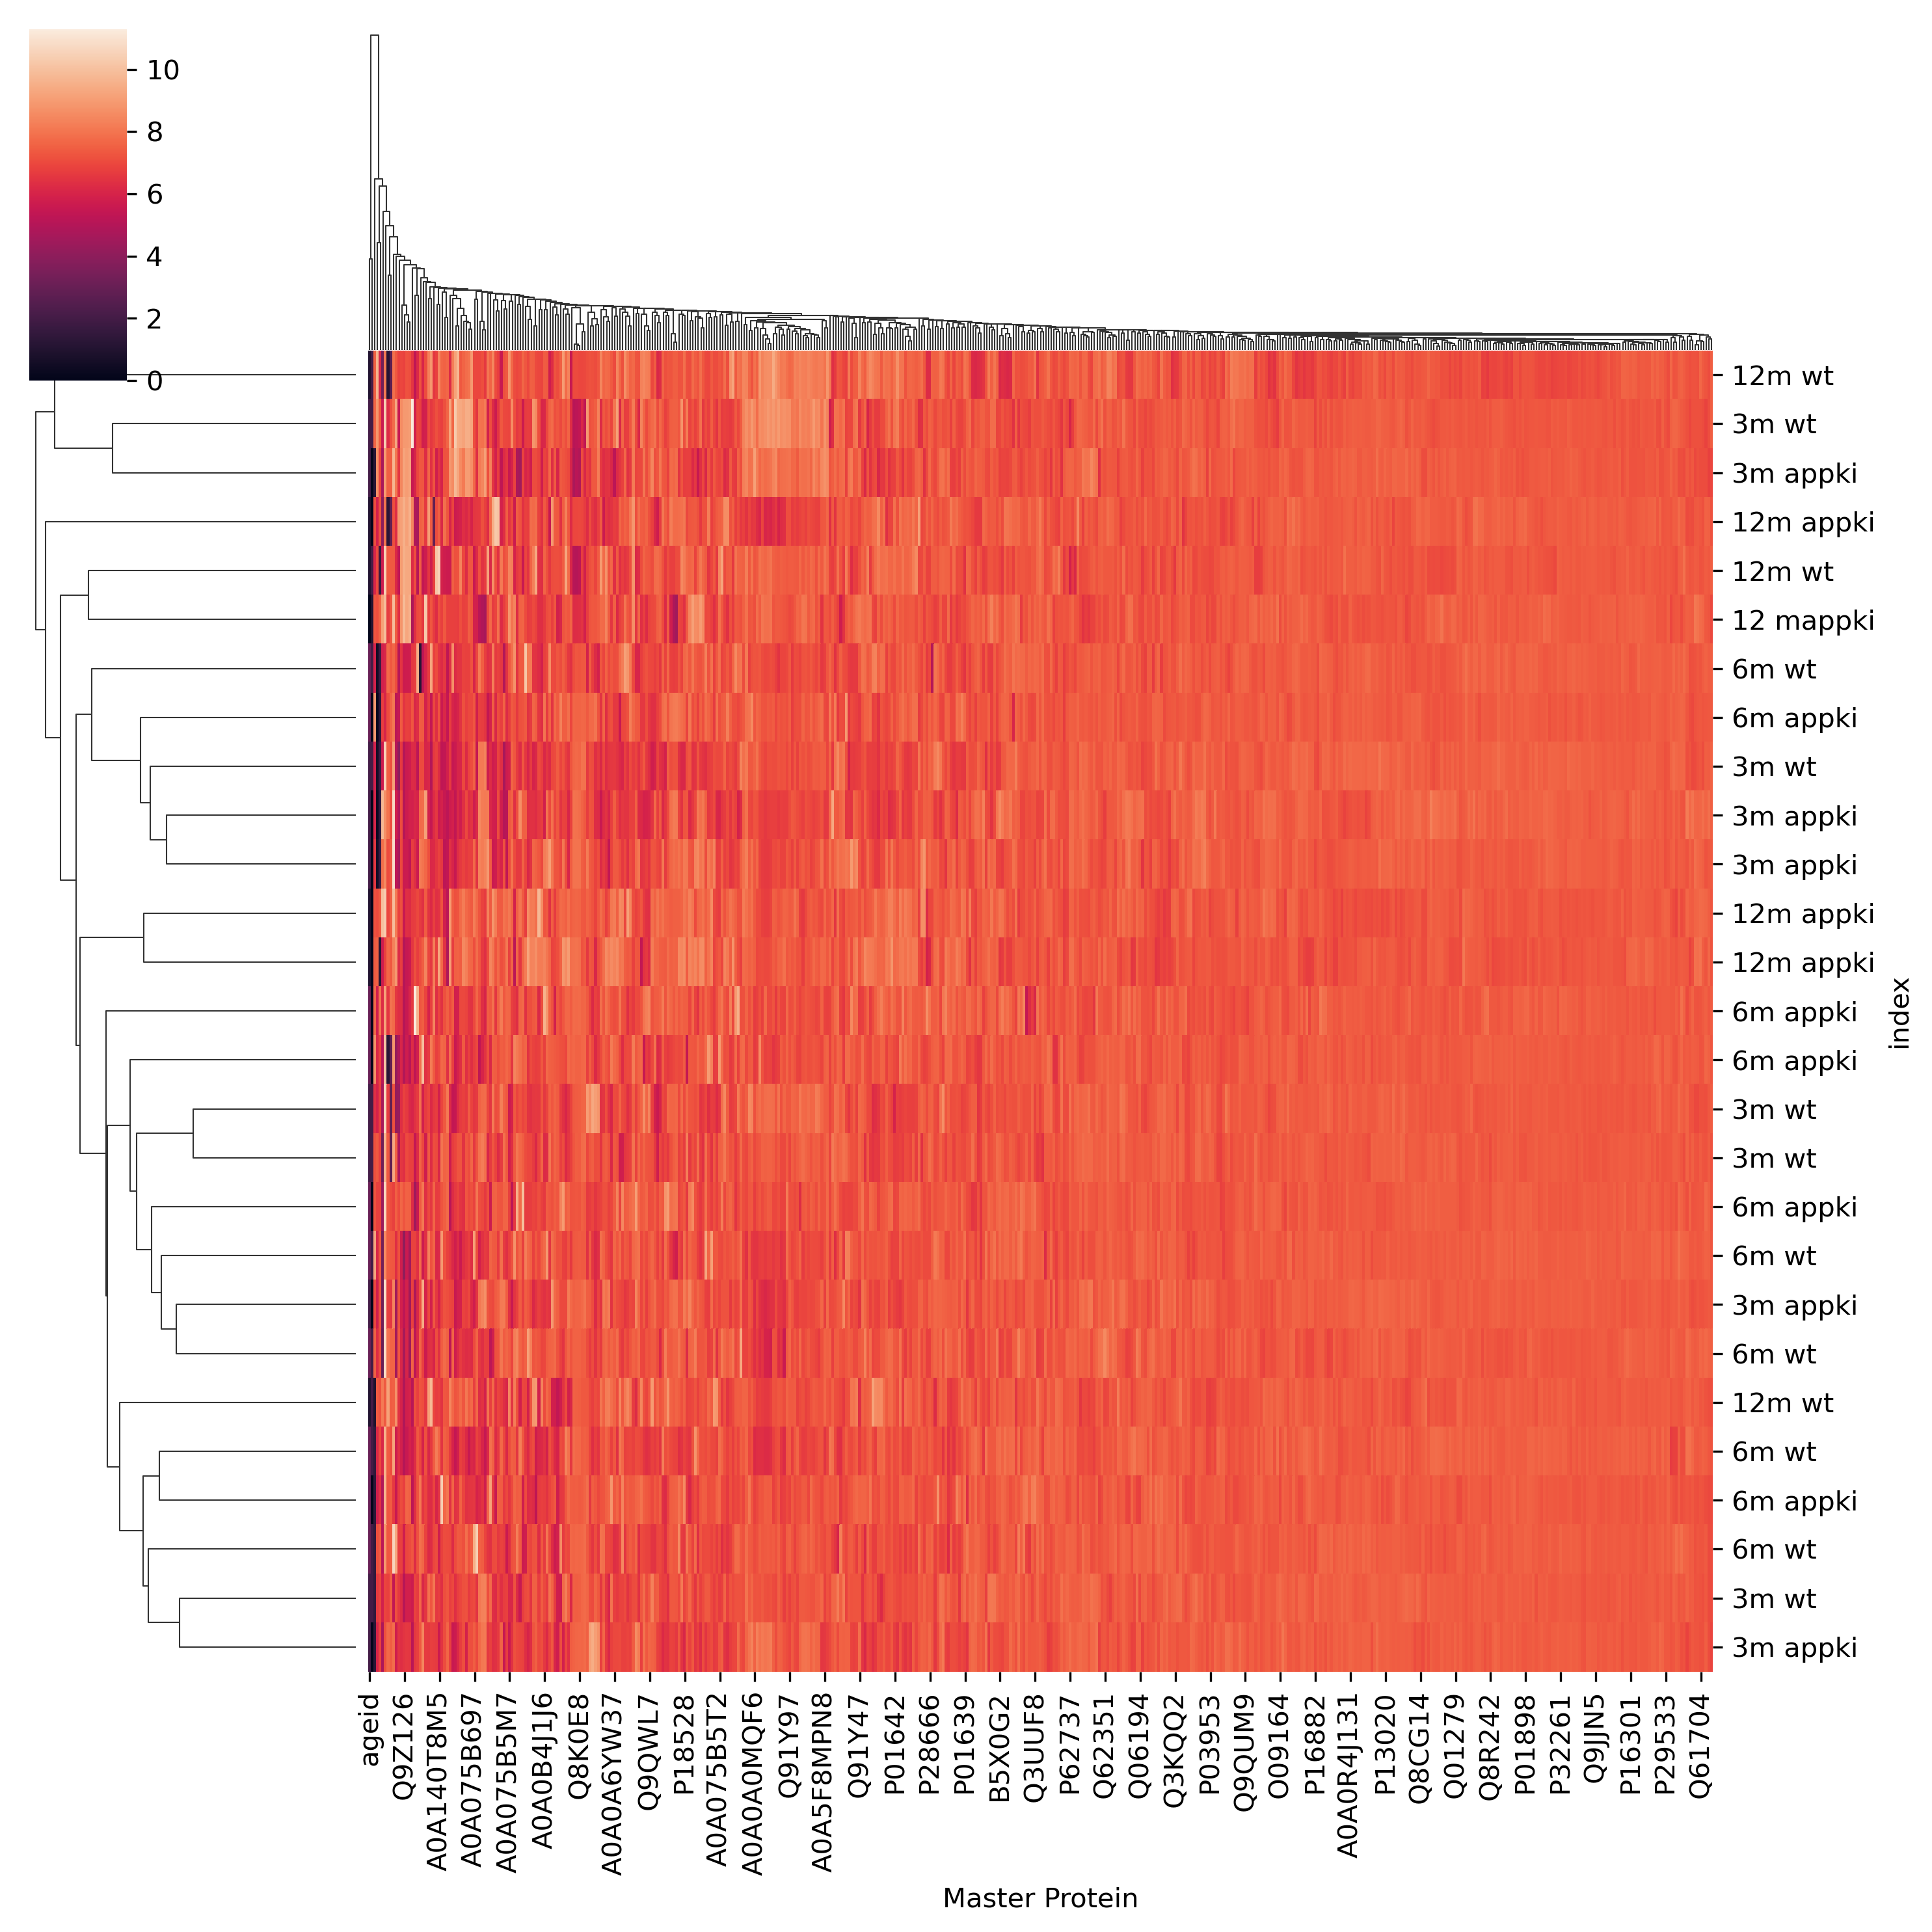

In [105]:
#delete the age and genotype columns
del dfidgroups['age']
del dfidgroups['genotype']
sns.clustermap(dfidgroups)

Text(0.5, 1.3, 'Hierarchical Clustering of WT and APPki Mouse Plasma Proteomics - No imputation')

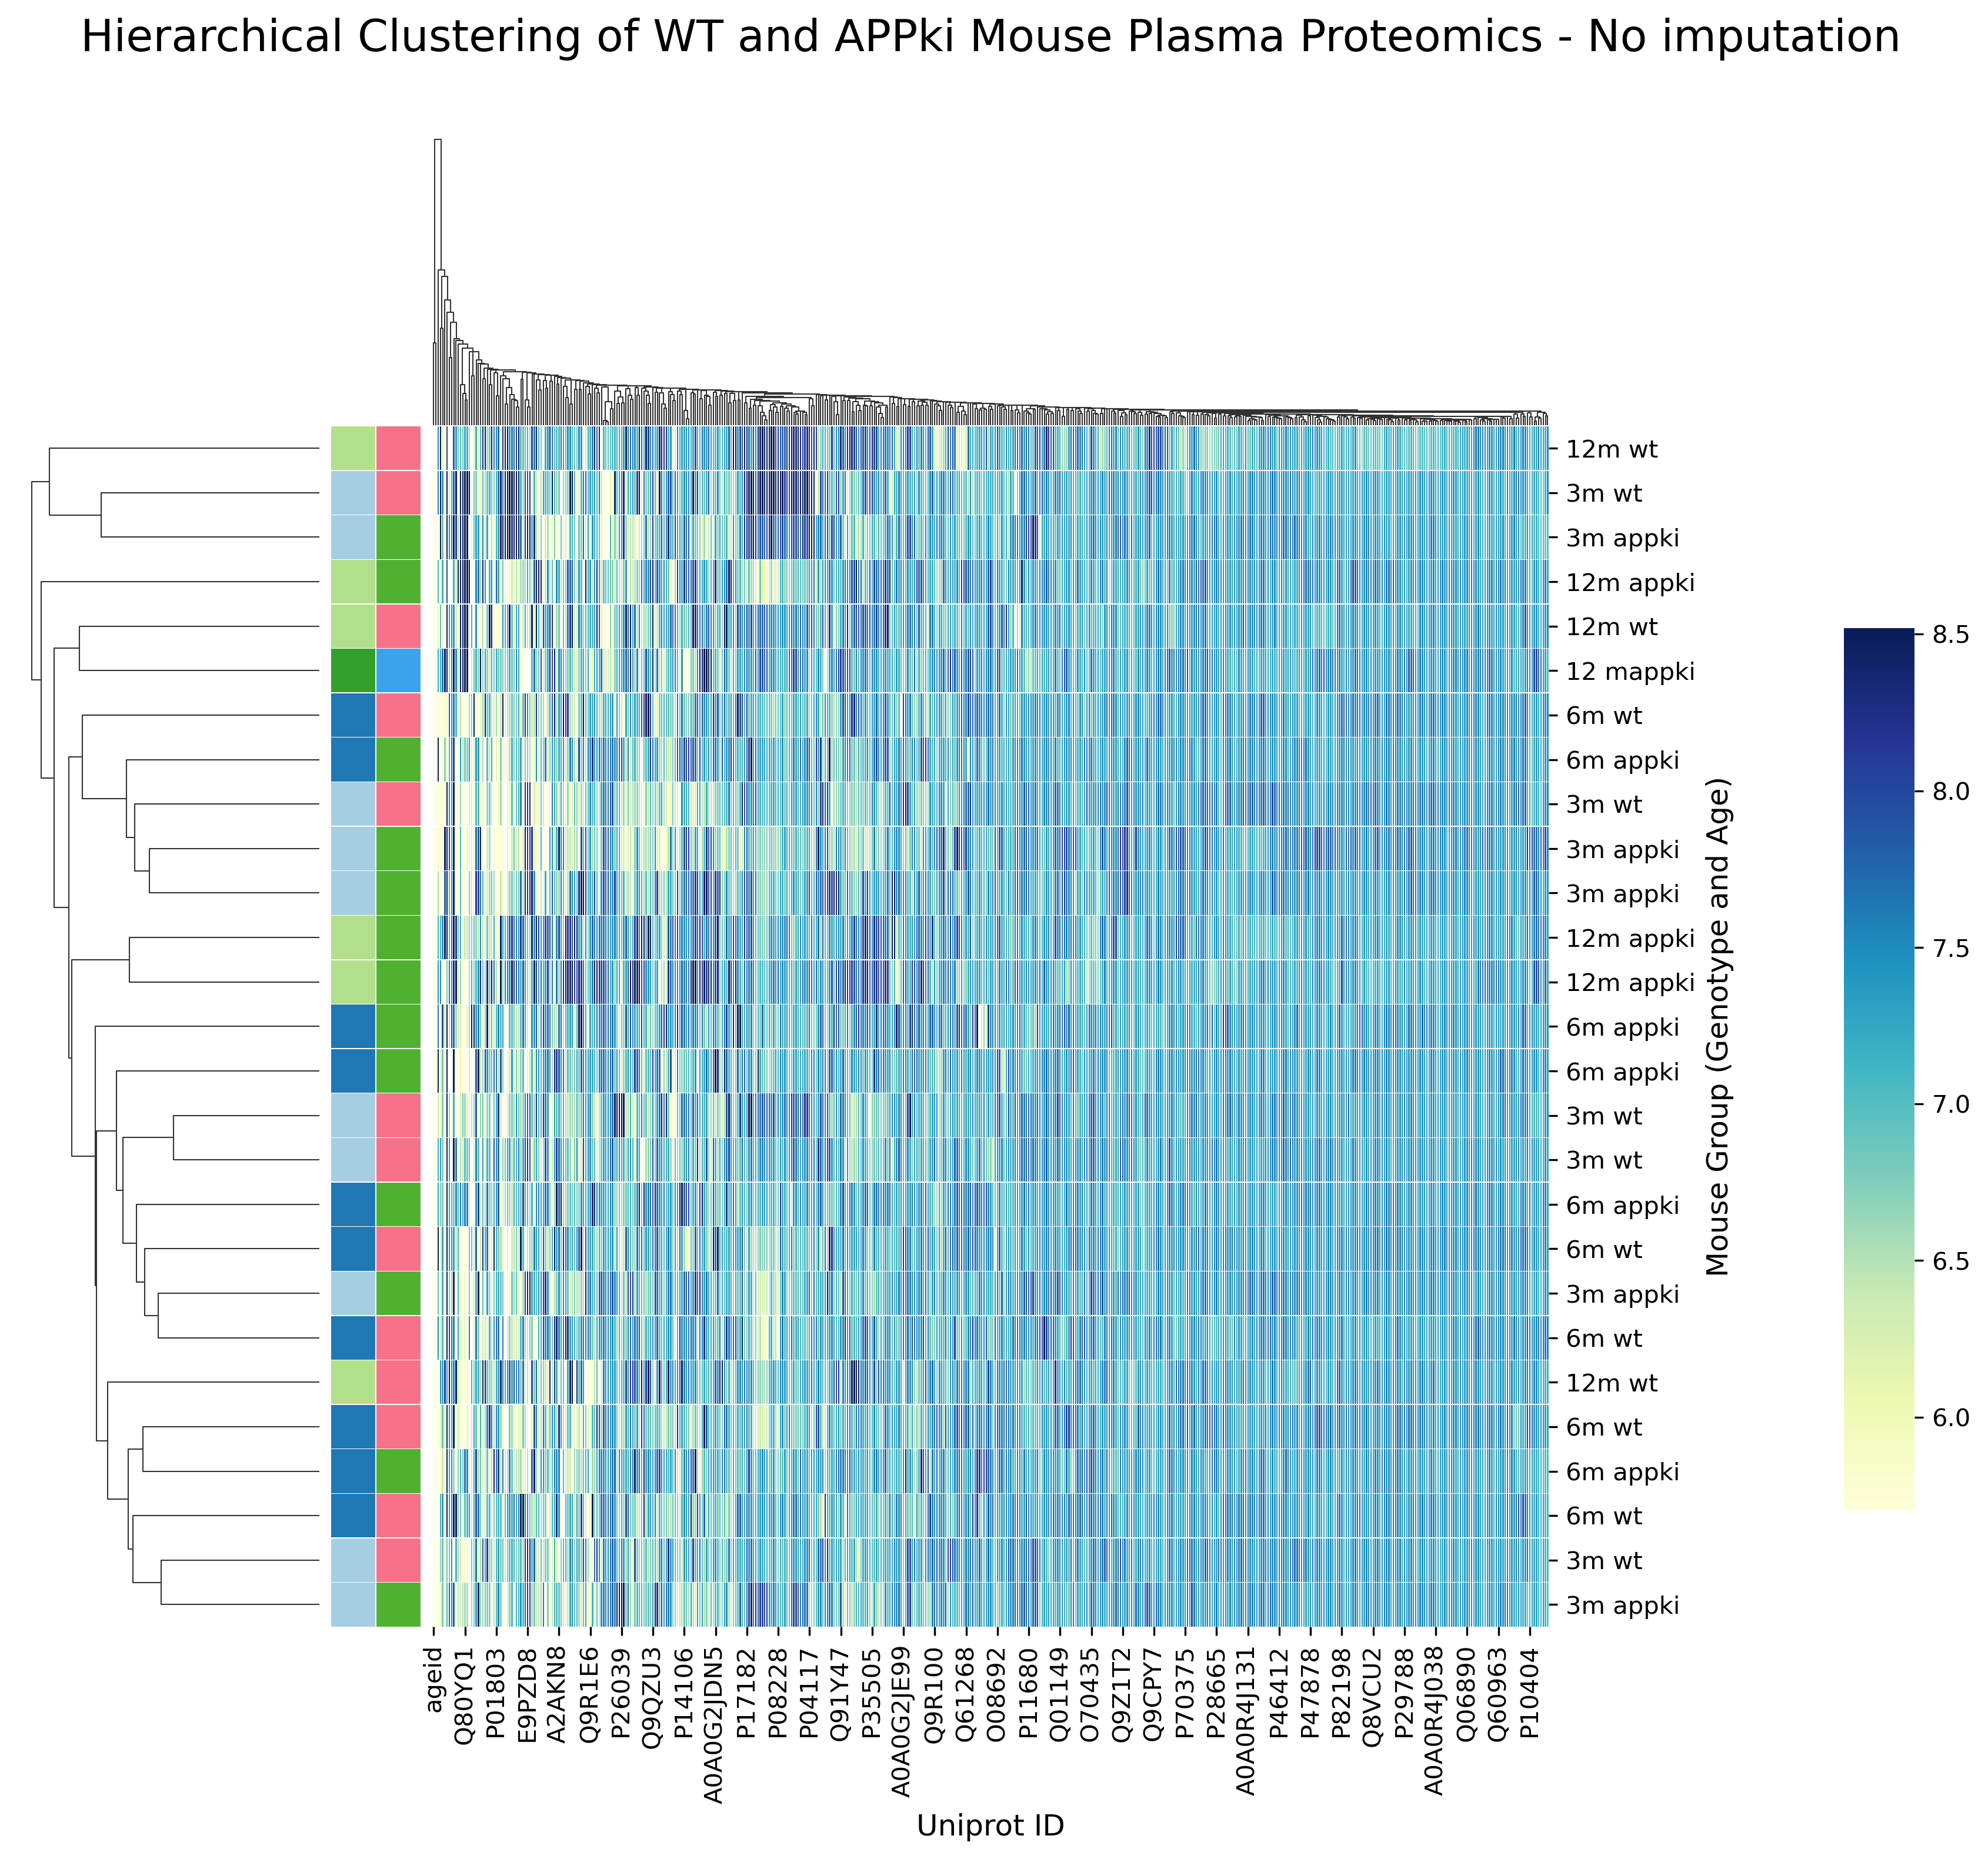

In [106]:
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('Paired', len(dfidgroups.ageid.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(dfidgroups.ageid.unique(), network_pal))

#get the series of all of the categories
networks = dfidgroups.ageid

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#create a second color palette with the same number of colors as unique values in the Source column
network_pal2 = sns.color_palette('husl', len(dfidgroups.genotypeid.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut2 = dict(zip(dfidgroups.genotypeid.unique(), network_pal2))

#get the series of all of the categories
networks2 = dfidgroups.genotypeid

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors2 = pd.Series(networks2).map(network_lut2)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
g = sns.clustermap(dfidgroups, robust = True, cmap = "YlGnBu", linewidths=0.1, cbar_pos=(1.05, .2, .04, .5), row_colors=[network_colors, network_colors2])
ax = g.ax_heatmap
ax.set_xlabel("Uniprot ID", fontsize = 12)
ax.set_ylabel("Mouse Group (Genotype and Age)", fontsize = 12)
ax.set_title('Hierarchical Clustering of WT and APPki Mouse Plasma Proteomics - No imputation', y=1.3, fontsize = 18)

In [107]:
dfpcax = df_pca.transpose()
dfpcarx = dfpcax.reset_index()
dfpcarx

Master Protein      index  A0A075B5K0  A0A075B5K2  A0A075B5K6  A0A075B5L1  \
0                   3m wt    6.960917    6.963976    7.622107    6.696484   
1                   3m wt    7.223571    7.386083    6.486570    5.707511   
2                   3m wt    6.680968    7.855503    7.402371    6.776522   
3                   3m wt    7.372206    7.074820    7.210213    6.982538   
4                   3m wt    6.625830    6.362082    7.085818    6.911299   
5                3m appki    6.818943    7.476073    6.778729    6.512075   
6                3m appki    6.933935    6.509544    6.502124    7.140177   
7                3m appki    6.650569    6.115199    6.812631    7.400713   
8                3m appki    6.872895    6.762602    7.964447    6.993737   
9                3m appki    6.959338    7.080379    6.770765    6.947813   
10                  6m wt    7.184684    9.285259    7.709199    7.196586   
11                  6m wt    8.509136    8.297377    7.970442    7.076017   
12                  6m wt    7.781505    7.014376    6.985162    8.628886   
13                  6m wt    7.201200    7.037111    7.164704    7.065588   
14                  6m wt    6.966568    7.388662    7.488894    6.771771   
15               6m appki    8.967733    7.627908    6.752695    6.933716   
16               6m appki    6.481527    7.895568    8.022487    8.414367   
17               6m appki    7.111033    7.853646    7.294188    8.318281   
18               6m appki    6.999261    7.412716    7.616291    6.587548   
19               6m appki    7.793632    7.764877    7.808241    7.185470   
20                 12m wt    7.996047    7.362789    7.600480    7.032729   
21                 12m wt    7.374076    7.004587    7.733654    7.524981   
22                 12m wt    7.447841    7.110585    7.545748    5.804853   
23              12m appki    6.738171    7.179003    7.386685    6.416902   
24              12 mappki    7.366851    6.997819    7.863478    6.100169   
25              12m appki    7.523368    7.454879    7.591581    7.786436   
26              12m appki    7.483734    7.526132    7.799955    7.552065   

Master Protein  A0A075B5L7  A0A075B5M1  A0A075B5M3  A0A075B5M4  A0A075B5M7  \
0                 6.687803    7.056873    7.241895    7.150489    5.662964   
1                 6.917270    6.241744    7.694640    6.915061    6.093708   
2                 6.860866    6.844369    6.613603    6.241210    5.878353   
3                 7.385761    5.666929    6.837074    6.498795    6.884795   
4                 7.331405    5.914977    7.285993    6.850146    5.843773   
5                 7.552765    5.818746    6.205259    7.063958    7.359646   
6                 7.268135    6.412059    6.843763    6.619875    5.633696   
7                 7.025740    5.903441    6.755174    6.736355    5.528434   
8                 6.535389    7.433901    8.400010    7.553207    6.399270   
9                 7.293519    5.750123    7.302124    6.402537    7.029632   
10                7.614628    7.346945    7.649424    6.675833    6.800387   
11                7.241130    6.638389    7.339159    6.819656    7.352748   
12                6.774245    7.065391    7.322760    6.601718    6.320536   
13                7.457984    6.243332    6.482377    6.571777    7.071942   
14                7.939615    7.149884    7.584772    7.195427    7.442813   
15                7.203331    6.547080    6.912789    7.506850    7.632352   
16                7.658531    7.574421    8.118724    7.301214    6.812219   
17                7.636530    6.096044    8.098895    7.084835    6.738786   
18                7.549687    5.578451    6.121004    7.441767    6.541110   
19                8.232694    7.412062    7.358126    7.100476    7.481354   
20                7.605460    7.131663    7.604909    6.393889    8.389348   
21                7.989802    7.048336    7.073149    6.782145    8.881028   
22                8.068137    6.405353    6.91999

In [108]:
#assign all protein values in dataframe to x
x = dfpcarx.iloc[:, 1: 498].values
#assign groups to y 
y = dfpcarx.loc[:,['index']].values

#view x and y values
x, y

(array([[6.96091654, 6.96397642, 7.62210739, ..., 7.57123134, 2.79021681,
         7.5664436 ],
        [7.22357118, 7.38608308, 6.48656957, ..., 7.14388501, 7.42735906,
         6.76671366],
        [6.68096783, 7.85550259, 7.40237148, ..., 7.38959905, 2.77993428,
         7.4147612 ],
        ...,
        [7.36685113, 6.99781947, 7.86347773, ..., 7.36383047, 7.34146266,
         7.43688815],
        [7.52336779, 7.45487931, 7.59158145, ..., 7.28111684, 7.53680016,
         7.65014065],
        [7.48373387, 7.52613241, 7.799955  , ..., 7.30545438, 7.35452149,
         7.41695989]]),
 array([['3m wt'],
        ['3m wt'],
        ['3m wt'],
        ['3m wt'],
        ['3m wt'],
        ['3m appki'],
        ['3m appki'],
        ['3m appki'],
        ['3m appki'],
        ['3m appki'],
        ['6m wt'],
        ['6m wt'],
        ['6m wt'],
        ['6m wt'],
        ['6m wt'],
        ['6m appki'],
        ['6m appki'],
        ['6m appki'],
        ['6m appki'],
        ['6m appki'],

Standardizing/Scaling the Data¶

There are probably better ways to do this such as assigning % to component axis of nonscaled data, but since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data. Let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms. We can accomplish this using StandardScaler from sklearn

In [109]:
#Scale the data using Standardscaler from sklearn to remove  - this is important for PCA and machine learning processes
x = StandardScaler().fit_transform(x)
x

array([[-0.53118627, -0.59065293,  0.55941158, ...,  0.52233494,
        -2.06176415,  0.28698809],
       [-0.06501905,  0.0981995 , -1.95277409, ..., -0.92179769,
         0.51596214, -2.88423956],
       [-1.02804751,  0.86426363,  0.07328301, ..., -0.09145556,
        -2.06748008, -0.31448924],
       ...,
       [ 0.18927845, -0.53542313,  1.09340271, ..., -0.17853538,
         0.46821346, -0.22674763],
       [ 0.46706884,  0.21047077,  0.4918781 , ..., -0.45804978,
         0.576799  ,  0.61887812],
       [ 0.3967254 ,  0.3267515 ,  0.9528694 , ..., -0.37580586,
         0.47547269, -0.30577063]])

In [110]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

principal component 1  principal component 2
0              -0.074439              10.953344
1              -4.190623               6.398469
2              -2.306288               6.860811
3              12.925943              15.294096
4             -12.535047               8.457640

In [111]:
finalDf = pd.concat([principalDf, dfpcarx[['index']]], axis = 1)
finalDf
finalDf.head(5)

principal component 1  principal component 2  index
0              -0.074439              10.953344  3m wt
1              -4.190623               6.398469  3m wt
2              -2.306288               6.860811  3m wt
3              12.925943              15.294096  3m wt
4             -12.535047               8.457640  3m wt

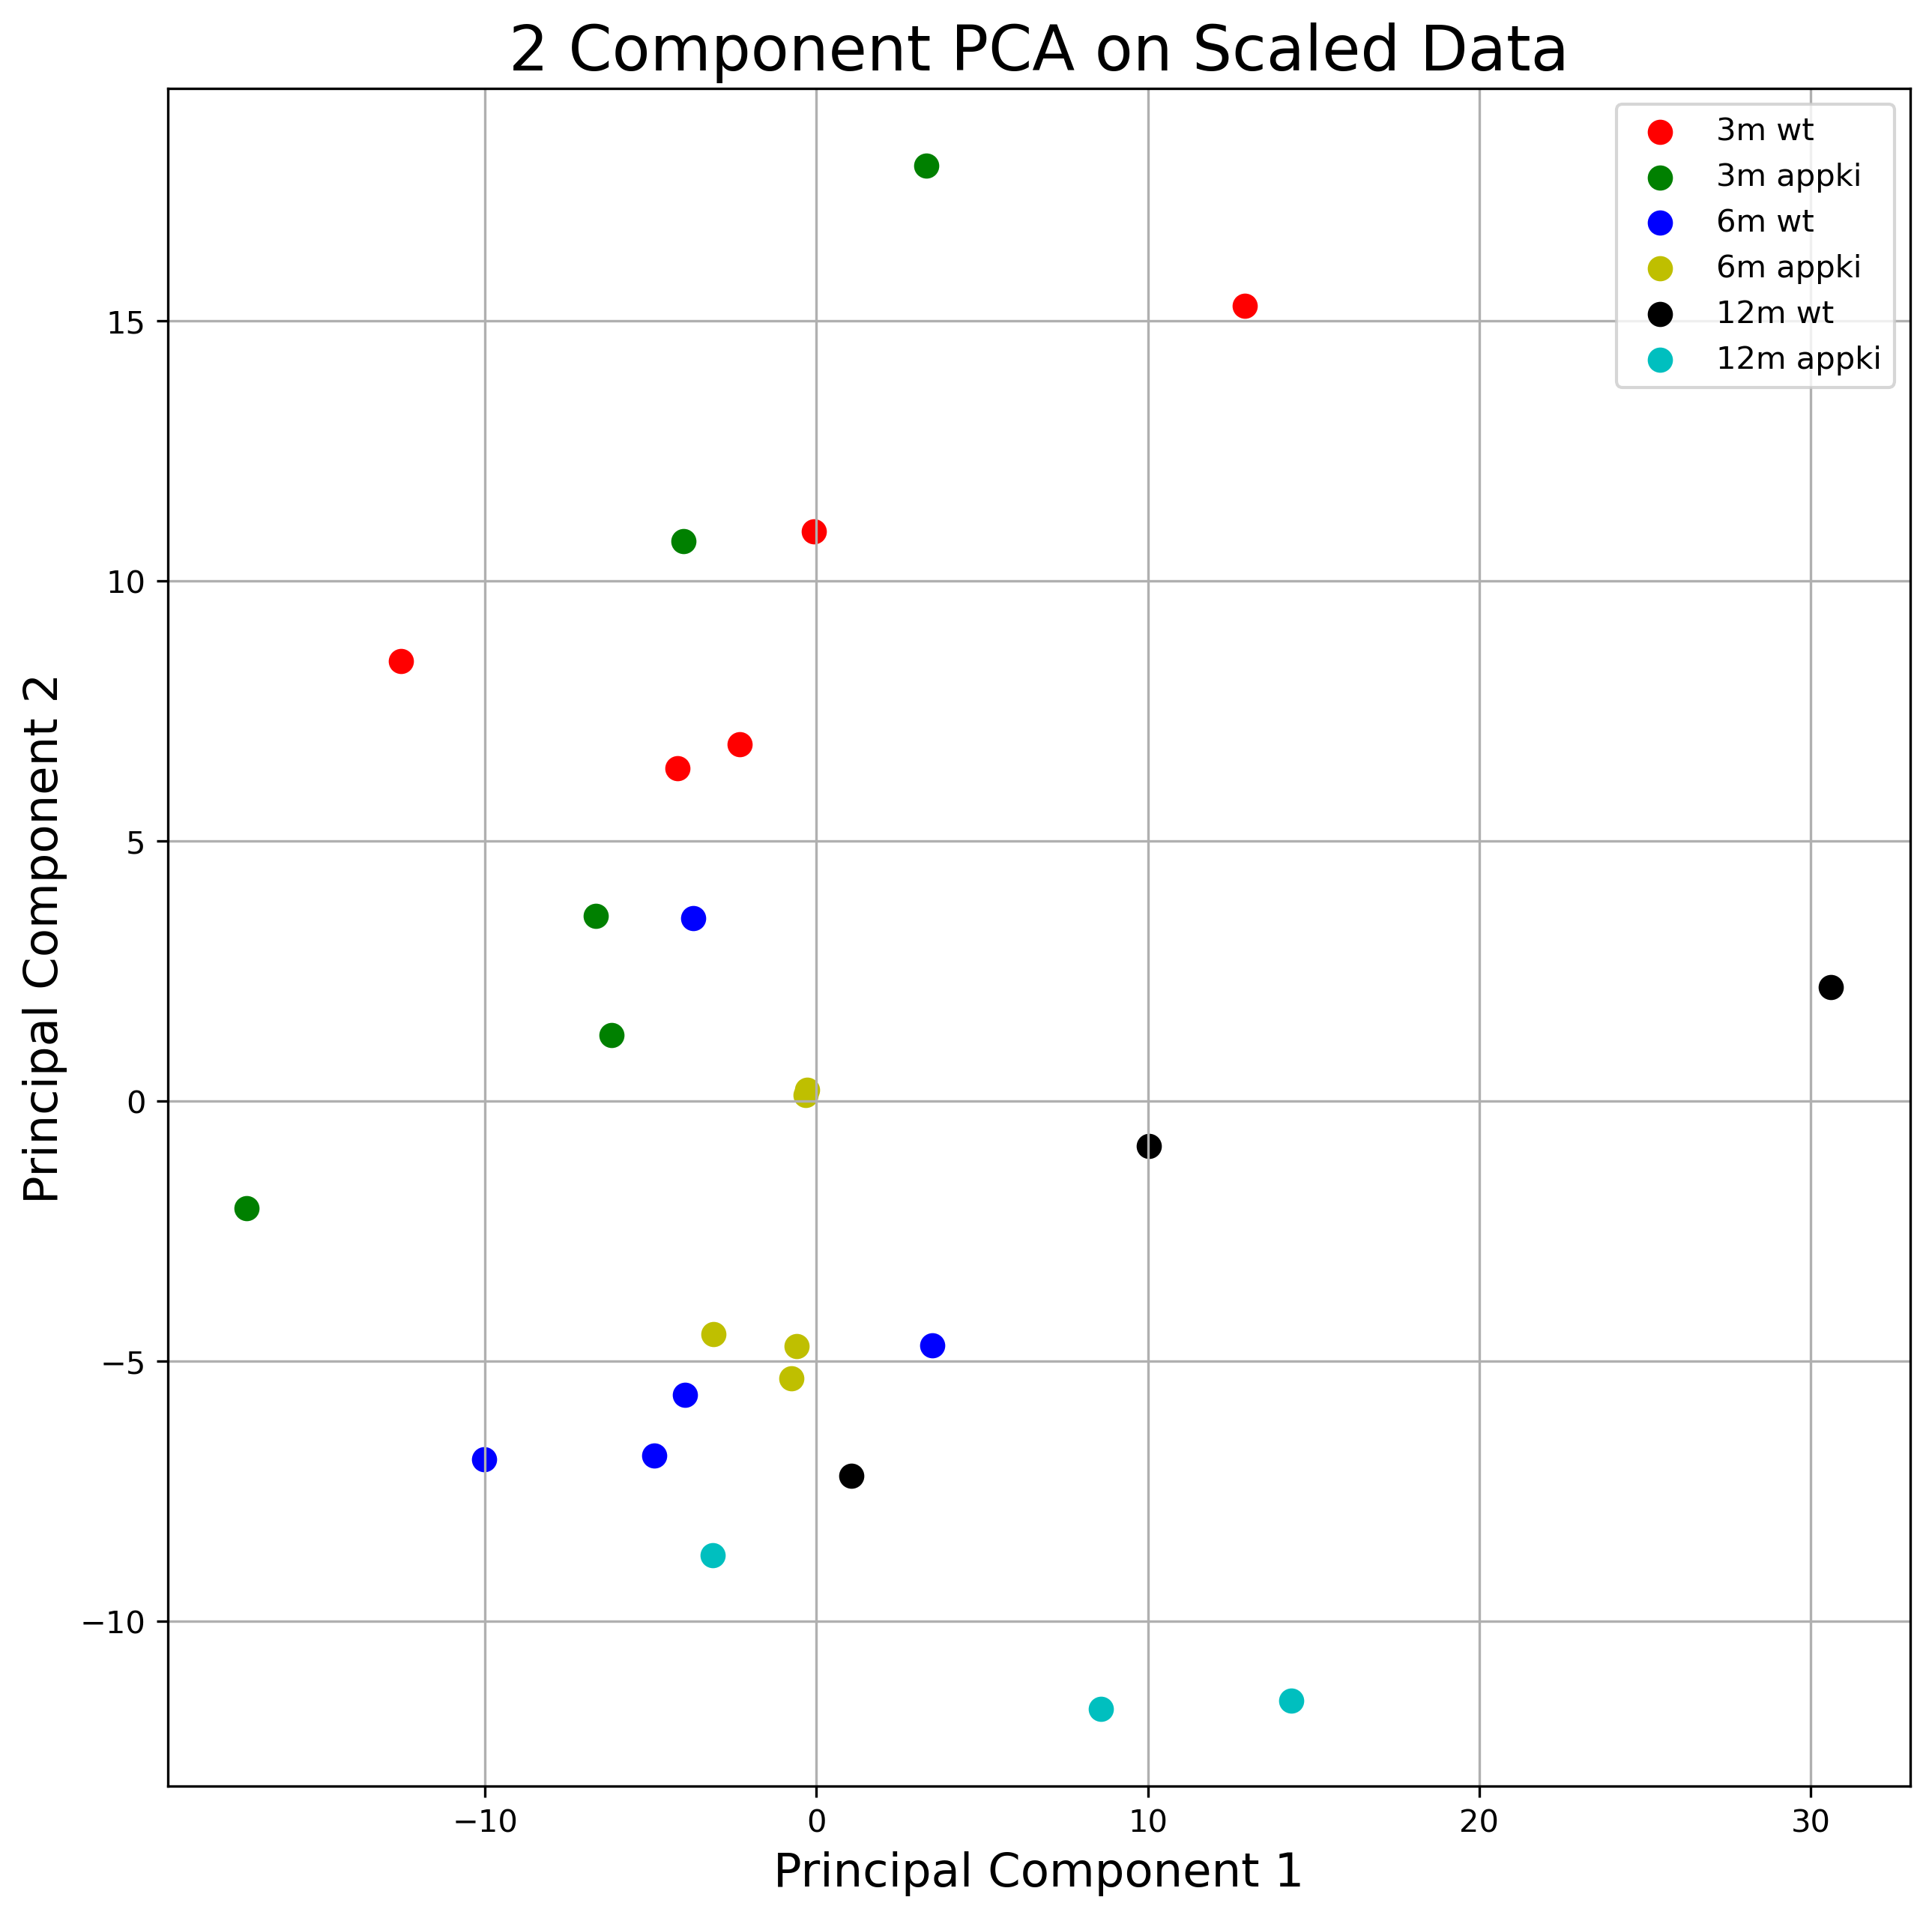

In [112]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA on Scaled Data', fontsize = 20)


targets = ['3m wt', '3m appki', '6m wt', '6m appki', '12m wt', '12m appki']
colors = ['r', 'g', 'b', 'y', 'k', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['index'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Fast Imputation with Random Forests - Imputation by Chained Equations (MICE) - Imputation by group (3mWT, 3mAPPki, 6mWT, 6mAPPki, 12mWT, 12mAPPki)

In [113]:
#Sort the dataframe by column (put them in numerical order)
Normalized_dfsorted = Normalized_df.sort_index(axis=1)
Normalized_dfsorted.head()

18          19          20          21          22  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L3             NaN         NaN         NaN  228.406080   66.670667   

                        23          24          25          26          27  \
Master Protein                                                               
A0A075B5K0      112.903267  122.270686  100.466405  117.205388  124.442726   
A0A075B5K2      178.041912   91.110384   69.319974  108.579084  135.333896   
A0A075B5K6      109.799638   90.643023  112.410310  249.768354  109.195173   
A0A075B5L1       91.270391  141.061164  168.980525  127.445550  123.452601   
A0A075B5L3       65.451233         NaN         NaN         NaN   57.168664   

                ...          35          36          37          38  \
Master Protein  ...                                                   
A0A075B5K0      ...  221.879408  255.299453  165.889178  174.591700   
A0A075B5K2      ...  217.500829  164.596444  128.407653  138.197279   
A0A075B5K6      ...  224.137667  194.076338  212.844239  186.851484   
A0A075B5L1      ...  145.560006  130.937027  184.181088   55.902964   
A0A075B5L3      ...         NaN  178.754522         NaN         NaN   

                        39          40          41          42          44  \
Master Protein                                                               
A0A075B5K0      106.755853  165.060503  183.975238  178.989838  147.155775   
A0A075B5K2      144.908942  127.806684  175.445522  184.328125  131.335315   
A0A075B5K6      167.345348  232.885617  192.882902  222.853993  143.479821   
A0A075B5L1       85.443715   68.601525  220.775422  187.671429  133.953459   
A0A075B5L3             NaN         NaN  209.578596   72.117660         NaN   

                        45  
Master Protein              
A0A075B5K0      125.067905  
A0A075B5K2      167.574906  
A0A075B5K6      179.631220  
A0A075B5L1      109.271285  
A0A075B5L3             NaN  

[5 rows x 27 columns]

In [114]:
#Make the df3m_Wt group the 3 month mice (WT)
df3m_wt = Normalized_dfsorted.iloc[:, : 5]
df3m_wt.head()

18          19          20          21          22
Master Protein                                                            
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252
A0A075B5L3             NaN         NaN         NaN  228.406080   66.670667

In [115]:
#Make the df6m group the 6 month mice (APPki)
df3m_appki = Normalized_dfsorted.iloc[:, 5:10]
df3m_appki

23          24          25          26          27
Master Protein                                                            
A0A075B5K0      112.903267  122.270686  100.466405  117.205388  124.442726
A0A075B5K2      178.041912   91.110384   69.319974  108.579084  135.333896
A0A075B5K6      109.799638   90.643023  112.410310  249.768354  109.195173
A0A075B5L1       91.270391  141.061164  168.980525  127.445550  123.452601
A0A075B5L3       65.451233         NaN         NaN         NaN   57.168664
...                    ...         ...         ...         ...         ...
Q9Z2K1           37.291501  197.816836  154.255451  140.919226   42.667970
Q9Z2L6          271.086037  173.694392  175.017280  179.767682  318.155723
Q9Z2U0          139.080826  177.535300  180.361788   97.345615  165.341787
Q9Z2U1          162.145436  174.001283  161.496914  207.640724  176.435919
Q9Z331          139.153517  176.971732  223.481676         NaN  154.232965

[861 rows x 5 columns]

In [116]:
#Because the wild types at 6m are separated - have to make two separate df and merge them

#Make the df6m_Wt1 group the 6 month mice (WT) - mice 28-30
df6m_wt1 = Normalized_dfsorted.iloc[:, 10: 13]
df6m_wt1.head()


28          29          30
Master Protein                                    
A0A075B5K0      145.480659  364.338575  220.022180
A0A075B5K2      623.938263  314.600469  129.281858
A0A075B5K6      209.266748  250.808397  126.690255
A0A075B5L1      146.685839  134.925285  395.870746
A0A075B5L3             NaN  133.060455         NaN

In [117]:
#Make the df6m_Wt2 group the 6 month mice (WT) - mice 44 and 45
df6m_wt2 = Normalized_dfsorted.iloc[:, 25: 27]
df6m_wt2.head()

44          45
Master Protein                        
A0A075B5K0      147.155775  125.067905
A0A075B5K2      131.335315  167.574906
A0A075B5K6      143.479821  179.631220
A0A075B5L1      133.953459  109.271285
A0A075B5L3             NaN         NaN

In [118]:
#join together wt1 and wt2  to make df6mwt group
df6m_wt = df6m_wt1.join(df6m_wt2)
df6m_wt.head()


28          29          30          44          45
Master Protein                                                            
A0A075B5K0      145.480659  364.338575  220.022180  147.155775  125.067905
A0A075B5K2      623.938263  314.600469  129.281858  131.335315  167.574906
A0A075B5K6      209.266748  250.808397  126.690255  143.479821  179.631220
A0A075B5L1      146.685839  134.925285  395.870746  133.953459  109.271285
A0A075B5L3             NaN  133.060455         NaN         NaN         NaN

In [119]:
#Make the df6m group the 6 month mice (APPki)
df6m_appki = Normalized_dfsorted.iloc[:, 13:18]
df6m_appki.head()


31          32          33          34          35
Master Protein                                                            
A0A075B5K0      500.675708   89.358151  138.240201  127.934449  221.879408
A0A075B5K2      197.801262  238.123864  231.303910  170.392253  217.500829
A0A075B5K6      107.835970  260.021452  156.952938  196.214906  224.137667
A0A075B5L1      122.252164  341.174691  319.192166   96.172195  145.560006
A0A075B5L3             NaN         NaN  470.370640         NaN         NaN

In [120]:
#Make the df12m group the 12 month mice (WT)
df12m_wt = Normalized_dfsorted.iloc[:, 18:21]
df12m_wt.head()

36          37          38
Master Protein                                    
A0A075B5K0      255.299453  165.889178  174.591700
A0A075B5K2      164.596444  128.407653  138.197279
A0A075B5K6      194.076338  212.844239  186.851484
A0A075B5L1      130.937027  184.181088   55.902964
A0A075B5L3      178.754522         NaN         NaN

In [121]:
#Make the df12m group the 12 month mice (APPki)
df12m_appki = Normalized_dfsorted.iloc[:, 21:25]
df12m_appki.head()

39          40          41          42
Master Protein                                                
A0A075B5K0      106.755853  165.060503  183.975238  178.989838
A0A075B5K2      144.908942  127.806684  175.445522  184.328125
A0A075B5K6      167.345348  232.885617  192.882902  222.853993
A0A075B5L1       85.443715   68.601525  220.775422  187.671429
A0A075B5L3             NaN         NaN  209.578596   72.117660

In [122]:
#Export dataframes to csv with index - 
df3m_wt.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_3m_WT_total.csv')
df3m_appki.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_3m_APPki_total.csv')
df6m_wt.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_6m_WT_total.csv')
df6m_appki.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_6m_APPki_total.csv')
df12m_wt.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_12m_WT_total.csv')
df12m_appki.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_12m_APPki_total.csv')

In [123]:
##Drop rows that don't have at least 3 values
df3m_wt2 = df3m_wt.dropna(thresh=3)
df3m_appki2 = df3m_appki.dropna(thresh=3)
df6m_wt2 = df6m_wt.dropna(thresh=3)
df6m_appki2 = df6m_appki.dropna(thresh=3)
##Drop rows that don't have at least 2 values
df12m_wt2 = df12m_wt.dropna(thresh=2)
df12m_appki2 = df12m_appki.dropna(thresh=2)

In [124]:
#Export dataframes to csv with index - 
df3m_wt2.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_3m_WT_2.csv')
df3m_appki2.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_3m_APPki_2.csv')
df6m_wt2.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_6m_WT_2.csv')
df6m_appki2.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_6m_APPki_2.csv')
df12m_wt2.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_12m_WT_2.csv')
df12m_appki2.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Proteinsformiceforest_12m_APPki_2.csv')

In [125]:
#Reset indexes - must be done individually
df3m_wt2r = df3m_wt2.reset_index()
df3m_wt2r


Master Protein          18          19          20          21          22
0       A0A075B5K0  124.578952  149.455396  102.605754  165.674286   98.758266
1       A0A075B5K2  124.843459  167.275585  231.601790  134.813408   82.257854
2       A0A075B5K6  197.007588   89.670999  169.174872  148.077972  135.845034
3       A0A075B5L1  103.715239   52.255501  109.631772  126.460023  120.367252
4       A0A075B5L7  103.093031  120.866463  116.232200  167.238277  161.054466
..             ...         ...         ...         ...         ...         ...
645         Q9Z2K1  283.616464  155.662106  199.804524  202.776510   58.515460
646         Q9Z2L6  190.181268  141.424181  167.683747  147.438329  248.637140
647         Q9Z2U0    6.917337  172.130514    6.868211  139.866469  145.515410
648         Q9Z2U1  189.551177  108.888944  170.633984  182.236912  202.094764
649         Q9Z331         NaN  169.650364         NaN  152.792781  206.878537

[650 rows x 6 columns]

In [126]:
#Reset indexes - must be done individually
df3m_appki2r = df3m_appki2.reset_index()
df3m_appki2r

Master Protein          23          24          25          26          27
0       A0A075B5K0  112.903267  122.270686  100.466405  117.205388  124.442726
1       A0A075B5K2  178.041912   91.110384   69.319974  108.579084  135.333896
2       A0A075B5K6  109.799638   90.643023  112.410310  249.768354  109.195173
3       A0A075B5L1   91.270391  141.061164  168.980525  127.445550  123.452601
4       A0A075B5L7  187.762499  154.143959  130.304196   92.757273  156.880173
..             ...         ...         ...         ...         ...         ...
645         Q9Z2K1   37.291501  197.816836  154.255451  140.919226   42.667970
646         Q9Z2L6  271.086037  173.694392  175.017280  179.767682  318.155723
647         Q9Z2U0  139.080826  177.535300  180.361788   97.345615  165.341787
648         Q9Z2U1  162.145436  174.001283  161.496914  207.640724  176.435919
649         Q9Z331  139.153517  176.971732  223.481676         NaN  154.232965

[650 rows x 6 columns]

In [127]:
#Reset indexes - must be done individually
df6m_wt2r = df6m_wt2.reset_index()
df6m_wt2r

Master Protein          28          29          30          44          45
0       A0A075B5K0  145.480659  364.338575  220.022180  147.155775  125.067905
1       A0A075B5K2  623.938263  314.600469  129.281858  131.335315  167.574906
2       A0A075B5K6  209.266748  250.808397  126.690255  143.479821  179.631220
3       A0A075B5L1  146.685839  134.925285  395.870746  133.953459  109.271285
4       A0A075B5L7  195.988948  151.285490  109.458838  175.823435  245.506064
..             ...         ...         ...         ...         ...         ...
645         Q9Z2K1  111.078350   39.521323  132.195046  162.562763  185.461749
646         Q9Z2L6  164.744994  155.716268  173.758950  155.566052  160.936568
647         Q9Z2U0  160.181635  160.394209  170.523353  140.511273  196.028327
648         Q9Z2U1  205.523658  171.357107  185.248272  154.594436  202.286134
649         Q9Z331         NaN  129.467575  203.751133  140.348948         NaN

[650 rows x 6 columns]

In [128]:
#Reset indexes - must be done individually
df12m_wt2r = df12m_wt2.reset_index()
df12m_wt2r

Master Protein          36          37          38
0       A0A075B5K0  255.299453  165.889178  174.591700
1       A0A075B5K2  164.596444  128.407653  138.197279
2       A0A075B5K6  194.076338  212.844239  186.851484
3       A0A075B5L1  130.937027  184.181088   55.902964
4       A0A075B5L7  194.747347  254.196834  268.380670
..             ...         ...         ...         ...
645         Q9Z2K1   50.430442  209.770156  152.972834
646         Q9Z2L6  136.640537  134.070246  151.010837
647         Q9Z2U0  167.694086    6.260730  170.116475
648         Q9Z2U1  163.303275  329.591862  174.902283
649         Q9Z331  176.837155         NaN  171.157844

[650 rows x 4 columns]

In [129]:
#Reset indexes - must be done individually
df6m_appki2r = df6m_appki2.reset_index()
df6m_appki2r

Master Protein          31          32          33          34          35
0       A0A075B5K0  500.675708   89.358151  138.240201  127.934449  221.879408
1       A0A075B5K2  197.801262  238.123864  231.303910  170.392253  217.500829
2       A0A075B5K6  107.835970  260.021452  156.952938  196.214906  224.137667
3       A0A075B5L1  122.252164  341.174691  319.192166   96.172195  145.560006
4       A0A075B5L7  147.373215  202.044680  198.986925  187.362298  300.806980
..             ...         ...         ...         ...         ...         ...
645         Q9Z2K1  183.046955  221.929702   43.979228  265.676715   81.688972
646         Q9Z2L6  136.422662  141.580308  215.214448  149.546141  179.392235
647         Q9Z2U0  254.057414  130.485711  192.965840  172.838089    6.933033
648         Q9Z2U1  149.722246  185.645378  183.637853  173.978568  177.368416
649         Q9Z331  267.751889         NaN  150.697255  210.123956         NaN

[650 rows x 6 columns]

In [130]:
#Reset indexes - must be done individually
df12m_appki2r = df12m_appki2.reset_index()
df12m_appki2r

Master Protein          39          40          41          42
0       A0A075B5K0  106.755853  165.060503  183.975238  178.989838
1       A0A075B5K2  144.908942  127.806684  175.445522  184.328125
2       A0A075B5K6  167.345348  232.885617  192.882902  222.853993
3       A0A075B5L1   85.443715   68.601525  220.775422  187.671429
4       A0A075B5L3         NaN         NaN  209.578596   72.117660
..             ...         ...         ...         ...         ...
711         Q9Z2K1  150.447283  111.263676   35.878917   28.146328
712         Q9Z2L6  175.746491  164.715267  155.537306  158.183398
713         Q9Z2U0    6.865450  162.181186  185.696159  163.655865
714         Q9Z2U1  208.815769  173.271209  200.873111  170.894231
715         Q9Z331         NaN  145.322523   98.248433   96.298909

[716 rows x 5 columns]

In [131]:
#Save the proteins column for later
df_3m_wt_proteins = df3m_wt2r["Master Protein"]

#Add the Master Column Header Row Back
df_3m_wt_proteins = pd.DataFrame(df_3m_wt_proteins, columns=['Master Protein'])
df_3m_wt_proteins

Master Protein
0       A0A075B5K0
1       A0A075B5K2
2       A0A075B5K6
3       A0A075B5L1
4       A0A075B5L7
..             ...
645         Q9Z2K1
646         Q9Z2L6
647         Q9Z2U0
648         Q9Z2U1
649         Q9Z331

[650 rows x 1 columns]

In [132]:
#Do this for all the others
df_3m_appki_proteins = df3m_appki2r["Master Protein"]
df_3m_appki_proteins = pd.DataFrame(df_3m_appki_proteins, columns=['Master Protein'])
df_6m_wt_proteins = df6m_wt2r["Master Protein"]
df_6m_wt_proteins = pd.DataFrame(df_6m_wt_proteins, columns=['Master Protein'])
df_6m_appki_proteins = df6m_appki2r["Master Protein"]
df_6m_appki_proteins = pd.DataFrame(df_6m_appki_proteins, columns=['Master Protein'])
df_12m_wt_proteins = df12m_wt2r["Master Protein"]
df_12m_wt_proteins = pd.DataFrame(df_12m_wt_proteins, columns=['Master Protein'])
df_12m_appki_proteins = df12m_appki2r["Master Protein"]
df_12m_appki_proteins = pd.DataFrame(df_12m_appki_proteins, columns=['Master Protein'])
#Check on final one
df_12m_appki_proteins

Master Protein
0       A0A075B5K0
1       A0A075B5K2
2       A0A075B5K6
3       A0A075B5L1
4       A0A075B5L3
..             ...
711         Q9Z2K1
712         Q9Z2L6
713         Q9Z2U0
714         Q9Z2U1
715         Q9Z331

[716 rows x 1 columns]

In [133]:
#Delete the Master Protein column from all of the datasets
del df3m_wt2r['Master Protein']
del df3m_appki2r['Master Protein']
del df6m_wt2r['Master Protein']
del df6m_appki2r['Master Protein']
del df12m_wt2r['Master Protein']
del df12m_appki2r['Master Protein']

#Check on last one
df3m_appki2r.head()

23          24          25          26          27
0  112.903267  122.270686  100.466405  117.205388  124.442726
1  178.041912   91.110384   69.319974  108.579084  135.333896
2  109.799638   90.643023  112.410310  249.768354  109.195173
3   91.270391  141.061164  168.980525  127.445550  123.452601
4  187.762499  154.143959  130.304196   92.757273  156.880173

In [134]:
# Create kernels. 
kernel_3m_wt = mf.MultipleImputedKernel(
  data=df3m_wt2r,
  save_all_iterations=True,
  random_state=1991
)

# Create kernels. 
kernel_6m_wt = mf.MultipleImputedKernel(
  data=df6m_wt2r,
  save_all_iterations=True,
  random_state=1991
)

# Create kernels. 
kernel_12m_wt = mf.MultipleImputedKernel(
  data=df12m_wt2r,
  save_all_iterations=True,
  random_state=1991
)

kernel_3m_appki = mf.MultipleImputedKernel(
  data=df3m_appki2r,
  save_all_iterations=True,
  random_state=1991
)

# Create kernels. 
kernel_6m_appki = mf.MultipleImputedKernel(
  data=df6m_appki2r,
  save_all_iterations=True,
  random_state=1991
)

# Create kernels. 
kernel_12m_appki = mf.MultipleImputedKernel(
  data=df12m_appki2r,
  save_all_iterations=True,
  random_state=1991
)

In [135]:
print(kernel_3m_wt)

              Class: MultipleImputedKernel
       Models Saved: Last Iteration
           Datasets: 5
         Iterations: 0
  Imputed Variables: 5
save_all_iterations: True


In [136]:
# Run the MICE algorithm for 5 iterations on each of the datasets in each kernel
kernel_3m_wt.mice(5)

kernel_3m_appki.mice(5)

kernel_6m_wt.mice(5)

kernel_6m_appki.mice(5)

kernel_12m_wt.mice(5)

kernel_12m_appki.mice(5)

#Check on the last one
print(kernel_12m_appki)

              Class: MultipleImputedKernel
       Models Saved: Last Iteration
           Datasets: 5
         Iterations: 5
  Imputed Variables: 4
save_all_iterations: True


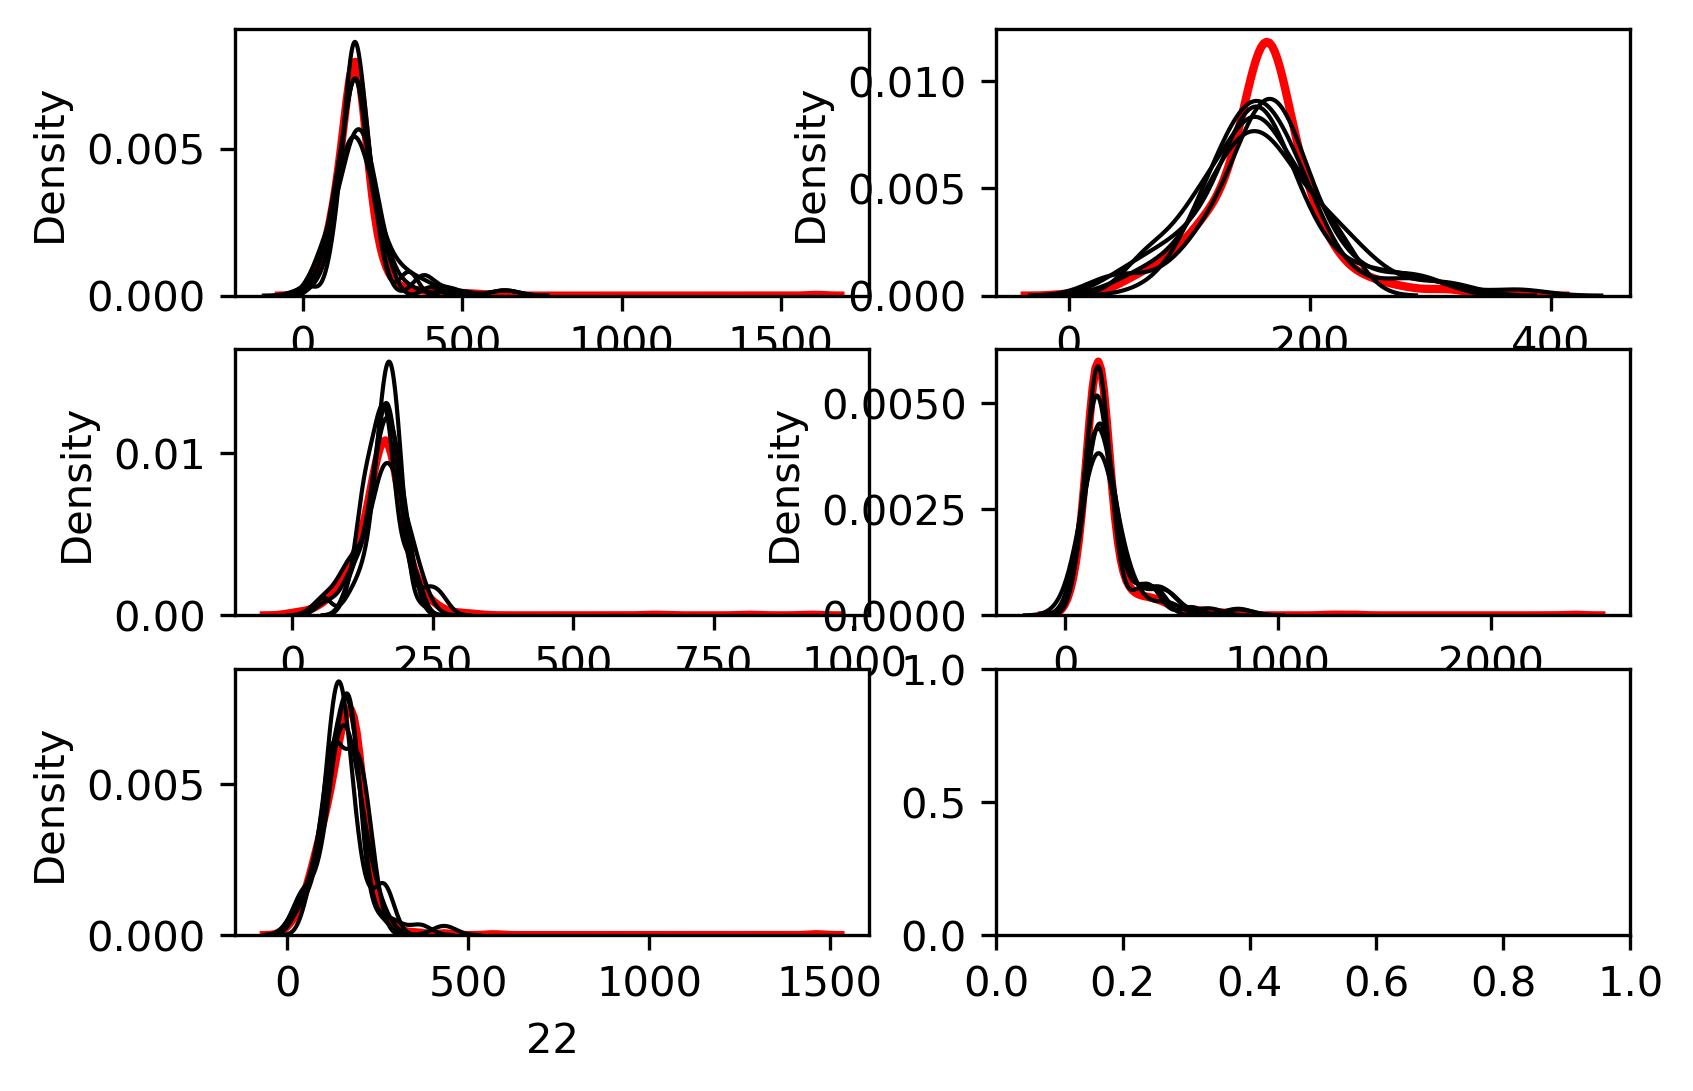

In [137]:
#Red line is original data and black line is the imputed values of the dataset
kernel_3m_wt.plot_imputed_distributions()

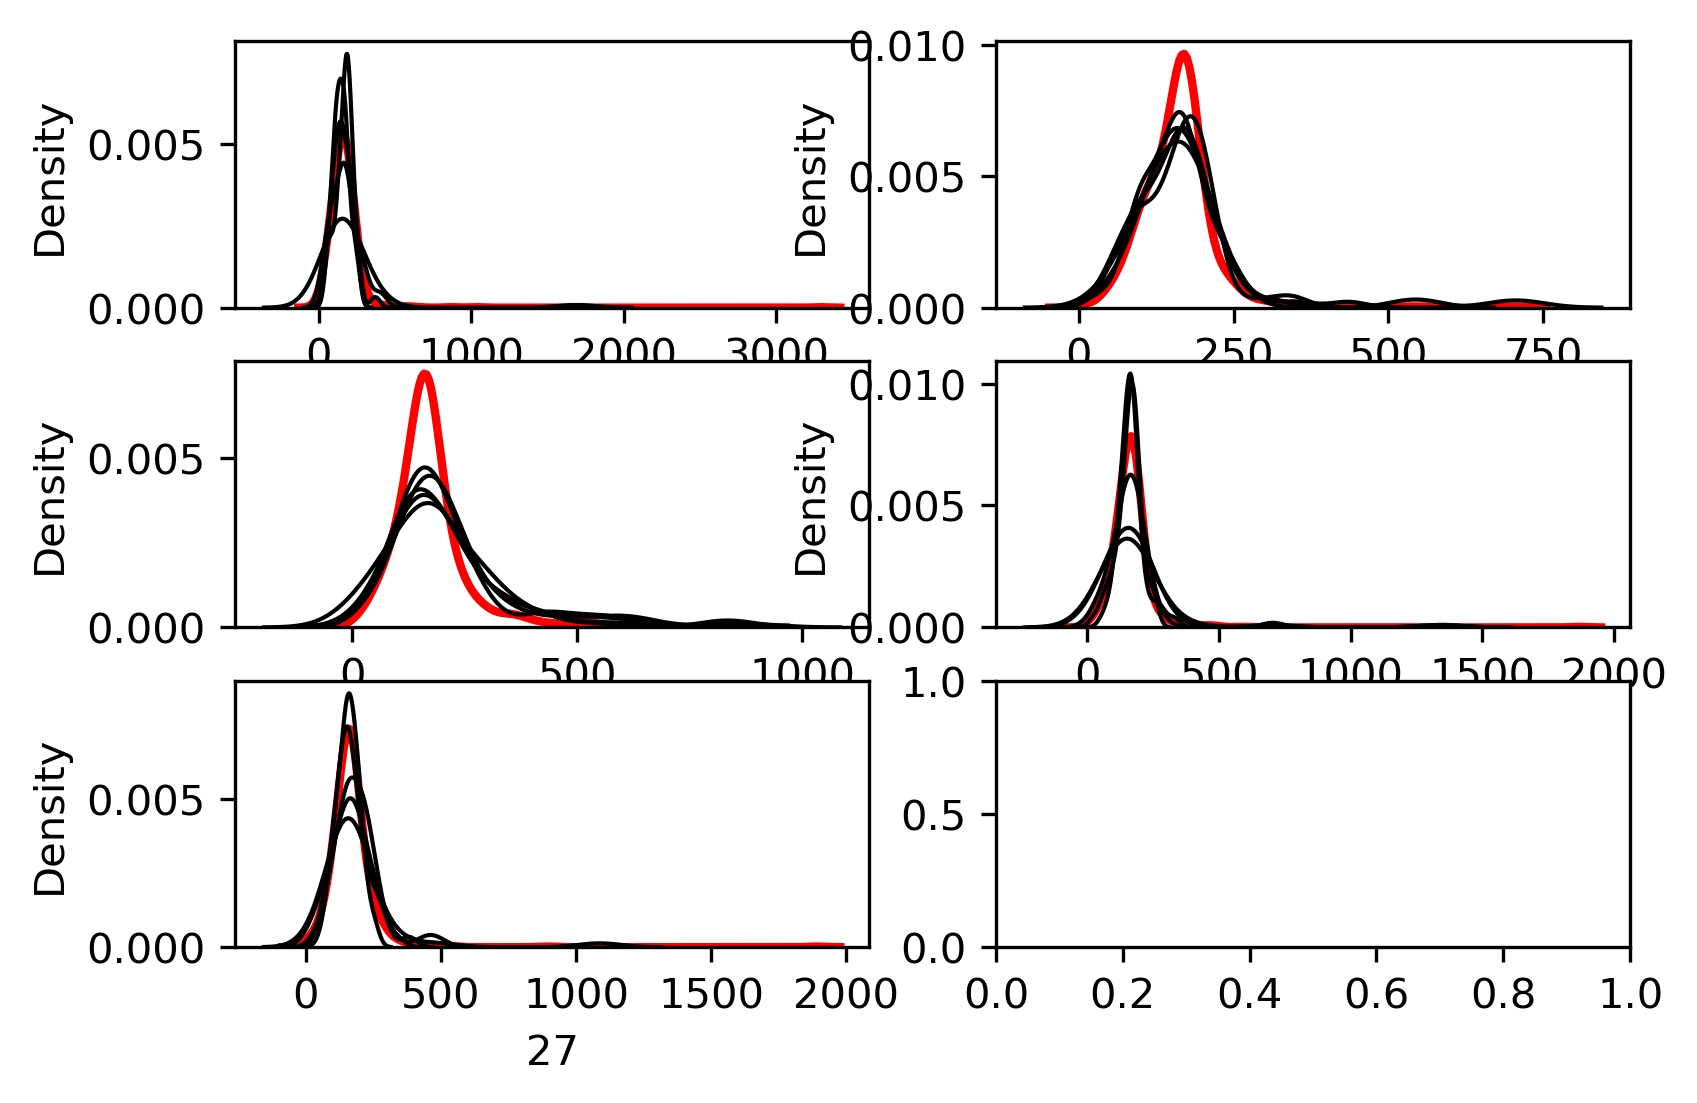

In [138]:
#Red line is original data and black line is the imputed values of the dataset
kernel_3m_appki.plot_imputed_distributions()

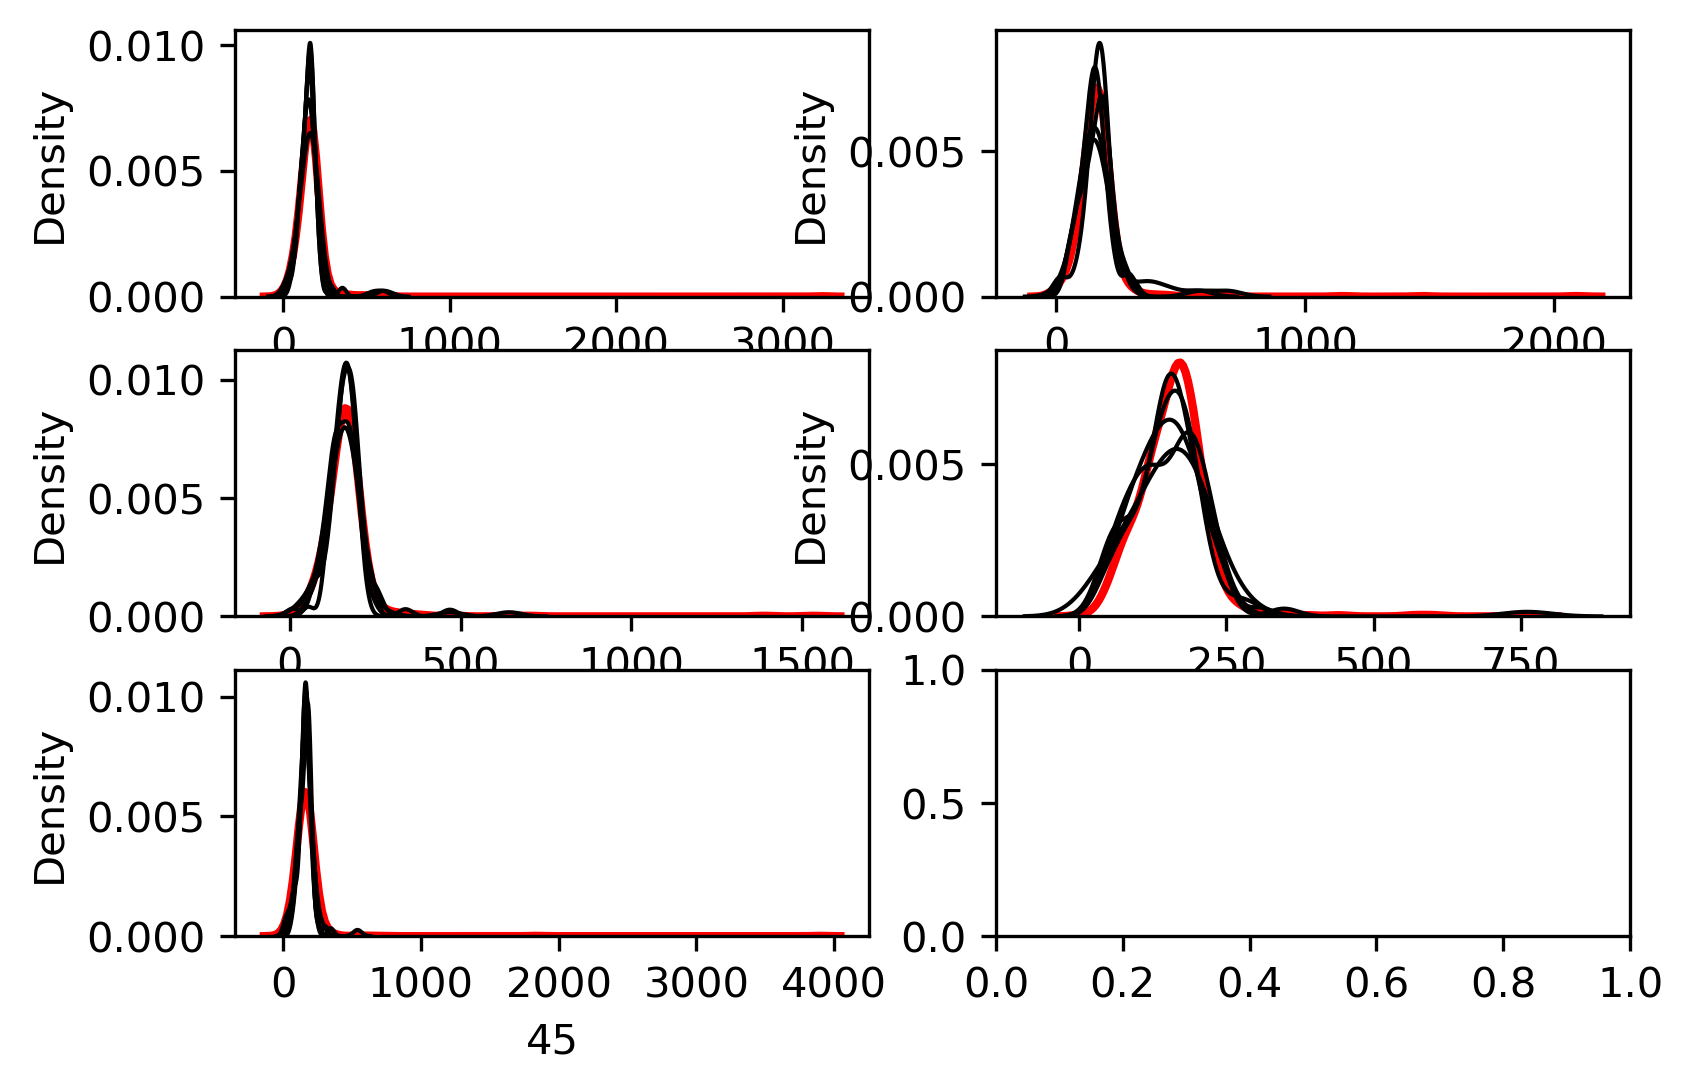

In [139]:
#Red line is original data and black line is the imputed values of the dataset
kernel_6m_wt.plot_imputed_distributions()

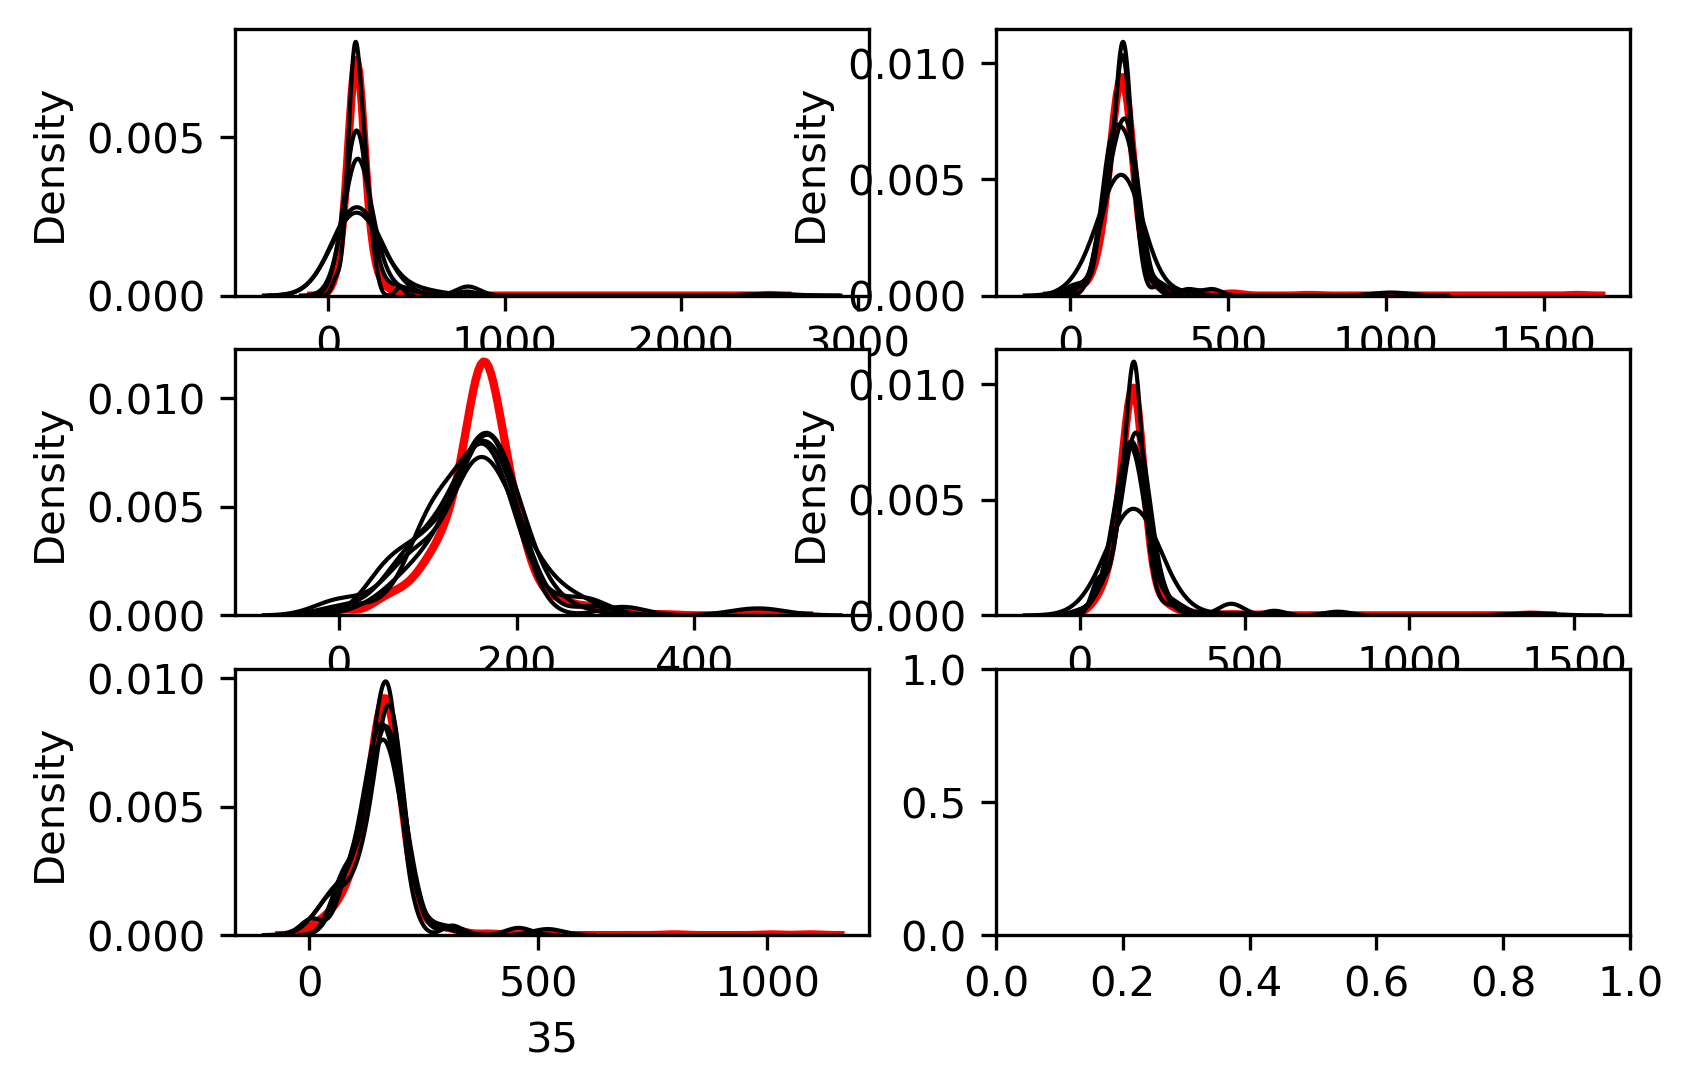

In [140]:
#Red line is original data and black line is the imputed values of the dataset
kernel_6m_appki.plot_imputed_distributions()

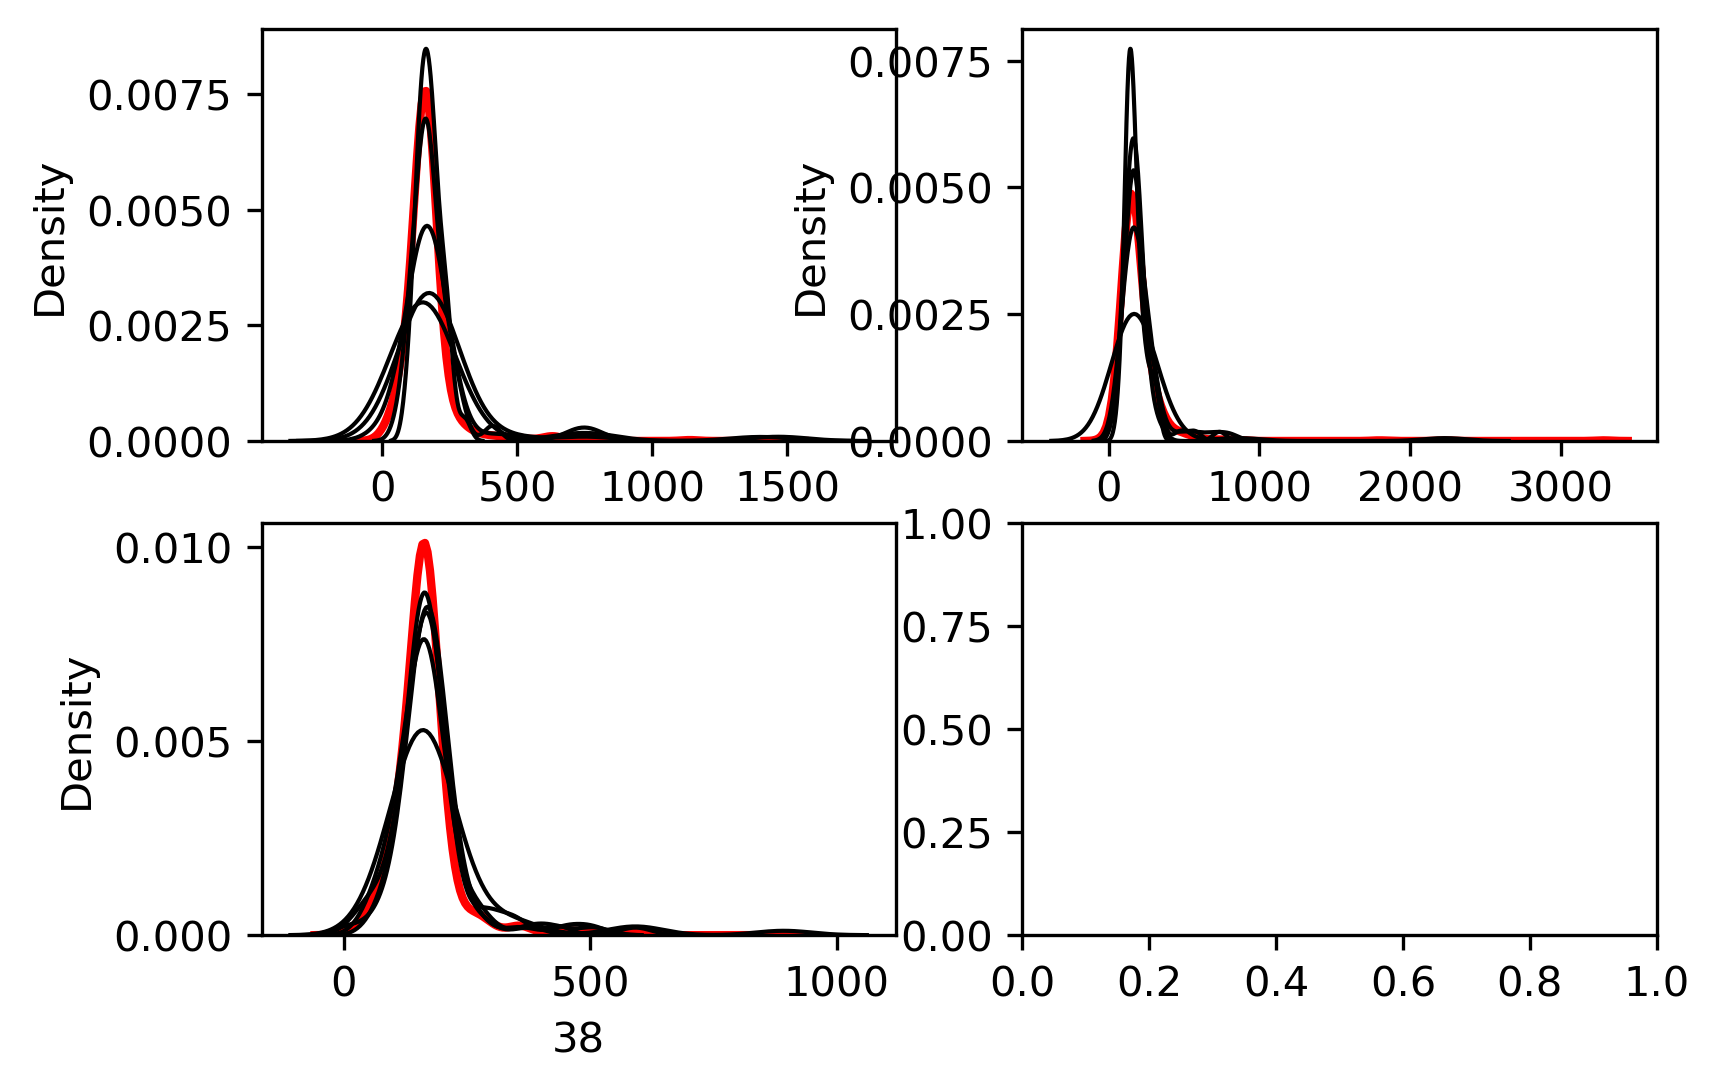

In [141]:
#Red line is original data and black line is the imputed values of the dataset
kernel_12m_wt.plot_imputed_distributions()

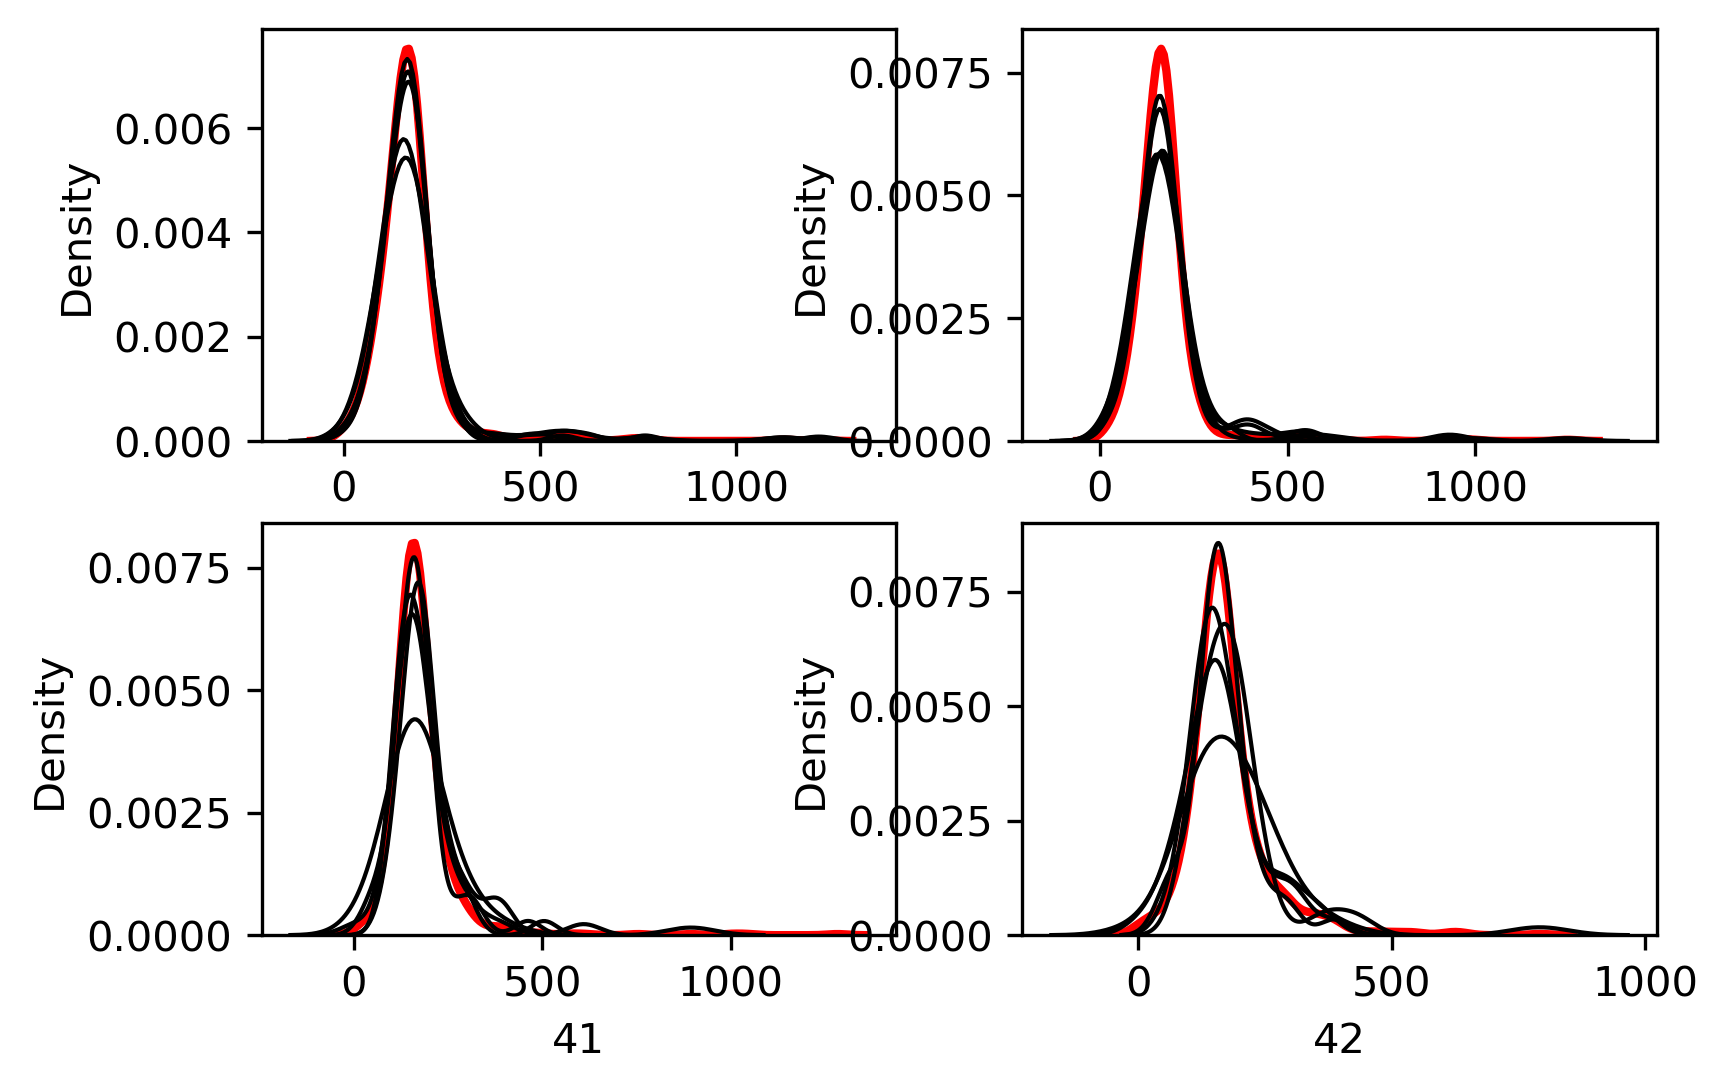

In [142]:
#Red line is original data and black line is the imputed values of the dataset
kernel_12m_appki.plot_imputed_distributions()

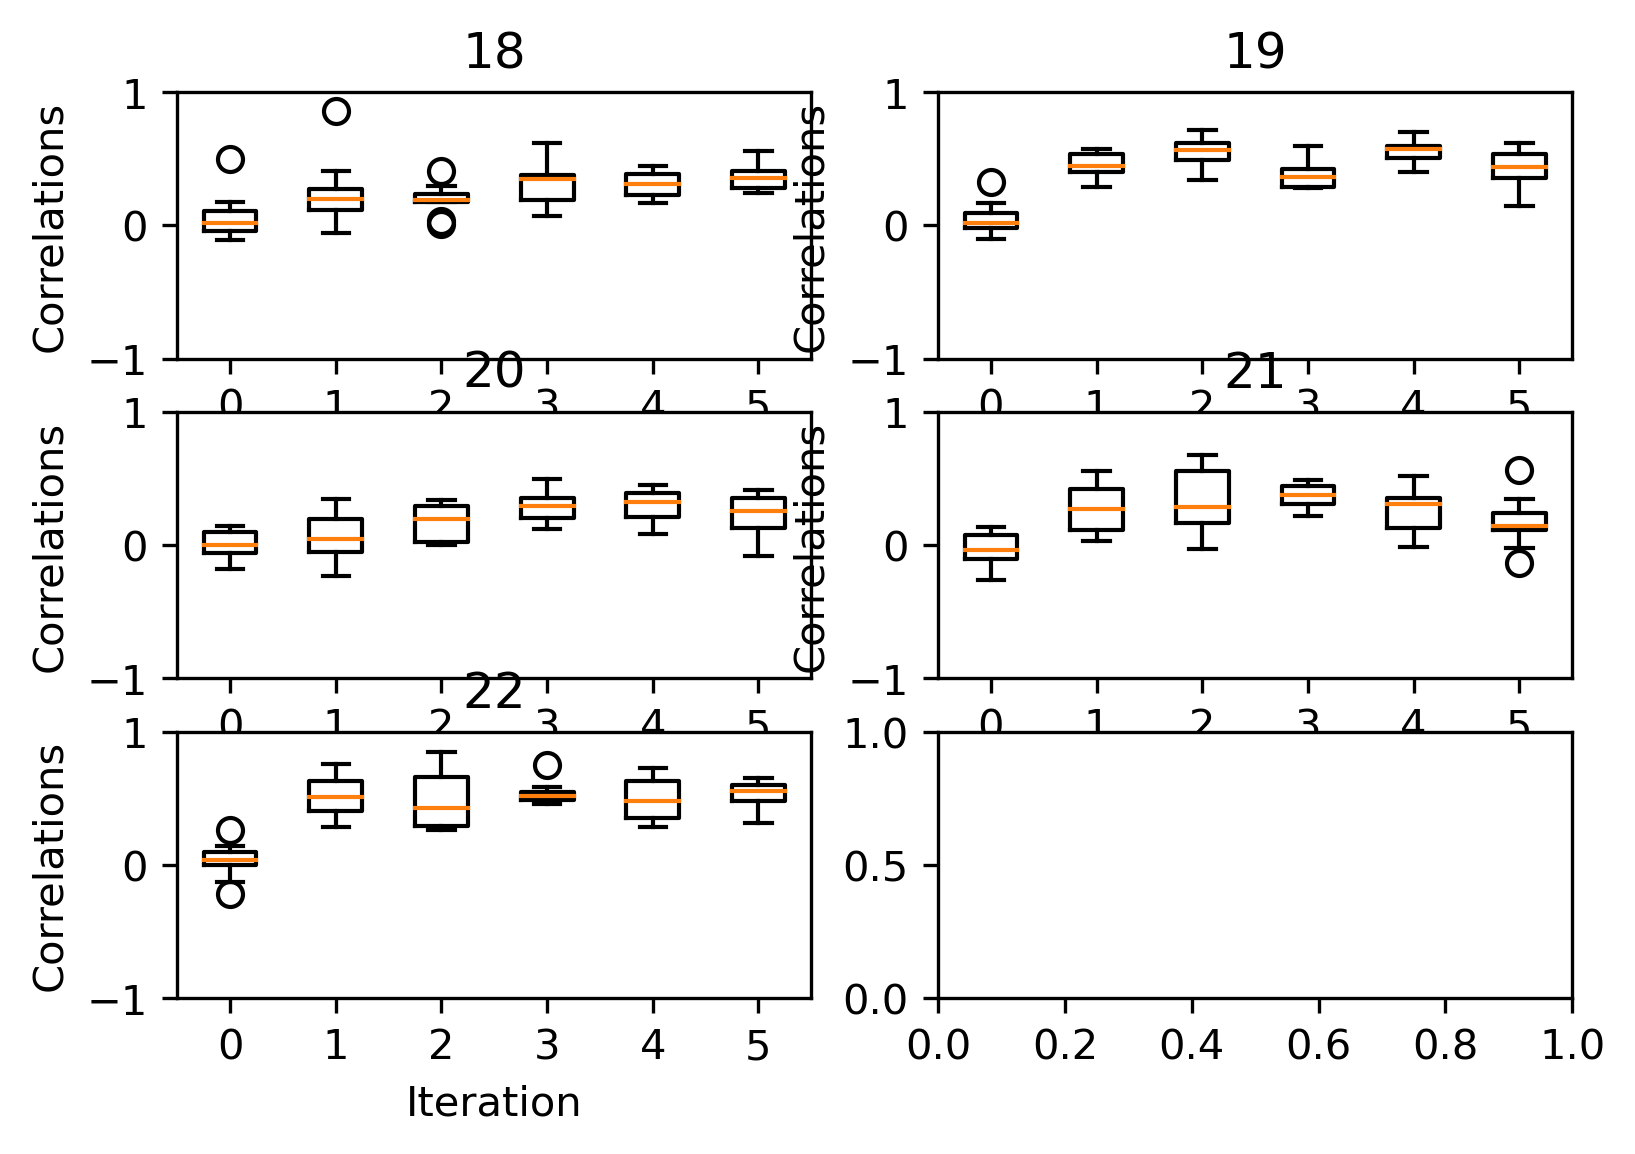

In [143]:
#We are probably interested in knowing how our values between datasets converged over the iterations. The plot_correlations method shows you a boxplot of the correlations between imputed values in every combination of datasets, at each iteration. This allows you to see how correlated the imputations are between datasets, as well as the convergence over iterations:
kernel_3m_wt.plot_correlations()

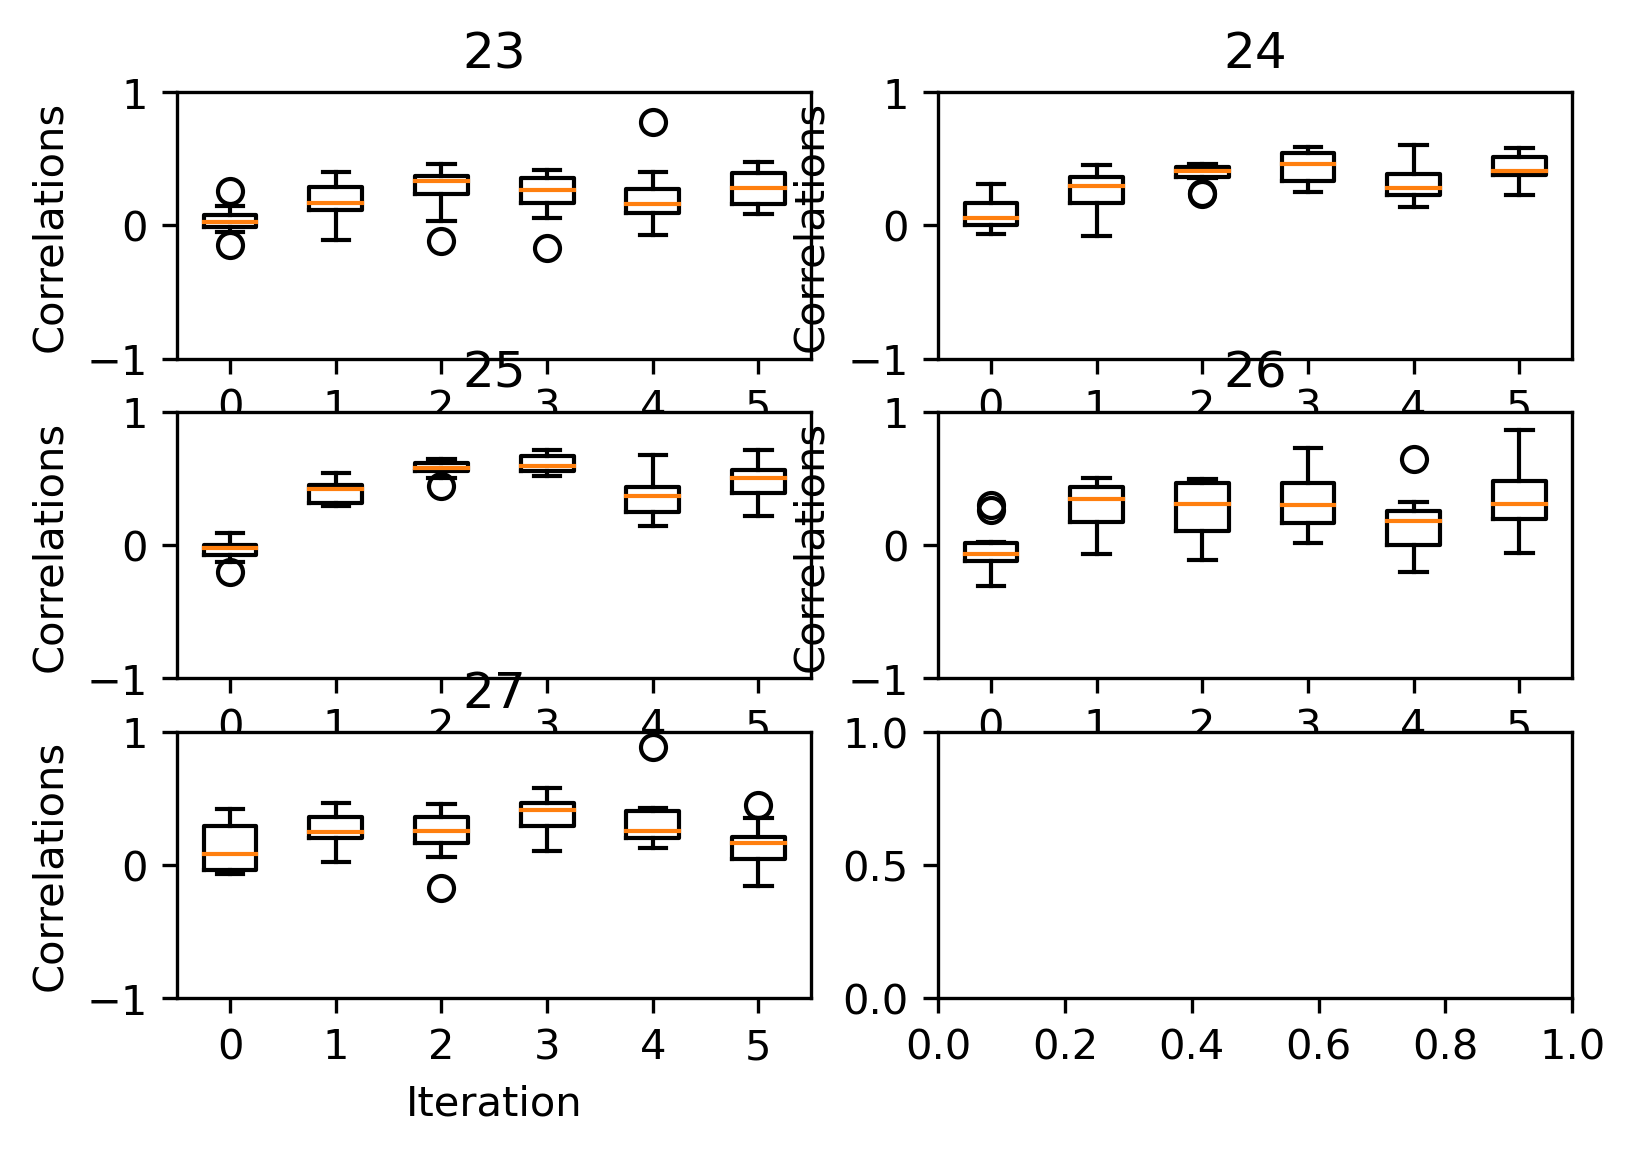

In [144]:
#We are probably interested in knowing how our values between datasets converged over the iterations. The plot_correlations method shows you a boxplot of the correlations between imputed values in every combination of datasets, at each iteration. This allows you to see how correlated the imputations are between datasets, as well as the convergence over iterations:
kernel_3m_appki.plot_correlations()

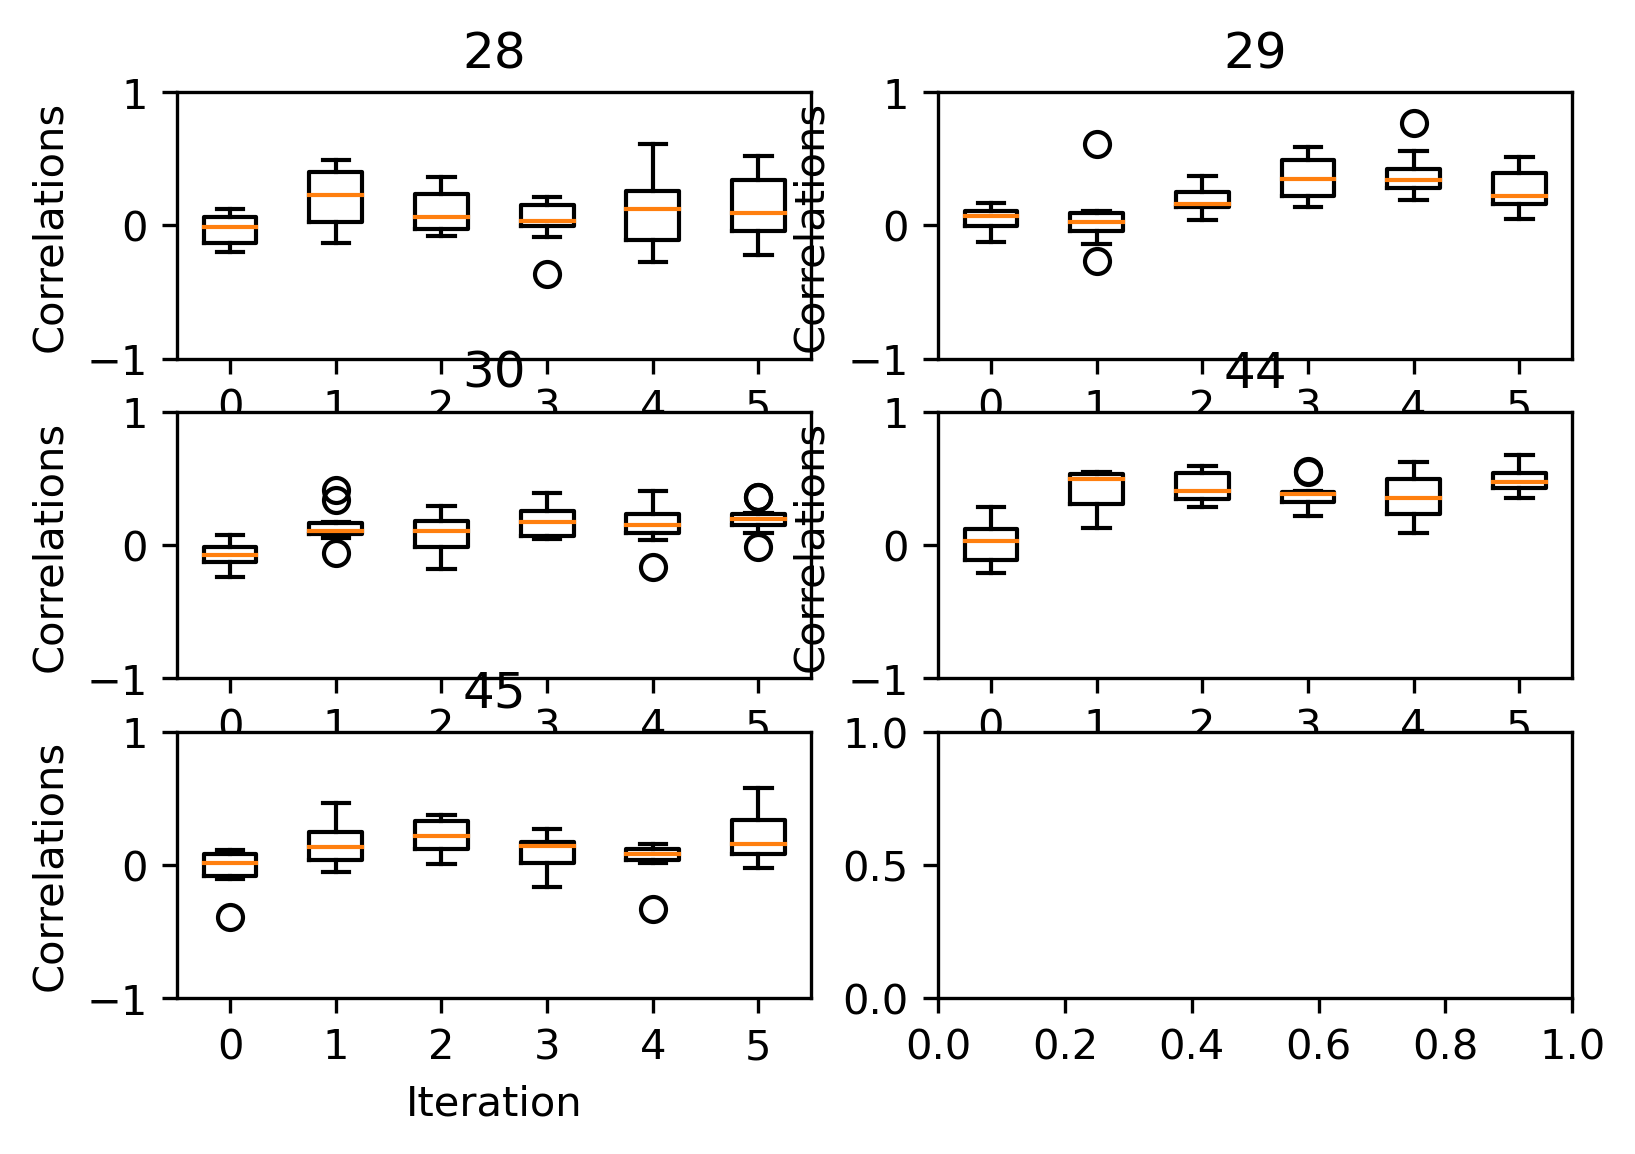

In [145]:
#We are probably interested in knowing how our values between datasets converged over the iterations. The plot_correlations method shows you a boxplot of the correlations between imputed values in every combination of datasets, at each iteration. This allows you to see how correlated the imputations are between datasets, as well as the convergence over iterations:
kernel_6m_wt.plot_correlations()

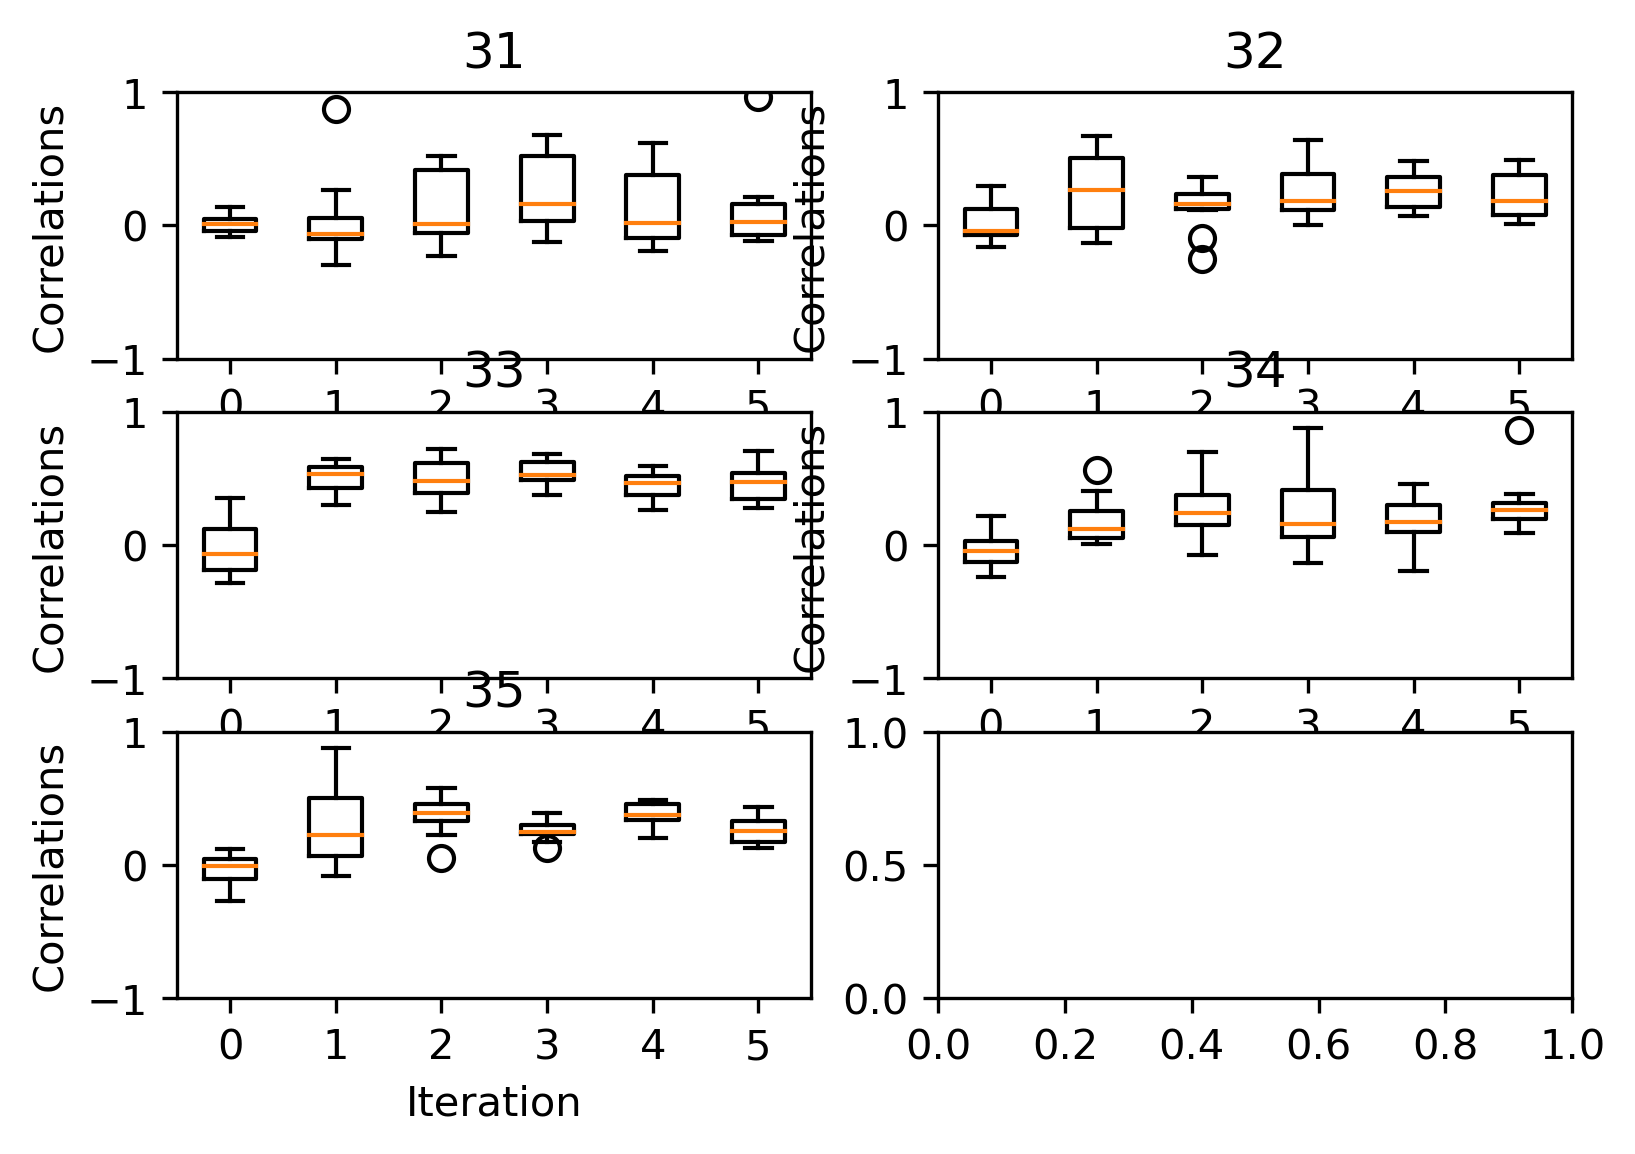

In [146]:
#We are probably interested in knowing how our values between datasets converged over the iterations. The plot_correlations method shows you a boxplot of the correlations between imputed values in every combination of datasets, at each iteration. This allows you to see how correlated the imputations are between datasets, as well as the convergence over iterations:
kernel_6m_appki.plot_correlations()

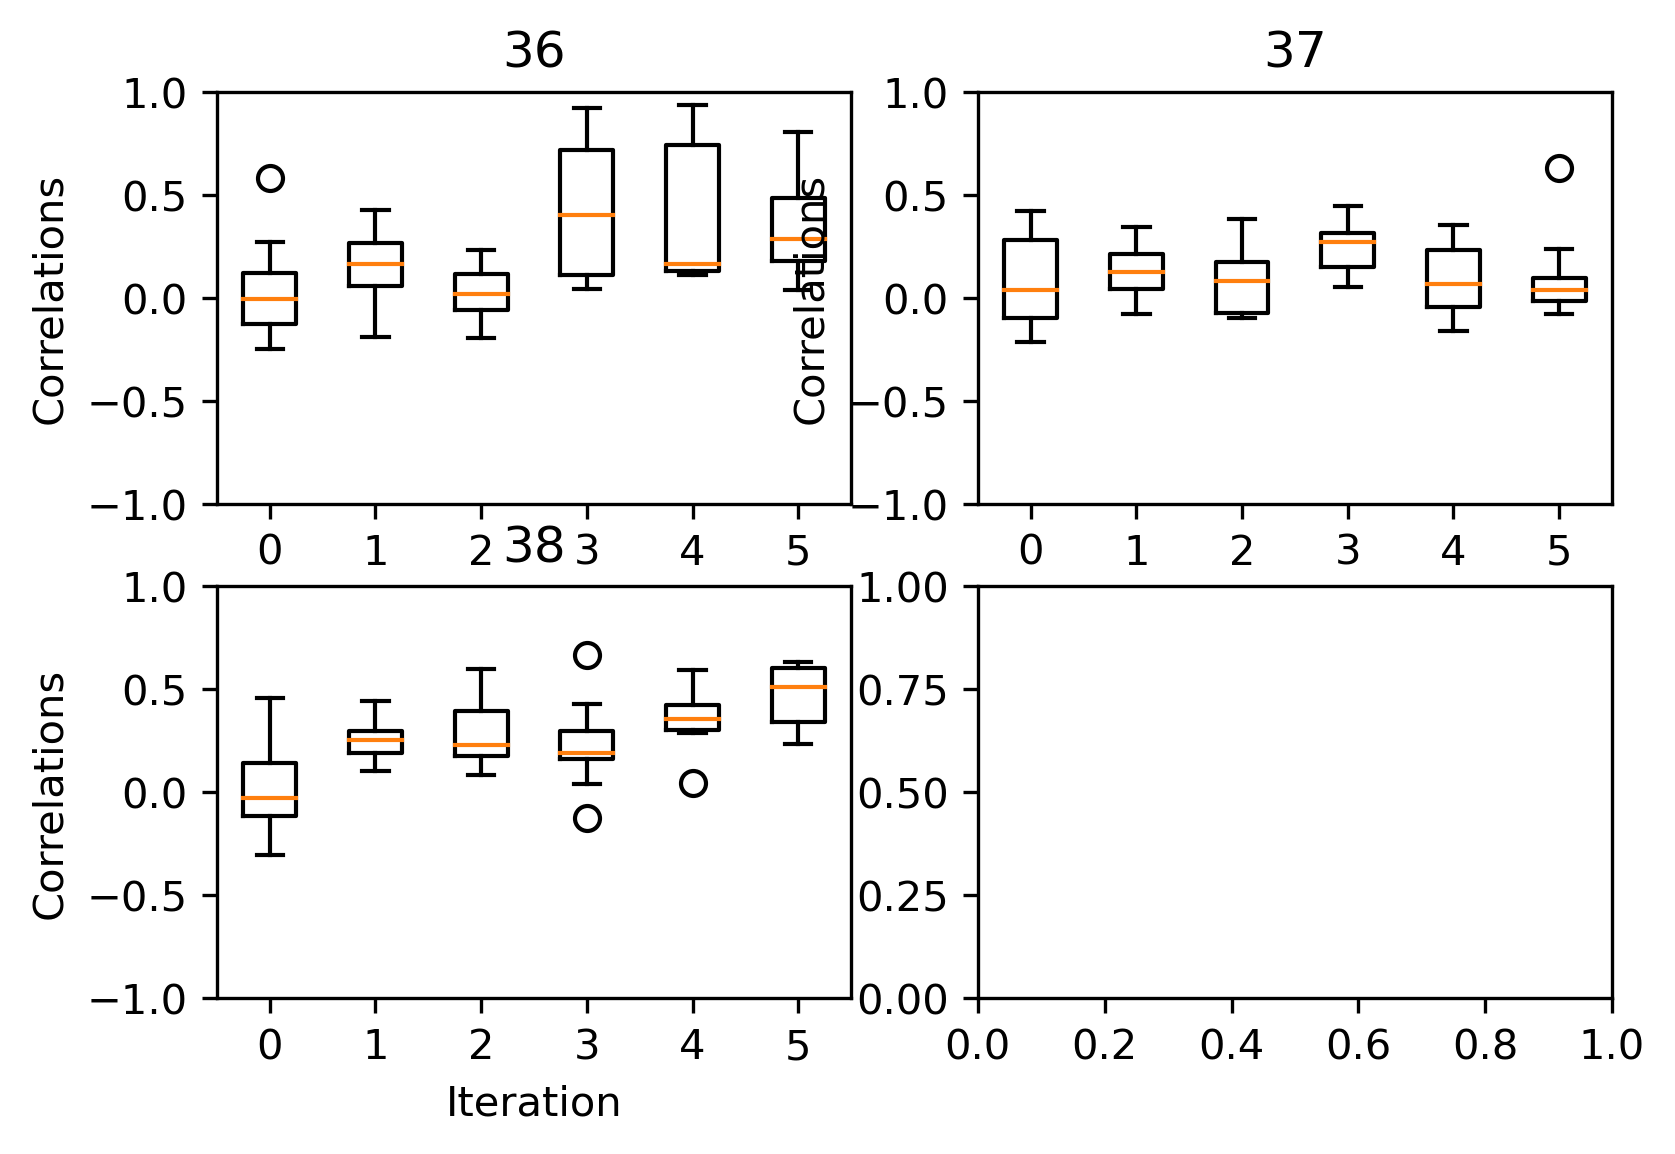

In [147]:
#We are probably interested in knowing how our values between datasets converged over the iterations. The plot_correlations method shows you a boxplot of the correlations between imputed values in every combination of datasets, at each iteration. This allows you to see how correlated the imputations are between datasets, as well as the convergence over iterations:
kernel_12m_wt.plot_correlations()

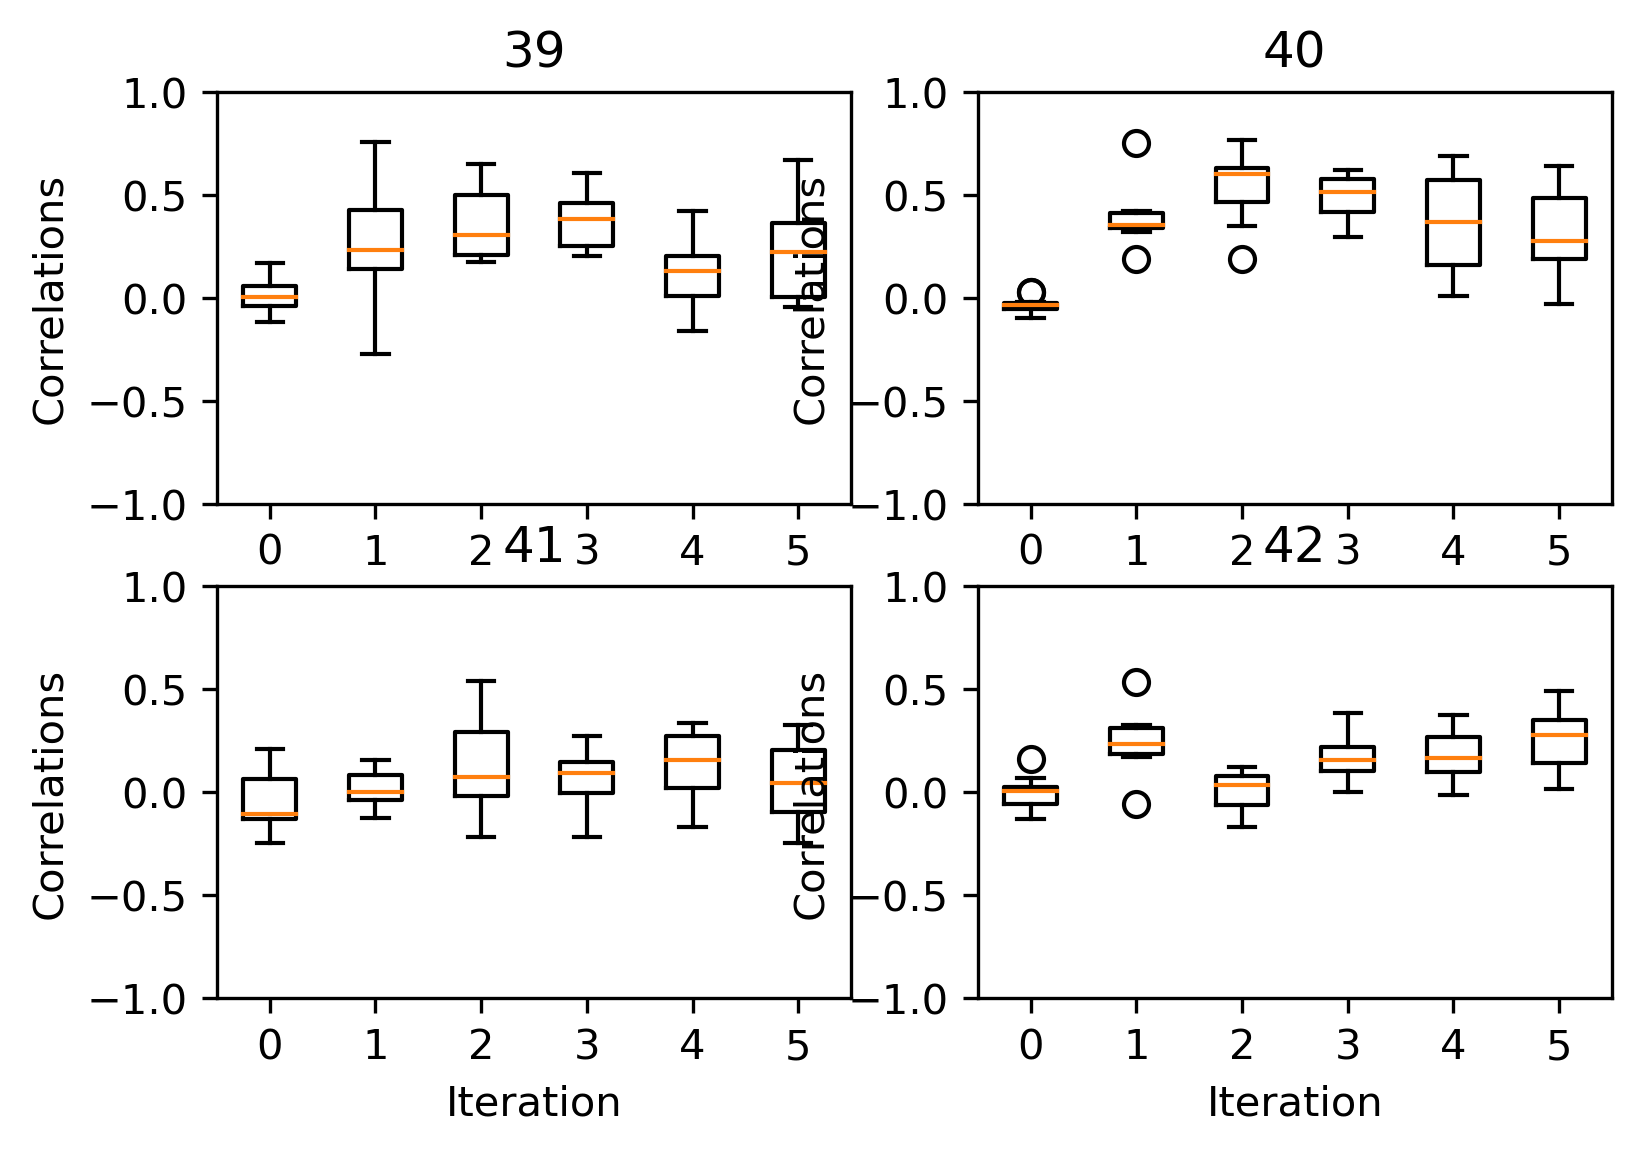

In [148]:
#We are probably interested in knowing how our values between datasets converged over the iterations. The plot_correlations method shows you a boxplot of the correlations between imputed values in every combination of datasets, at each iteration. This allows you to see how correlated the imputations are between datasets, as well as the convergence over iterations:
kernel_12m_appki.plot_correlations()

AxesSubplot(0.125,0.125;0.62x0.755)


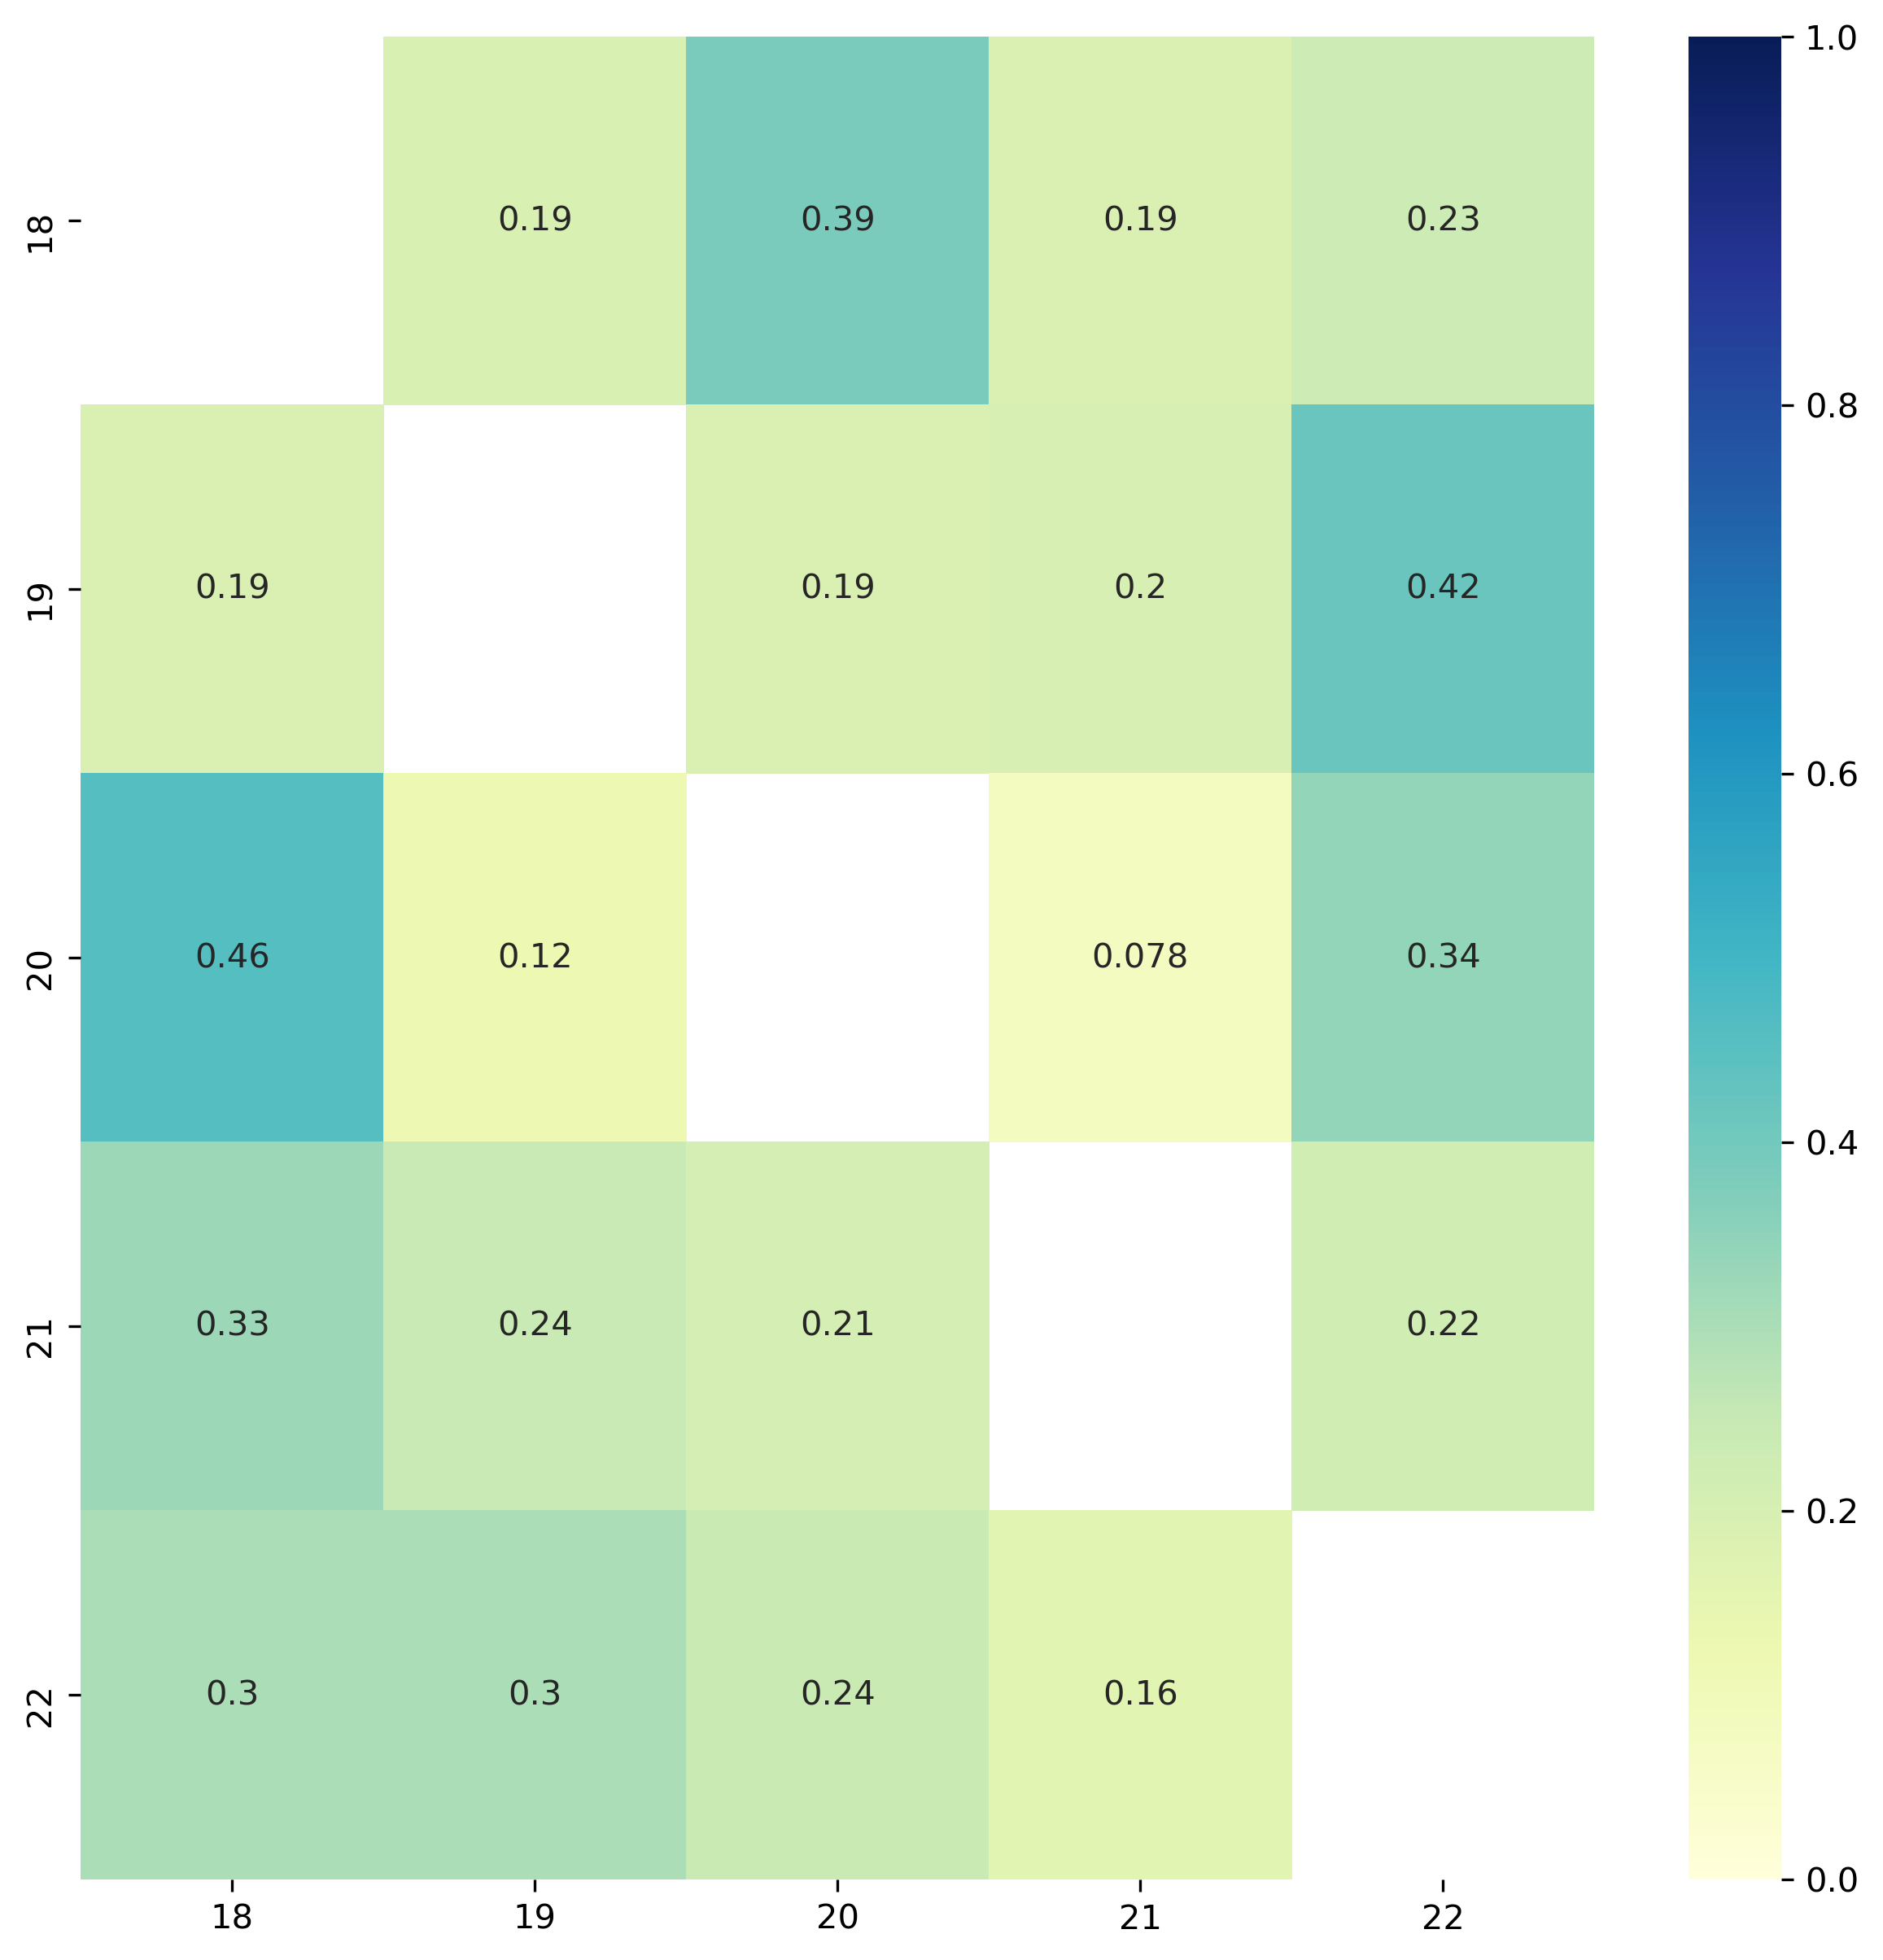

In [149]:
#The numbers shown are returned from the sklearn random forest _feature_importance attribute. Each square represents the importance of the column variable in imputing the row variable.
plt.figure(figsize=(10, 10))
kernel_3m_wt.plot_feature_importance(annot=True,cmap="YlGnBu",vmin=0, vmax=1)
plt.show()

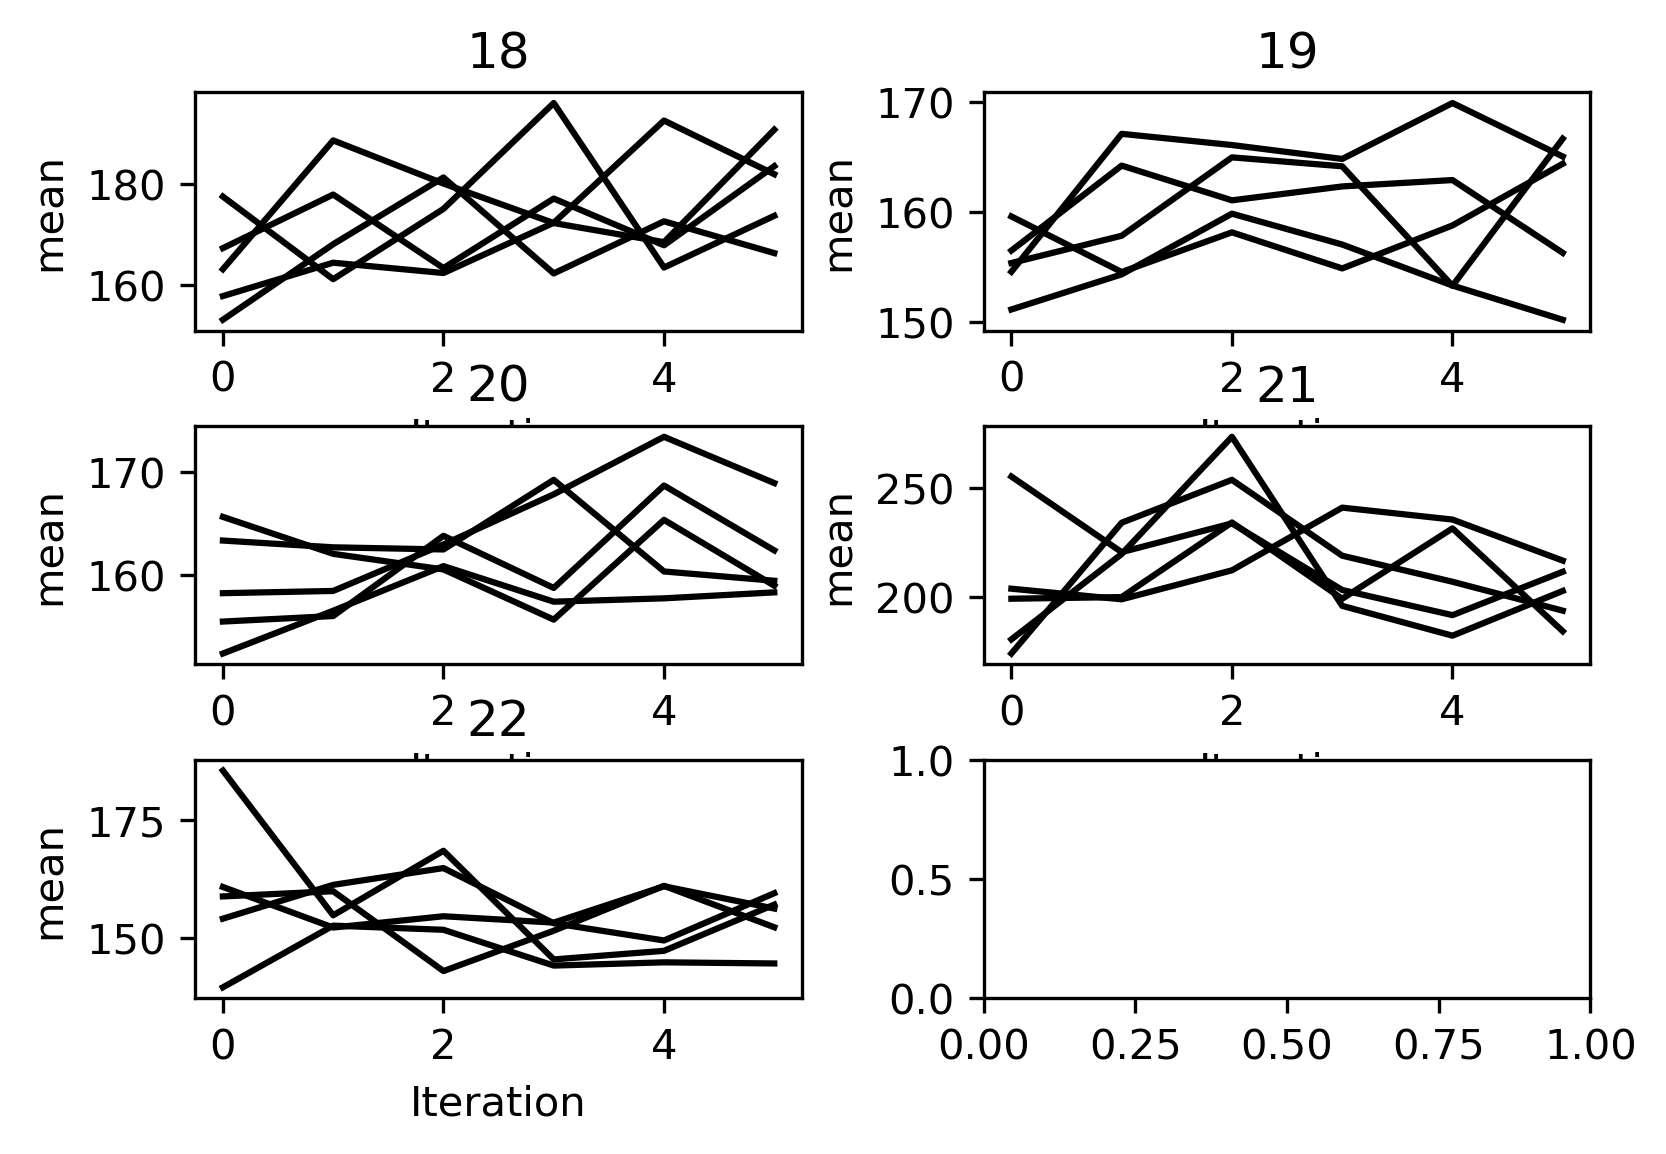

In [150]:
kernel_3m_wt.plot_mean_convergence(wspace=0.3, hspace=0.4)

In [151]:
#Output kernels to dataframe
df_imputed_3m_wt = kernel_3m_wt.complete_data(0)
df_imputed_6m_wt = kernel_6m_wt.complete_data(0)
df_imputed_12m_wt = kernel_12m_wt.complete_data(0)
df_imputed_3m_appki = kernel_3m_appki.complete_data(0)
df_imputed_6m_appki = kernel_6m_appki.complete_data(0)
df_imputed_12m_appki = kernel_12m_appki.complete_data(0)

#check on last one
df_imputed_12m_appki

39          40          41          42
0    106.755853  165.060503  183.975238  178.989838
1    144.908942  127.806684  175.445522  184.328125
2    167.345348  232.885617  192.882902  222.853993
3     85.443715   68.601525  220.775422  187.671429
4    538.093320  442.695287  209.578596   72.117660
..          ...         ...         ...         ...
711  150.447283  111.263676   35.878917   28.146328
712  175.746491  164.715267  155.537306  158.183398
713    6.865450  162.181186  185.696159  163.655865
714  208.815769  173.271209  200.873111  170.894231
715  177.133733  145.322523   98.248433   96.298909

[716 rows x 4 columns]

In [152]:
#merge with appropriate protein list
df_imputed_3m_wtx = df_imputed_3m_wt.join(df_3m_wt_proteins)
df_imputed_6m_wtx = df_imputed_6m_wt.join(df_6m_wt_proteins)
df_imputed_12m_wtx = df_imputed_12m_wt.join(df_12m_wt_proteins)
df_imputed_3m_appkix = df_imputed_3m_appki.join(df_3m_appki_proteins)
df_imputed_6m_appkix = df_imputed_6m_appki.join(df_6m_appki_proteins)
df_imputed_12m_appkix = df_imputed_12m_appki.join(df_12m_appki_proteins)

#check on the last one
df_imputed_12m_appkix

39          40          41          42 Master Protein
0    106.755853  165.060503  183.975238  178.989838     A0A075B5K0
1    144.908942  127.806684  175.445522  184.328125     A0A075B5K2
2    167.345348  232.885617  192.882902  222.853993     A0A075B5K6
3     85.443715   68.601525  220.775422  187.671429     A0A075B5L1
4    538.093320  442.695287  209.578596   72.117660     A0A075B5L3
..          ...         ...         ...         ...            ...
711  150.447283  111.263676   35.878917   28.146328         Q9Z2K1
712  175.746491  164.715267  155.537306  158.183398         Q9Z2L6
713    6.865450  162.181186  185.696159  163.655865         Q9Z2U0
714  208.815769  173.271209  200.873111  170.894231         Q9Z2U1
715  177.133733  145.322523   98.248433   96.298909         Q9Z331

[716 rows x 5 columns]

In [153]:
df_imputed_3m_wtx = df_imputed_3m_wtx.set_index('Master Protein')
df_imputed_6m_wtx = df_imputed_6m_wtx.set_index('Master Protein')
df_imputed_12m_wtx = df_imputed_12m_wtx.set_index('Master Protein')
df_imputed_3m_appkix = df_imputed_3m_appkix.set_index('Master Protein')
df_imputed_6m_appkix = df_imputed_6m_appkix.set_index('Master Protein')
df_imputed_12m_appkix = df_imputed_12m_appkix.set_index('Master Protein')


In [154]:
#Check on the last one
df_imputed_12m_appkix

39          40          41          42
Master Protein                                                
A0A075B5K0      106.755853  165.060503  183.975238  178.989838
A0A075B5K2      144.908942  127.806684  175.445522  184.328125
A0A075B5K6      167.345348  232.885617  192.882902  222.853993
A0A075B5L1       85.443715   68.601525  220.775422  187.671429
A0A075B5L3      538.093320  442.695287  209.578596   72.117660
...                    ...         ...         ...         ...
Q9Z2K1          150.447283  111.263676   35.878917   28.146328
Q9Z2L6          175.746491  164.715267  155.537306  158.183398
Q9Z2U0            6.865450  162.181186  185.696159  163.655865
Q9Z2U1          208.815769  173.271209  200.873111  170.894231
Q9Z331          177.133733  145.322523   98.248433   96.298909

[716 rows x 4 columns]

In [155]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
df_imputed_3m_wtxx = pd.merge(df_imputed_3m_wtx, proteinlist, left_index=True, right_index=True)
df_imputed_6m_wtxx = pd.merge(df_imputed_6m_wtx, proteinlist, left_index=True, right_index=True)
df_imputed_12m_wtxx = pd.merge(df_imputed_12m_wtx, proteinlist, left_index=True, right_index=True)
df_imputed_3m_appkixx = pd.merge(df_imputed_3m_appkix, proteinlist, left_index=True, right_index=True)
df_imputed_6m_appkixx = pd.merge(df_imputed_6m_appkix, proteinlist, left_index=True, right_index=True)
df_imputed_12m_appkixx = pd.merge(df_imputed_12m_appkix, proteinlist, left_index=True, right_index=True)

#check on the last one
df_imputed_12m_appkixx

39          40          41          42     Protein
Master Protein                                                            
A0A075B5K0      106.755853  165.060503  183.975238  178.989838  Igkv14-126
A0A075B5K2      144.908942  127.806684  175.445522  184.328125   Igkv9-124
A0A075B5K6      167.345348  232.885617  192.882902  222.853993   Igkv2-109
A0A075B5L1       85.443715   68.601525  220.775422  187.671429   Igkv10-94
A0A075B5L3      538.093320  442.695287  209.578596   72.117660    Igkv4-90
...                    ...         ...         ...         ...         ...
Q9Z2K1          150.447283  111.263676   35.878917   28.146328       Krt16
Q9Z2L6          175.746491  164.715267  155.537306  158.183398      Minpp1
Q9Z2U0            6.865450  162.181186  185.696159  163.655865       Psma7
Q9Z2U1          208.815769  173.271209  200.873111  170.894231       Psma5
Q9Z331          177.133733  145.322523   98.248433   96.298909       Krt6b

[716 rows x 5 columns]

In [156]:
#Export dataframes to csv with index - 
df_imputed_3m_wtxx.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/3m__wt_imputed.csv')
df_imputed_6m_wtxx.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/6m_wt_imputed.csv')
df_imputed_12m_wtxx.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/12m_wt_imputed.csv')
df_imputed_3m_appkixx.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/3m_appki_imputed.csv')
df_imputed_6m_appkixx.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/6m_appki_imputed.csv')
df_imputed_12m_appkixx.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/12m_appki_imputed.csv')


In [157]:
#Merge the age groups together
df_imputed_3m_merge = pd.merge(df_imputed_3m_wtx, df_imputed_3m_appkix, left_index=True, right_index=True)
df_imputed_6m_merge = pd.merge(df_imputed_6m_wtx, df_imputed_6m_appkix, left_index=True, right_index=True)
df_imputed_12m_merge = pd.merge(df_imputed_12m_wtx, df_imputed_12m_appkix, left_index=True, right_index=True)

#check on the last one
df_imputed_12m_merge

36          37          38          39          40  \
Master Protein                                                               
A0A075B5K0      255.299453  165.889178  174.591700  106.755853  165.060503   
A0A075B5K2      164.596444  128.407653  138.197279  144.908942  127.806684   
A0A075B5K6      194.076338  212.844239  186.851484  167.345348  232.885617   
A0A075B5L1      130.937027  184.181088   55.902964   85.443715   68.601525   
A0A075B5L7      194.747347  254.196834  268.380670  263.927520  163.402668   
...                    ...         ...         ...         ...         ...   
Q9Z2K1           50.430442  209.770156  152.972834  150.447283  111.263676   
Q9Z2L6          136.640537  134.070246  151.010837  175.746491  164.715267   
Q9Z2U0          167.694086    6.260730  170.116475    6.865450  162.181186   
Q9Z2U1          163.303275  329.591862  174.902283  208.815769  173.271209   
Q9Z331          176.837155  197.175741  171.157844  177.133733  145.322523   

                        41          42  
Master Protein                          
A0A075B5K0      183.975238  178.989838  
A0A075B5K2      175.445522  184.328125  
A0A075B5K6      192.882902  222.853993  
A0A075B5L1      220.775422  187.671429  
A0A075B5L7      318.955238  275.221970  
...                    ...         ...  
Q9Z2K1           35.878917   28.146328  
Q9Z2L6          155.537306  158.183398  
Q9Z2U0          185.696159  163.655865  
Q9Z2U1          200.873111  170.894231  
Q9Z331           98.248433   96.298909  

[650 rows x 7 columns]

In [158]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
#Merge the age groups together
df_imputed_3m_merge_annot = pd.merge(df_imputed_3m_merge, proteinlist, left_index=True, right_index=True)
df_imputed_6m_merge_annot = pd.merge(df_imputed_6m_merge, proteinlist, left_index=True, right_index=True)
df_imputed_12m_merge_annot = pd.merge(df_imputed_12m_merge, proteinlist, left_index=True, right_index=True)

#check on the last one
df_imputed_12m_merge_annot

36          37          38          39          40  \
Master Protein                                                               
A0A075B5K0      255.299453  165.889178  174.591700  106.755853  165.060503   
A0A075B5K2      164.596444  128.407653  138.197279  144.908942  127.806684   
A0A075B5K6      194.076338  212.844239  186.851484  167.345348  232.885617   
A0A075B5L1      130.937027  184.181088   55.902964   85.443715   68.601525   
A0A075B5L7      194.747347  254.196834  268.380670  263.927520  163.402668   
...                    ...         ...         ...         ...         ...   
Q9Z2K1           50.430442  209.770156  152.972834  150.447283  111.263676   
Q9Z2L6          136.640537  134.070246  151.010837  175.746491  164.715267   
Q9Z2U0          167.694086    6.260730  170.116475    6.865450  162.181186   
Q9Z2U1          163.303275  329.591862  174.902283  208.815769  173.271209   
Q9Z331          176.837155  197.175741  171.157844  177.133733  145.322523   

                        41          42     Protein  
Master Protein                                      
A0A075B5K0      183.975238  178.989838  Igkv14-126  
A0A075B5K2      175.445522  184.328125   Igkv9-124  
A0A075B5K6      192.882902  222.853993   Igkv2-109  
A0A075B5L1      220.775422  187.671429   Igkv10-94  
A0A075B5L7      318.955238  275.221970    Igkv4-80  
...                    ...         ...         ...  
Q9Z2K1           35.878917   28.146328       Krt16  
Q9Z2L6          155.537306  158.183398      Minpp1  
Q9Z2U0          185.696159  163.655865       Psma7  
Q9Z2U1          200.873111  170.894231       Psma5  
Q9Z331           98.248433   96.298909       Krt6b  

[650 rows x 8 columns]

In [159]:
df_imputed_3m_merge_annot.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/3m__merged_imputed.csv')
df_imputed_6m_merge_annot.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/6m_merged_imputed.csv')
df_imputed_12m_merge_annot.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/12m_merged_imputed.csv')


In [160]:
df_imputed_3m_merge.head()

18          19          20          21          22  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L7      103.093031  120.866463  116.232200  167.238277  161.054466   

                        23          24          25          26          27  
Master Protein                                                              
A0A075B5K0      112.903267  122.270686  100.466405  117.205388  124.442726  
A0A075B5K2      178.041912   91.110384   69.319974  108.579084  135.333896  
A0A075B5K6      109.799638   90.643023  112.410310  249.768354  109.195173  
A0A075B5L1       91.270391  141.061164  168.980525  127.445550  123.452601  
A0A075B5L7      187.762499  154.143959  130.304196   92.757273  156.880173

In [161]:
#rename columns
df_imputed_3m_merge.columns = ['3mwt', '3mwt', '3mwt', '3mwt', '3mwt', '3mappki', '3mappki', '3mappki', '3mappki', '3mappki']
df_imputed_3m_merge

3mwt        3mwt        3mwt        3mwt        3mwt  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L7      103.093031  120.866463  116.232200  167.238277  161.054466   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          283.616464  155.662106  199.804524  202.776510   58.515460   
Q9Z2L6          190.181268  141.424181  167.683747  147.438329  248.637140   
Q9Z2U0            6.917337  172.130514    6.868211  139.866469  145.515410   
Q9Z2U1          189.551177  108.888944  170.633984  182.236912  202.094764   
Q9Z331          156.314343  169.650364  154.349944  152.792781  206.878537   

                   3mappki     3mappki     3mappki     3mappki     3mappki  
Master Protein                                                              
A0A075B5K0      112.903267  122.270686  100.466405  117.205388  124.442726  
A0A075B5K2      178.041912   91.110384   69.319974  108.579084  135.333896  
A0A075B5K6      109.799638   90.643023  112.410310  249.768354  109.195173  
A0A075B5L1       91.270391  141.061164  168.980525  127.445550  123.452601  
A0A075B5L7      187.762499  154.143959  130.304196   92.757273  156.880173  
...                    ...         ...         ...         ...         ...  
Q9Z2K1           37.291501  197.816836  154.255451  140.919226   42.667970  
Q9Z2L6          271.086037  173.694392  175.017280  179.767682  318.155723  
Q9Z2U0          139.080826  177.535300  180.361788   97.345615  165.341787  
Q9Z2U1          162.145436  174.001283  161.496914  207.640724  176.435919  
Q9Z331          139.153517  176.971732  223.481676  175.209991  154.232965  

[650 rows x 10 columns]

In [162]:
df_imputed_6m_merge.head()

28          29          30          44          45  \
Master Protein                                                               
A0A075B5K0      145.480659  364.338575  220.022180  147.155775  125.067905   
A0A075B5K2      623.938263  314.600469  129.281858  131.335315  167.574906   
A0A075B5K6      209.266748  250.808397  126.690255  143.479821  179.631220   
A0A075B5L1      146.685839  134.925285  395.870746  133.953459  109.271285   
A0A075B5L7      195.988948  151.285490  109.458838  175.823435  245.506064   

                        31          32          33          34          35  
Master Protein                                                              
A0A075B5K0      500.675708   89.358151  138.240201  127.934449  221.879408  
A0A075B5K2      197.801262  238.123864  231.303910  170.392253  217.500829  
A0A075B5K6      107.835970  260.021452  156.952938  196.214906  224.137667  
A0A075B5L1      122.252164  341.174691  319.192166   96.172195  145.560006  
A0A075B5L7      147.373215  202.044680  198.986925  187.362298  300.806980

In [163]:
#rename columns
df_imputed_6m_merge.columns = ['6mwt', '6mwt', '6mwt', '6mwt', '6mwt', '6mappki', '6mappki', '6mappki', '6mappki', '6mappki']
df_imputed_6m_merge

6mwt        6mwt        6mwt        6mwt        6mwt  \
Master Protein                                                               
A0A075B5K0      145.480659  364.338575  220.022180  147.155775  125.067905   
A0A075B5K2      623.938263  314.600469  129.281858  131.335315  167.574906   
A0A075B5K6      209.266748  250.808397  126.690255  143.479821  179.631220   
A0A075B5L1      146.685839  134.925285  395.870746  133.953459  109.271285   
A0A075B5L7      195.988948  151.285490  109.458838  175.823435  245.506064   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          111.078350   39.521323  132.195046  162.562763  185.461749   
Q9Z2L6          164.744994  155.716268  173.758950  155.566052  160.936568   
Q9Z2U0          160.181635  160.394209  170.523353  140.511273  196.028327   
Q9Z2U1          205.523658  171.357107  185.248272  154.594436  202.286134   
Q9Z331          190.298999  129.467575  203.751133  140.348948  190.262577   

                   6mappki     6mappki     6mappki     6mappki     6mappki  
Master Protein                                                              
A0A075B5K0      500.675708   89.358151  138.240201  127.934449  221.879408  
A0A075B5K2      197.801262  238.123864  231.303910  170.392253  217.500829  
A0A075B5K6      107.835970  260.021452  156.952938  196.214906  224.137667  
A0A075B5L1      122.252164  341.174691  319.192166   96.172195  145.560006  
A0A075B5L7      147.373215  202.044680  198.986925  187.362298  300.806980  
...                    ...         ...         ...         ...         ...  
Q9Z2K1          183.046955  221.929702   43.979228  265.676715   81.688972  
Q9Z2L6          136.422662  141.580308  215.214448  149.546141  179.392235  
Q9Z2U0          254.057414  130.485711  192.965840  172.838089    6.933033  
Q9Z2U1          149.722246  185.645378  183.637853  173.978568  177.368416  
Q9Z331          267.751889  167.959097  150.697255  210.123956  193.245166  

[650 rows x 10 columns]

In [164]:
df_imputed_12m_merge.head()

36          37          38          39          40  \
Master Protein                                                               
A0A075B5K0      255.299453  165.889178  174.591700  106.755853  165.060503   
A0A075B5K2      164.596444  128.407653  138.197279  144.908942  127.806684   
A0A075B5K6      194.076338  212.844239  186.851484  167.345348  232.885617   
A0A075B5L1      130.937027  184.181088   55.902964   85.443715   68.601525   
A0A075B5L7      194.747347  254.196834  268.380670  263.927520  163.402668   

                        41          42  
Master Protein                          
A0A075B5K0      183.975238  178.989838  
A0A075B5K2      175.445522  184.328125  
A0A075B5K6      192.882902  222.853993  
A0A075B5L1      220.775422  187.671429  
A0A075B5L7      318.955238  275.221970

In [165]:
#rename columns
df_imputed_12m_merge.columns = ['12mwt', '12mwt', '12mwt',  '12mappki', '12mappki', '12mappki', '12mappki']
df_imputed_12m_merge

12mwt       12mwt       12mwt    12mappki    12mappki  \
Master Protein                                                               
A0A075B5K0      255.299453  165.889178  174.591700  106.755853  165.060503   
A0A075B5K2      164.596444  128.407653  138.197279  144.908942  127.806684   
A0A075B5K6      194.076338  212.844239  186.851484  167.345348  232.885617   
A0A075B5L1      130.937027  184.181088   55.902964   85.443715   68.601525   
A0A075B5L7      194.747347  254.196834  268.380670  263.927520  163.402668   
...                    ...         ...         ...         ...         ...   
Q9Z2K1           50.430442  209.770156  152.972834  150.447283  111.263676   
Q9Z2L6          136.640537  134.070246  151.010837  175.746491  164.715267   
Q9Z2U0          167.694086    6.260730  170.116475    6.865450  162.181186   
Q9Z2U1          163.303275  329.591862  174.902283  208.815769  173.271209   
Q9Z331          176.837155  197.175741  171.157844  177.133733  145.322523   

                  12mappki    12mappki  
Master Protein                          
A0A075B5K0      183.975238  178.989838  
A0A075B5K2      175.445522  184.328125  
A0A075B5K6      192.882902  222.853993  
A0A075B5L1      220.775422  187.671429  
A0A075B5L7      318.955238  275.221970  
...                    ...         ...  
Q9Z2K1           35.878917   28.146328  
Q9Z2L6          155.537306  158.183398  
Q9Z2U0          185.696159  163.655865  
Q9Z2U1          200.873111  170.894231  
Q9Z331           98.248433   96.298909  

[650 rows x 7 columns]

In [166]:
#Merge all the data together
df_imputed_3m6m_merge = pd.merge(df_imputed_3m_merge, df_imputed_6m_merge, left_index=True, right_index=True)
df_imputed_3m6m_merge.head()

3mwt        3mwt        3mwt        3mwt        3mwt  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L7      103.093031  120.866463  116.232200  167.238277  161.054466   

                   3mappki     3mappki     3mappki     3mappki     3mappki  \
Master Protein                                                               
A0A075B5K0      112.903267  122.270686  100.466405  117.205388  124.442726   
A0A075B5K2      178.041912   91.110384   69.319974  108.579084  135.333896   
A0A075B5K6      109.799638   90.643023  112.410310  249.768354  109.195173   
A0A075B5L1       91.270391  141.061164  168.980525  127.445550  123.452601   
A0A075B5L7      187.762499  154.143959  130.304196   92.757273  156.880173   

                      6mwt        6mwt        6mwt        6mwt        6mwt  \
Master Protein                                                               
A0A075B5K0      145.480659  364.338575  220.022180  147.155775  125.067905   
A0A075B5K2      623.938263  314.600469  129.281858  131.335315  167.574906   
A0A075B5K6      209.266748  250.808397  126.690255  143.479821  179.631220   
A0A075B5L1      146.685839  134.925285  395.870746  133.953459  109.271285   
A0A075B5L7      195.988948  151.285490  109.458838  175.823435  245.506064   

                   6mappki     6mappki     6mappki     6mappki     6mappki  
Master Protein                                                              
A0A075B5K0      500.675708   89.358151  138.240201  127.934449  221.879408  
A0A075B5K2      197.801262  238.123864  231.303910  170.392253  217.500829  
A0A075B5K6      107.835970  260.021452  156.952938  196.214906  224.137667  
A0A075B5L1      122.252164  341.174691  319.192166   96.172195  145.560006  
A0A075B5L7      147.373215  202.044680  198.986925  187.362298  300.806980

In [167]:
df_imputed_total_merge = pd.merge(df_imputed_3m6m_merge, df_imputed_12m_merge, left_index=True, right_index=True)
df_imputed_total_merge

3mwt        3mwt        3mwt        3mwt        3mwt  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L7      103.093031  120.866463  116.232200  167.238277  161.054466   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          283.616464  155.662106  199.804524  202.776510   58.515460   
Q9Z2L6          190.181268  141.424181  167.683747  147.438329  248.637140   
Q9Z2U0            6.917337  172.130514    6.868211  139.866469  145.515410   
Q9Z2U1          189.551177  108.888944  170.633984  182.236912  202.094764   
Q9Z331          156.314343  169.650364  154.349944  152.792781  206.878537   

                   3mappki     3mappki     3mappki     3mappki     3mappki  \
Master Protein                                                               
A0A075B5K0      112.903267  122.270686  100.466405  117.205388  124.442726   
A0A075B5K2      178.041912   91.110384   69.319974  108.579084  135.333896   
A0A075B5K6      109.799638   90.643023  112.410310  249.768354  109.195173   
A0A075B5L1       91.270391  141.061164  168.980525  127.445550  123.452601   
A0A075B5L7      187.762499  154.143959  130.304196   92.757273  156.880173   
...                    ...         ...         ...         ...         ...   
Q9Z2K1           37.291501  197.816836  154.255451  140.919226   42.667970   
Q9Z2L6          271.086037  173.694392  175.017280  179.767682  318.155723   
Q9Z2U0          139.080826  177.535300  180.361788   97.345615  165.341787   
Q9Z2U1          162.145436  174.001283  161.496914  207.640724  176.435919   
Q9Z331          139.153517  176.971732  223.481676  175.209991  154.232965   

                ...     6mappki     6mappki     6mappki       12mwt  \
Master Protein  ...                                                   
A0A075B5K0      ...  138.240201  127.934449  221.879408  255.299453   
A0A075B5K2      ...  231.303910  170.392253  217.500829  164.596444   
A0A075B5K6      ...  156.952938  196.214906  224.137667  194.076338   
A0A075B5L1      ...  319.192166   96.172195  145.560006  130.937027   
A0A075B5L7      ...  198.986925  187.362298  300.806980  194.747347   
...             ...         ...         ...         ...         ...   
Q9Z2K1          ...   43.979228  265.676715   81.688972   50.430442   
Q9Z2L6          ...  215.214448  149.546141  179.392235  136.640537   
Q9Z2U0          ...  192.965840  172.838089    6.933033  167.694086   
Q9Z2U1          ...  183.637853  173.978568  177.368416  163.303275   
Q9Z331          ...  150.697255  210.123956  193.245166  176.837155   

                     12mwt       12mwt    12mappki    12mappki    12mappki  \
Master Protein                                                               
A0A075B5K0      165.889178  174.591700  106.755853  165.060503  183.975238   
A0A075B5K2      128.407653  138.197279  144.908942  127.806684  175.445522   
A0A075B5K6      212.844239  186.851484  167.345348  232.885617  192.882902   
A0A075B5L1      184.181088   55.902964   85.443715   68.601525  220.775422   
A0A075B5L7      254.196834  268.380670  263.927520  163.402668  318.955238   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          209.770156  152.972834  150.447283  111.263676   35.878917   
Q9Z2L6          134.070246  151.010837  175.746491  164.715267  155.537306   
Q9Z2U0            6.260730  170.116475    6.865450  162.181186  185.696159   
Q9Z2U1          329.591862  174.902283  208.815769  173.271209  200.873111   
Q9Z331          197.175741  171.157844  177.133733  145.322523   98.248433   

                  12mappki  
Master Protein          

In [168]:
dfpca = df_imputed_total_merge.transpose()
dfpcar = dfpca.reset_index()
dfpcar

Master Protein     index  A0A075B5K0  A0A075B5K2  A0A075B5K6  A0A075B5L1  \
0                   3mwt  124.578952  124.843459  197.007588  103.715239   
1                   3mwt  149.455396  167.275585   89.670999   52.255501   
2                   3mwt  102.605754  231.601790  169.174872  109.631772   
3                   3mwt  165.674286  134.813408  148.077972  126.460023   
4                   3mwt   98.758266   82.257854  135.845034  120.367252   
5                3mappki  112.903267  178.041912  109.799638   91.270391   
6                3mappki  122.270686   91.110384   90.643023  141.061164   
7                3mappki  100.466405   69.319974  112.410310  168.980525   
8                3mappki  117.205388  108.579084  249.768354  127.445550   
9                3mappki  124.442726  135.333896  109.195173  123.452601   
10                  6mwt  145.480659  623.938263  209.266748  146.685839   
11                  6mwt  364.338575  314.600469  250.808397  134.925285   
12                  6mwt  220.022180  129.281858  126.690255  395.870746   
13                  6mwt  147.155775  131.335315  143.479821  133.953459   
14                  6mwt  125.067905  167.574906  179.631220  109.271285   
15               6mappki  500.675708  197.801262  107.835970  122.252164   
16               6mappki   89.358151  238.123864  260.021452  341.174691   
17               6mappki  138.240201  231.303910  156.952938  319.192166   
18               6mappki  127.934449  170.392253  196.214906   96.172195   
19               6mappki  221.879408  217.500829  224.137667  145.560006   
20                 12mwt  255.299453  164.596444  194.076338  130.937027   
21                 12mwt  165.889178  128.407653  212.844239  184.181088   
22                 12mwt  174.591700  138.197279  186.851484   55.902964   
23              12mappki  106.755853  144.908942  167.345348   85.443715   
24              12mappki  165.060503  127.806684  232.885617   68.601525   
25              12mappki  183.975238  175.445522  192.882902  220.775422   
26              12mappki  178.989838  184.328125  222.853993  187.671429   

Master Protein  A0A075B5L7   A0A075B5M1  A0A075B5M3   A0A075B5M4  A0A075B5M7  \
0               103.093031   133.146670  151.365712   142.073071   50.666628   
1               120.866463    75.674951  207.165445   120.681545   68.294996   
2               116.232200   114.910655   97.924822    75.646955   58.824832   
3               167.238277    50.806058  114.331084    90.434096  118.176151   
4               161.054466    60.337230  156.063880   115.371748   57.431606   
5               187.762499    56.443914   73.785179   133.802204  164.238207   
6               154.143959    85.157358  114.862430    98.351468   49.649125   
7               130.304196    59.856701  108.021427   106.621553   46.155611   
8                92.757273   172.912805  337.796318   187.820042   84.405782   
9               156.880173    53.821960  157.818656    84.597160  130.656244   
10              195.988948   162.798707  200.773295   102.241240  111.460404   
11              151.285490    99.621735  161.922415   112.959022  163.454770   
12              109.458838   133.935154  160.092310    97.121460   79.922826   
13              175.823435    75.758315   89.410817    95.126621  134.544725   
14              245.506064   142.013439  191.974713   146.568031  173.984290   
15              147.373215    93.512002  120.491615   181.880924  198.411495   
16              202.044680   190.602204  277.958120   157.719190  112.378226   
17              198.986925    68.405667  274.164008   135.752539  106.801335   
18              187.362298    47.783828   69.599439   173.858165   93.125847   
19              300.806980   170.315062  164.065302   137.232251  178.694813   
20              194.747347   140.231150  194.672986    84.091558  335.309128   
21              254.196834   132.361127  134.657341   110.059865  471.471854   
22              268.380670    8

In [169]:
x = dfpcar.iloc[:, 1: 650].values
y = dfpcar.loc[:,['index']].values
x,y

(array([[124.57895237, 124.84345863, 197.00758767, ..., 190.18126793,
           6.91733734, 189.55117673],
        [149.45539614, 167.27558511,  89.67099909, ..., 141.42418117,
         172.13051447, 108.88894369],
        [102.60575393, 231.60178966, 169.17487161, ..., 167.68374694,
           6.8682106 , 170.63398433],
        ...,
        [165.06050306, 127.80668355, 232.88561656, ..., 164.7152675 ,
         162.18118646, 173.27120945],
        [183.97523801, 175.44552164, 192.88290156, ..., 155.5373058 ,
         185.69615883, 200.87311132],
        [178.98983828, 184.32812522, 222.85399276, ..., 158.18339842,
         163.65586481, 170.89423104]]),
 array([['3mwt'],
        ['3mwt'],
        ['3mwt'],
        ['3mwt'],
        ['3mwt'],
        ['3mappki'],
        ['3mappki'],
        ['3mappki'],
        ['3mappki'],
        ['3mappki'],
        ['6mwt'],
        ['6mwt'],
        ['6mwt'],
        ['6mwt'],
        ['6mwt'],
        ['6mappki'],
        ['6mappki'],
        ['

In [170]:
x = StandardScaler().fit_transform(x)

In [171]:
x

array([[-0.49711669, -0.52169517,  0.47327   , ...,  0.36365119,
        -1.92676841,  0.17949786],
       [-0.21062045, -0.10604081, -1.66037729, ..., -0.7954181 ,
         0.53482019, -2.09673669],
       [-0.75017693,  0.52408238, -0.07999147, ..., -0.17116718,
        -1.92750038, -0.35433272],
       ...,
       [-0.03090005, -0.49266817,  1.18645699, ..., -0.24173484,
         0.38658049, -0.27991198],
       [ 0.18693657, -0.02601019,  0.39127908, ..., -0.45991632,
         0.73694109,  0.49899532],
       [ 0.12952087,  0.06100155,  0.98704739, ..., -0.39701255,
         0.40855241, -0.34698873]])

In [172]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

principal component 1  principal component 2
0               3.549269              11.705114
1              -4.003044               7.098009
2              -1.800388               6.870484
3              21.461067              15.926063
4             -10.326960              10.612543

In [173]:
dfpcar[['index']].head()

Master Protein index
0               3mwt
1               3mwt
2               3mwt
3               3mwt
4               3mwt

In [174]:
finalDf = pd.concat([principalDf, dfpcar[['index']]], axis = 1)
finalDf.head(5)

principal component 1  principal component 2 index
0               3.549269              11.705114  3mwt
1              -4.003044               7.098009  3mwt
2              -1.800388               6.870484  3mwt
3              21.461067              15.926063  3mwt
4             -10.326960              10.612543  3mwt

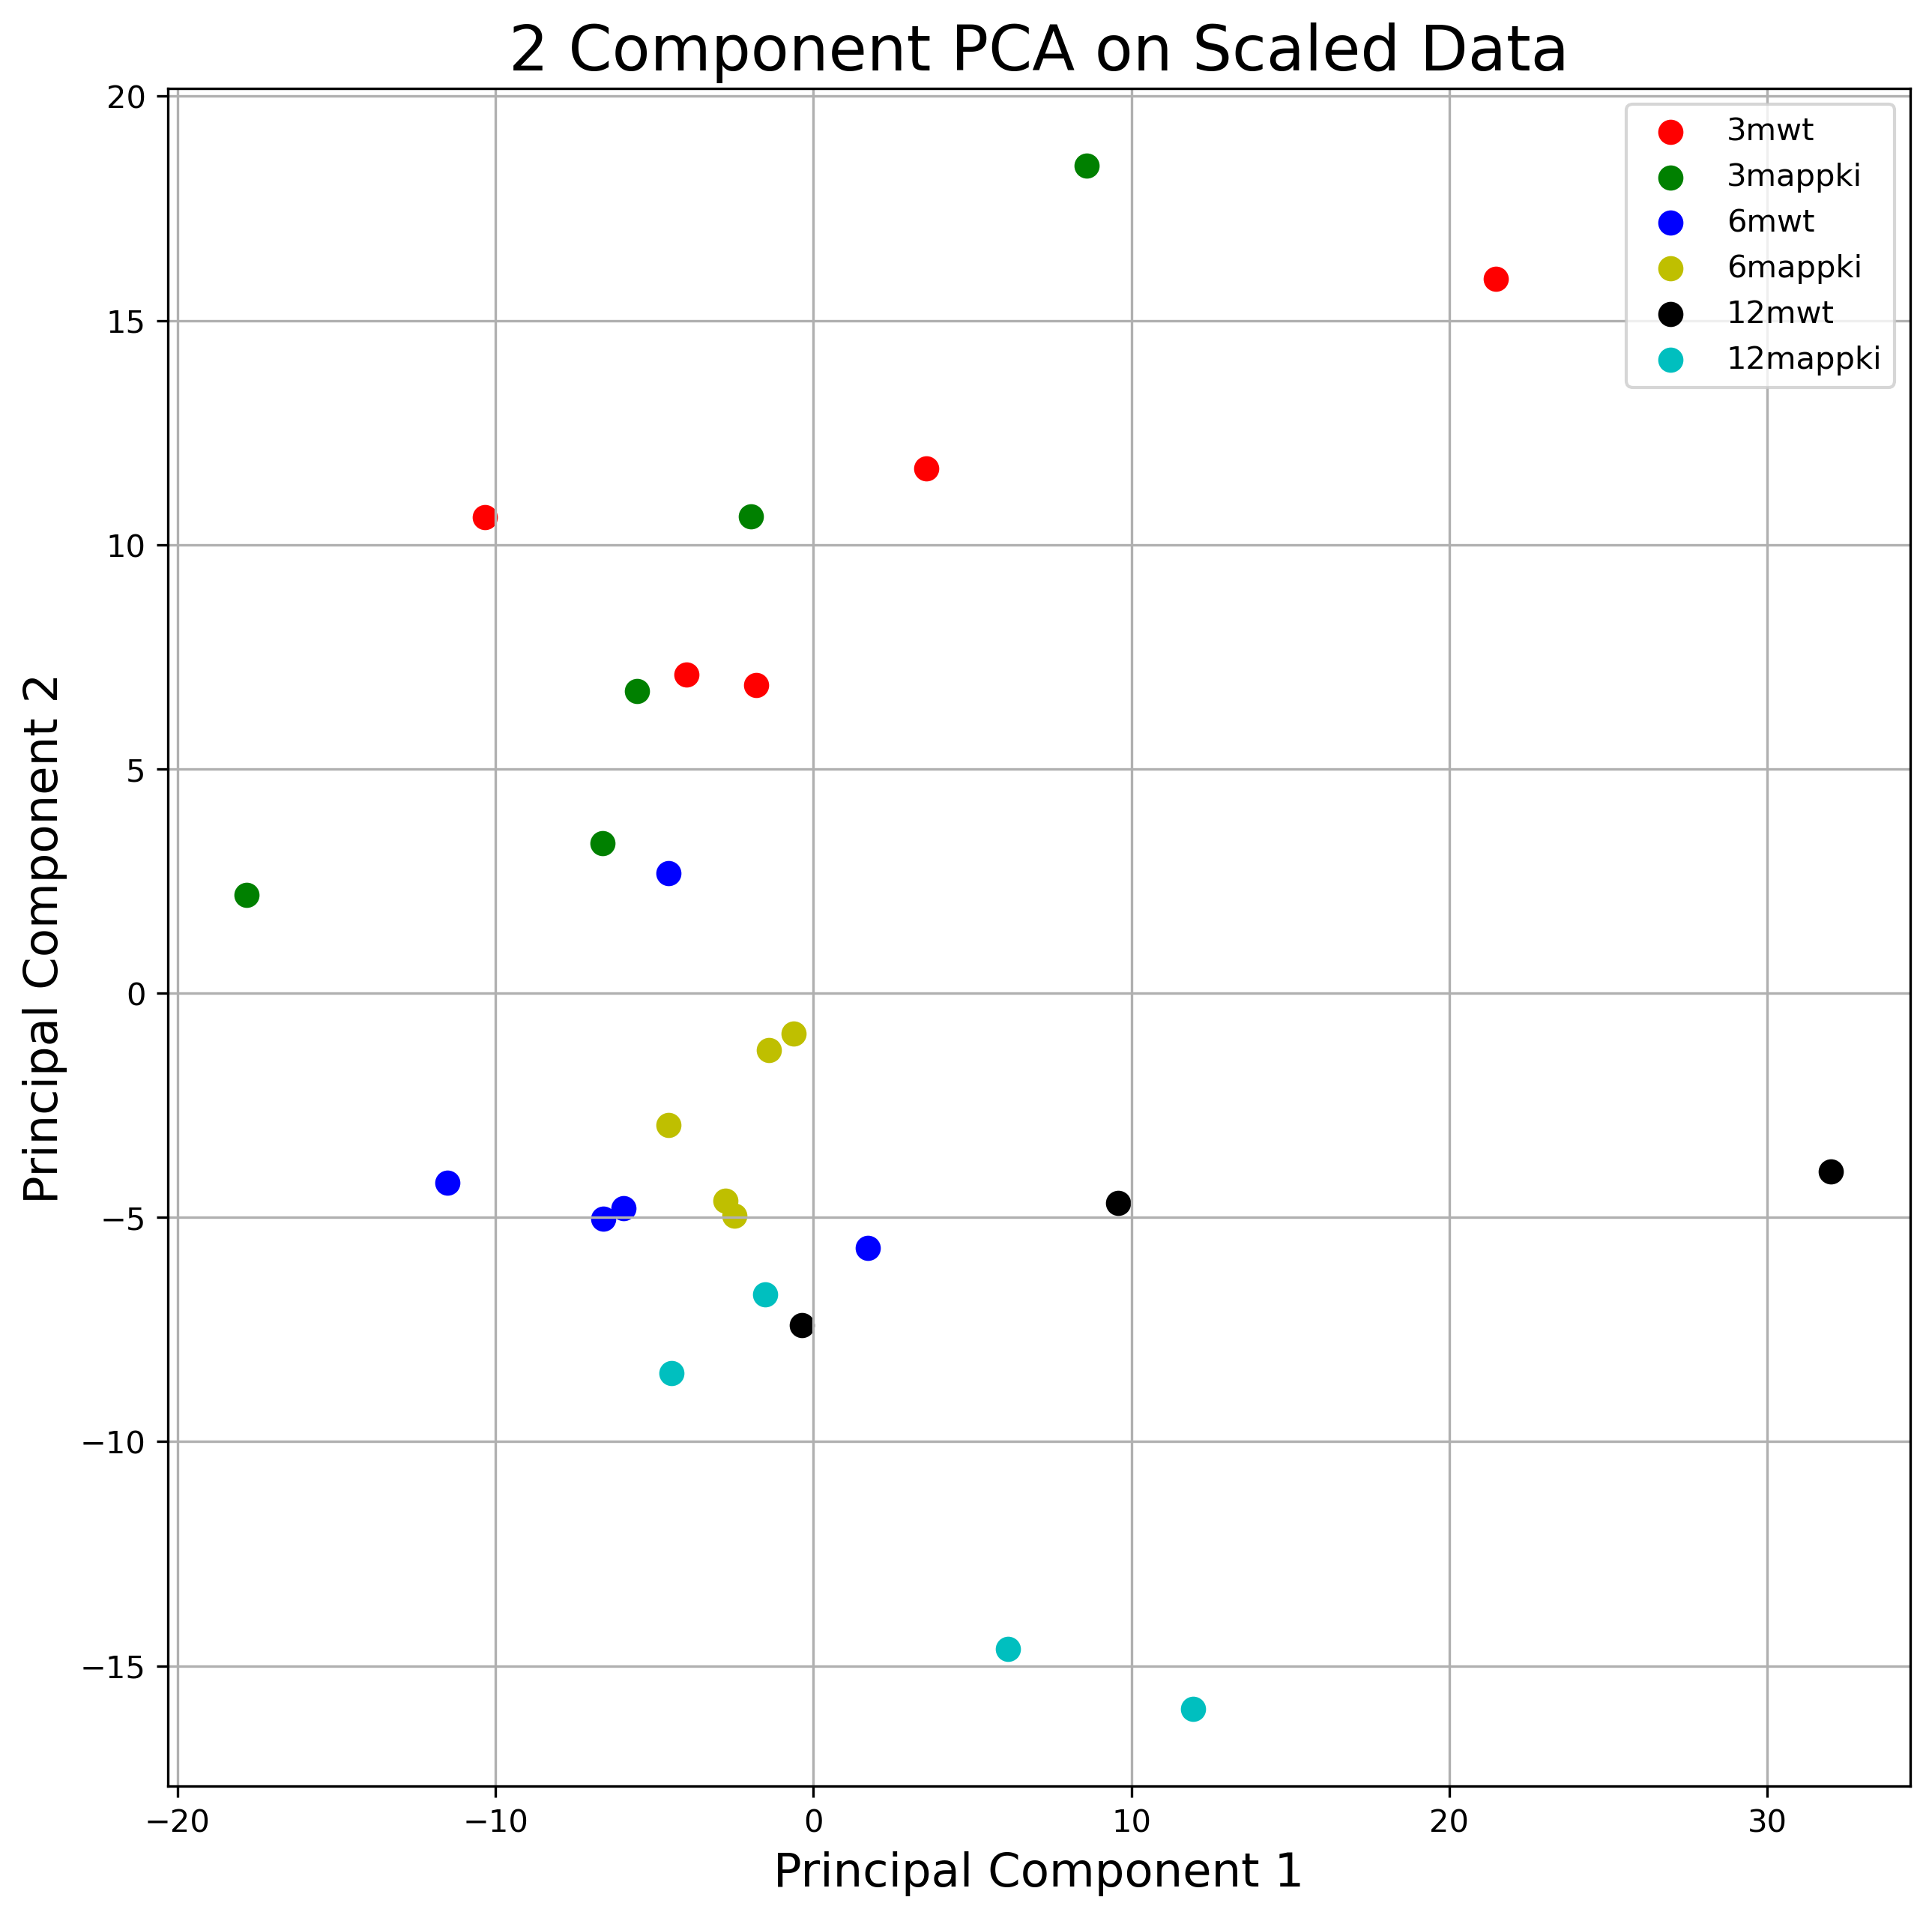

In [175]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA on Scaled Data', fontsize = 20)


targets = ['3mwt', '3mappki', '6mwt', '6mappki', '12mwt', '12mappki']
colors = ['r', 'g', 'b', 'y', 'k', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['index'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [176]:
#rename columns
df_distribution = df_imputed_total_merge
df_distribution.columns = ['3mwt.1', '3mwt.2', '3mwt.3', '3mwt.4', '3mwt.5', '3mappki.1', '3mappki.2', '3mappki.3', '3mappki.4', '3mappki.5', '6mwt.1', '6mwt.2', '6mwt.3', '6mwt.4', '6mwt.5', '6mappki.1', '6mappki.2', '6mappki.3', '6mappki.4', '6mappki.5', '12mwt.1', '12mwt.2', '12mwt.3',  '12mappki.1', '12mappki.2', '12mappki.3', '12mappki.4']
df_distribution

3mwt.1      3mwt.2      3mwt.3      3mwt.4      3mwt.5  \
Master Protein                                                               
A0A075B5K0      124.578952  149.455396  102.605754  165.674286   98.758266   
A0A075B5K2      124.843459  167.275585  231.601790  134.813408   82.257854   
A0A075B5K6      197.007588   89.670999  169.174872  148.077972  135.845034   
A0A075B5L1      103.715239   52.255501  109.631772  126.460023  120.367252   
A0A075B5L7      103.093031  120.866463  116.232200  167.238277  161.054466   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          283.616464  155.662106  199.804524  202.776510   58.515460   
Q9Z2L6          190.181268  141.424181  167.683747  147.438329  248.637140   
Q9Z2U0            6.917337  172.130514    6.868211  139.866469  145.515410   
Q9Z2U1          189.551177  108.888944  170.633984  182.236912  202.094764   
Q9Z331          156.314343  169.650364  154.349944  152.792781  206.878537   

                 3mappki.1   3mappki.2   3mappki.3   3mappki.4   3mappki.5  \
Master Protein                                                               
A0A075B5K0      112.903267  122.270686  100.466405  117.205388  124.442726   
A0A075B5K2      178.041912   91.110384   69.319974  108.579084  135.333896   
A0A075B5K6      109.799638   90.643023  112.410310  249.768354  109.195173   
A0A075B5L1       91.270391  141.061164  168.980525  127.445550  123.452601   
A0A075B5L7      187.762499  154.143959  130.304196   92.757273  156.880173   
...                    ...         ...         ...         ...         ...   
Q9Z2K1           37.291501  197.816836  154.255451  140.919226   42.667970   
Q9Z2L6          271.086037  173.694392  175.017280  179.767682  318.155723   
Q9Z2U0          139.080826  177.535300  180.361788   97.345615  165.341787   
Q9Z2U1          162.145436  174.001283  161.496914  207.640724  176.435919   
Q9Z331          139.153517  176.971732  223.481676  175.209991  154.232965   

                ...   6mappki.3   6mappki.4   6mappki.5     12mwt.1  \
Master Protein  ...                                                   
A0A075B5K0      ...  138.240201  127.934449  221.879408  255.299453   
A0A075B5K2      ...  231.303910  170.392253  217.500829  164.596444   
A0A075B5K6      ...  156.952938  196.214906  224.137667  194.076338   
A0A075B5L1      ...  319.192166   96.172195  145.560006  130.937027   
A0A075B5L7      ...  198.986925  187.362298  300.806980  194.747347   
...             ...         ...         ...         ...         ...   
Q9Z2K1          ...   43.979228  265.676715   81.688972   50.430442   
Q9Z2L6          ...  215.214448  149.546141  179.392235  136.640537   
Q9Z2U0          ...  192.965840  172.838089    6.933033  167.694086   
Q9Z2U1          ...  183.637853  173.978568  177.368416  163.303275   
Q9Z331          ...  150.697255  210.123956  193.245166  176.837155   

                   12mwt.2     12mwt.3  12mappki.1  12mappki.2  12mappki.3  \
Master Protein                                                               
A0A075B5K0      165.889178  174.591700  106.755853  165.060503  183.975238   
A0A075B5K2      128.407653  138.197279  144.908942  127.806684  175.445522   
A0A075B5K6      212.844239  186.851484  167.345348  232.885617  192.882902   
A0A075B5L1      184.181088   55.902964   85.443715   68.601525  220.775422   
A0A075B5L7      254.196834  268.380670  263.927520  163.402668  318.955238   
...                    ...         ...         ...         ...         ...   
Q9Z2K1          209.770156  152.972834  150.447283  111.263676   35.878917   
Q9Z2L6          134.070246  151.010837  175.746491  164.715267  155.537306   
Q9Z2U0            6.260730  170.116475    6.865450  162.181186  185.696159   
Q9Z2U1          329.591862  174.902283  208.815769  173.271209  200.873111   
Q9Z331          197.175741  171.157844  177.133733  145.322523   98.248433   

                12mappki.4  
Master Protein        

In [177]:
df_distribution = np.log2(df_distribution) #log2transforms the data
df_distribution 

3mwt.1    3mwt.2    3mwt.3    3mwt.4    3mwt.5  3mappki.1  \
Master Protein                                                                
A0A075B5K0      6.960917  7.223571  6.680968  7.372206  6.625830   6.818943   
A0A075B5K2      6.963976  7.386083  7.855503  7.074820  6.362082   7.476073   
A0A075B5K6      7.622107  6.486570  7.402371  7.210213  7.085818   6.778729   
A0A075B5L1      6.696484  5.707511  6.776522  6.982538  6.911299   6.512075   
A0A075B5L7      6.687803  6.917270  6.860866  7.385761  7.331405   7.552765   
...                  ...       ...       ...       ...       ...        ...   
Q9Z2K1          8.147797  7.282274  7.642445  7.663747  5.870746   5.220775   
Q9Z2L6          7.571231  7.143885  7.389599  7.203968  7.957898   8.082607   
Q9Z2U0          2.790217  7.427359  2.779934  7.127906  7.185028   7.119780   
Q9Z2U1          7.566444  6.766714  7.414761  7.509671  7.658888   7.341145   
Q9Z331          7.288306  7.406421  7.270061  7.255433  7.692640   7.120534   

                3mappki.2  3mappki.3  3mappki.4  3mappki.5  ...  6mappki.3  \
Master Protein                                              ...              
A0A075B5K0       6.933935   6.650569   6.872895   6.959338  ...   7.111033   
A0A075B5K2       6.509544   6.115199   6.762602   7.080379  ...   7.853646   
A0A075B5K6       6.502124   6.812631   7.964447   6.770765  ...   7.294188   
A0A075B5L1       7.140177   7.400713   6.993737   6.947813  ...   8.318281   
A0A075B5L7       7.268135   7.025740   6.535389   7.293519  ...   7.636530   
...                   ...        ...        ...        ...  ...        ...   
Q9Z2K1           7.628021   7.269178   7.138725   5.415082  ...   5.458750   
Q9Z2L6           7.440407   7.451354   7.489990   8.313589  ...   7.749631   
Q9Z2U0           7.471962   7.494750   6.605044   7.369308  ...   7.592202   
Q9Z2U1           7.442954   7.335363   7.697946   7.463000  ...   7.520720   
Q9Z331           7.467375   7.804013   7.452941   7.268967  ...   7.235509   

                6mappki.4  6mappki.5   12mwt.1   12mwt.2   12mwt.3  \
Master Protein                                                       
A0A075B5K0       6.999261   7.793632  7.996047  7.374076  7.447841   
A0A075B5K2       7.412716   7.764877  7.362789  7.004587  7.110585   
A0A075B5K6       7.616291   7.808241  7.600480  7.733654  7.545748   
A0A075B5L1       6.587548   7.185470  7.032729  7.524981  5.804853   
A0A075B5L7       7.549687   8.232694  7.605460  7.989802  8.068137   
...                   ...        ...       ...       ...       ...   
Q9Z2K1           8.053528   6.352069  5.656223  7.712666  7.257132   
Q9Z2L6           7.224447   7.486974  7.094242  7.066845  7.238508   
Q9Z2U0           7.433277   2.793487  7.389688  2.646331  7.410379   
Q9Z2U1           7.442766   7.470605  7.351410  8.364537  7.450405   
Q9Z331           7.715097   7.594289  7.466278  7.623338  7.419184   

                12mappki.1  12mappki.2  12mappki.3  12mappki.4  
Master Protein                                                  
A0A075B5K0        6.738171    7.366851    7.523368    7.483734  
A0A075B5K2        7.179003    6.997819    7.454879    7.526132  
A0A075B5K6        7.386685    7.863478    7.591581    7.799955  
A0A075B5L1        6.416902    6.100169    7.786436    7.552065  
A0A075B5L7        8.043998    7.352288    8.317210    8.104452  
...                    ...         ...         ...         ...  
Q9Z2K1            7.233114    6.797839    5.165064    4.814875  
Q9Z2L6            7.457352    7.363830    7.281117    7.305454  
Q9Z2U0            2.779354    7.341463    7.536800    7.354521  
Q9Z2U1            7.706087    7.436888    7.650141    7.416960  
Q9Z331            7.468695    7.183115    6.618362    6.589448  

[650 rows x 27 columns]

array([[<AxesSubplot:title={'center':'3mwt.1'}>,
        <AxesSubplot:title={'center':'3mwt.2'}>,
        <AxesSubplot:title={'center':'3mwt.3'}>,
        <AxesSubplot:title={'center':'3mwt.4'}>,
        <AxesSubplot:title={'center':'3mwt.5'}>],
       [<AxesSubplot:title={'center':'3mappki.1'}>,
        <AxesSubplot:title={'center':'3mappki.2'}>,
        <AxesSubplot:title={'center':'3mappki.3'}>,
        <AxesSubplot:title={'center':'3mappki.4'}>,
        <AxesSubplot:title={'center':'3mappki.5'}>],
       [<AxesSubplot:title={'center':'6mwt.1'}>,
        <AxesSubplot:title={'center':'6mwt.2'}>,
        <AxesSubplot:title={'center':'6mwt.3'}>,
        <AxesSubplot:title={'center':'6mwt.4'}>,
        <AxesSubplot:title={'center':'6mwt.5'}>],
       [<AxesSubplot:title={'center':'6mappki.1'}>,
        <AxesSubplot:title={'center':'6mappki.2'}>,
        <AxesSubplot:title={'center':'6mappki.3'}>,
        <AxesSubplot:title={'center':'6mappki.4'}>,
        <AxesSubplot:title={'center':'6

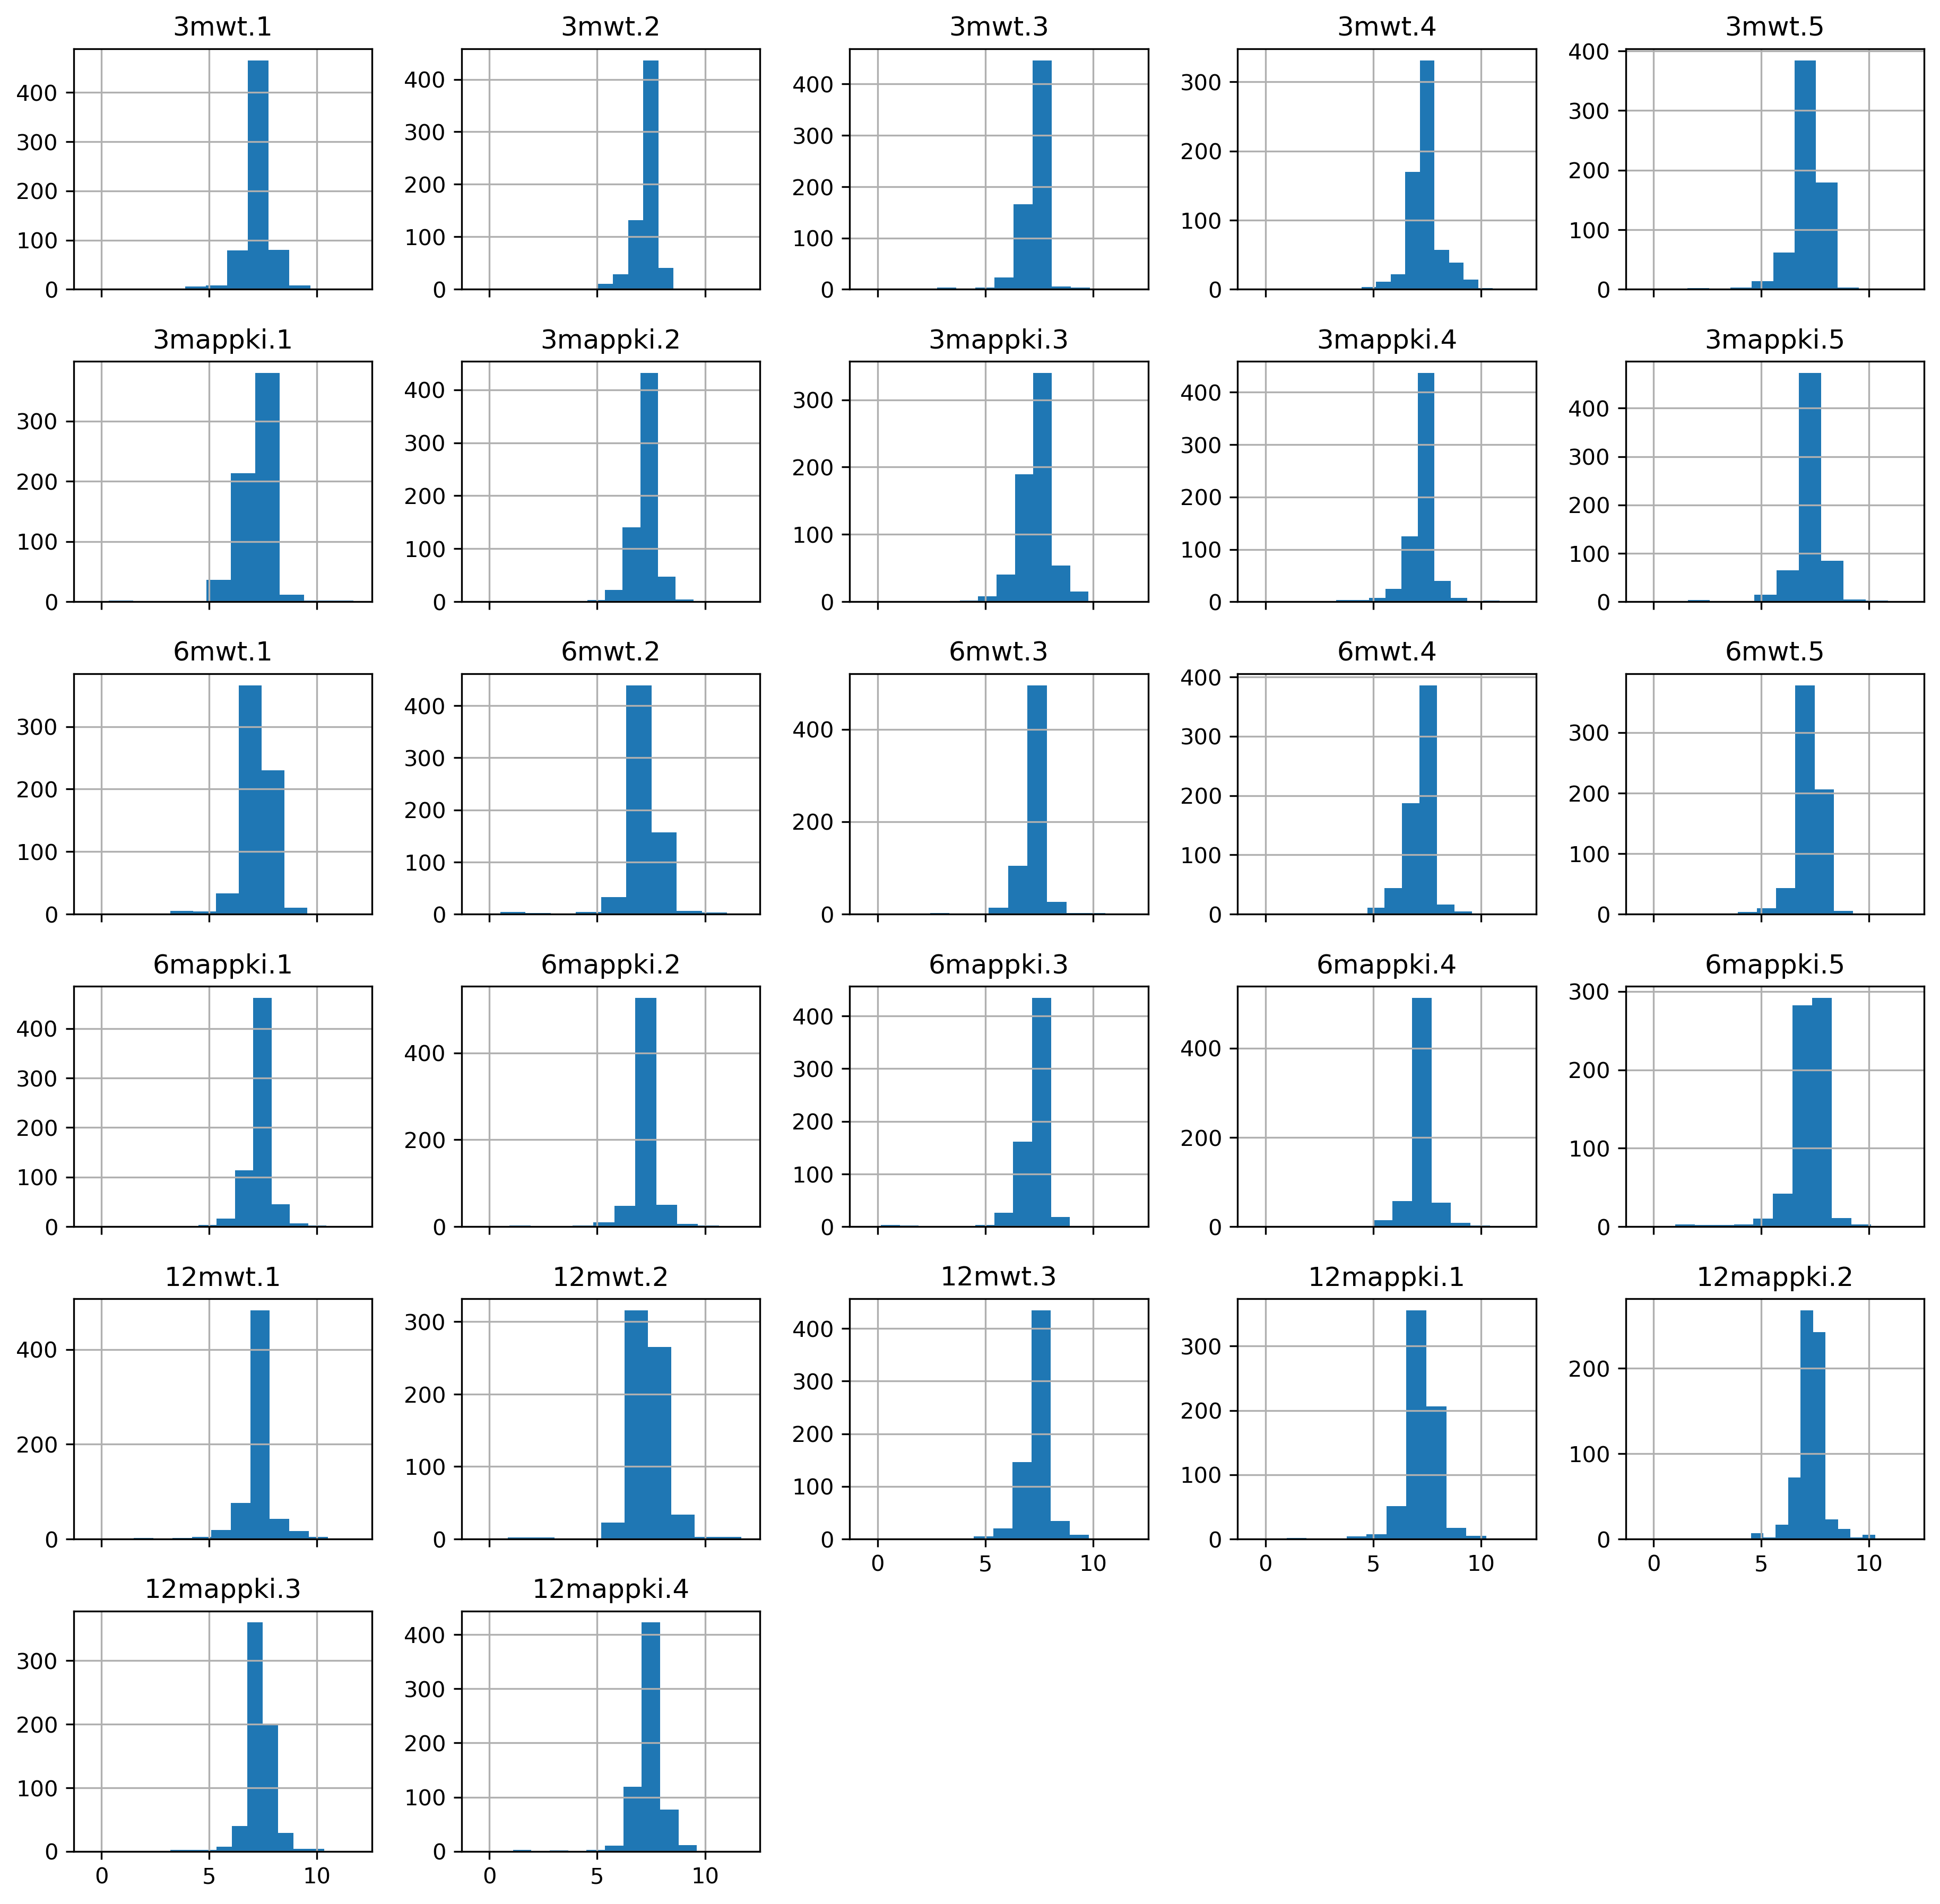

In [178]:
df_distribution.hist(figsize=(15,15), sharex = True)

## Binary comparisons

In [179]:
#Import 3m group (both WT and APPki) as dataframe df3m, with Master Protein set to index column
df3m = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Binary_Analyzed_3m2.xlsx', index_col=0, na_values=0) 

#View dataframe df3m
df3m 

protein    3m - wt1    3m - wt2    3m - wt3    3m - wt4  \
Master Protein                                                               
Q8C7G5              Q8C7G5         NaN         NaN         NaN  231.664708   
A0A1Y7VJN6      A0A1Y7VJN6  161.740990  148.535593  165.928878  139.420488   
P11438              P11438  182.281187  202.088726  184.153897         NaN   
A0A0R4J1C6      A0A0R4J1C6         NaN         NaN         NaN  242.079369   
A0A075B5Y4      A0A075B5Y4  246.178505  198.659600  225.066586  248.429999   
...                    ...         ...         ...         ...         ...   
F8VQL0              F8VQL0  153.471969         NaN  170.065095  139.185015   
P14847              P14847  157.546046  159.987815  148.460496  155.805246   
Q69ZK7              Q69ZK7         NaN         NaN         NaN  217.040446   
P07724              P07724  169.877420  158.707228  154.812436  180.261803   
Q9EQI5              Q9EQI5   70.538382   58.101375  113.238658  530.252007   

                  3m - wt5  3m - appki1  3m - appki2  3m - appki3  \
Master Protein                                                      
Q8C7G5          233.866789   151.128715          NaN          NaN   
A0A1Y7VJN6      155.381667    82.491290   142.423971   114.693575   
P11438                 NaN          NaN   156.395500   157.179436   
A0A0R4J1C6      224.512117   149.401529          NaN          NaN   
A0A075B5Y4      259.791299   173.628624   186.264186   224.452961   
...                    ...          ...          ...          ...   
F8VQL0          114.231471   132.753263          NaN          NaN   
P14847          195.850748   186.761086   168.623625   152.578629   
Q69ZK7           70.374593   114.665914          NaN          NaN   
P07724          209.061532   147.065187   178.118456   186.777059   
Q9EQI5           53.428171    61.835143    94.713588   610.257721   

                3m - appki4  3m - appki5    F TEST    T TEST      WT avg  \
Master Protein                                                             
Q8C7G5                  NaN   142.480544  0.317458  0.002684  232.765748   
A0A1Y7VJN6        91.514366   129.426672  0.121684  0.008667  154.201523   
P11438           135.219239          NaN  0.870333  0.014032  189.507936   
A0A0R4J1C6              NaN   126.723872  0.839181  0.021939  233.295743   
A0A075B5Y4       139.214584   207.052973  0.574657  0.026054  235.625198   
...                     ...          ...       ...       ...         ...   
F8VQL0           178.067126   121.288357  0.669471  0.992385  144.238388   
P14847           161.445163   147.727703  0.718735  0.992615  163.530070   
Q69ZK7                  NaN   174.329136  0.491919  0.992944  143.707520   
P07724           195.532866   165.794983  0.797282  0.993180  174.544084   
Q9EQI5            22.940574    39.840838  0.714063  0.995692  165.111718   

                   APP avg  Fold change    Log2FC  
Master Protein                                     
Q8C7G5          146.804629     0.630697 -0.664981  
A0A1Y7VJN6      112.109975     0.727035 -0.459902  
P11438          149.598058     0.789403 -0.341167  
A0A0R4J1C6      138.062701     0.591793 -0.756836  
A0A075B5Y4      186.122666     0.789910 -0.340240  
...                    ...          ...       ...  
F8VQL0          144.036249     0.998599 -0.002023  
P14847          163.427241     0.999371 -0.000907  
Q69ZK7          144.497525     1.005497  0.007909  
P07724          174.657710     1.000651  0.000939  
Q9EQI5          165.917573     1.004881  0.007024  

[716 rows x 17 columns]

## 3m WT vs APPki

In [180]:
#Visualize binary comparison of 3m group (WT vs APPki)
visuz.gene_exp.volcano(df=df3mg, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)


NameError: name 'df3mg' is not defined

In [ ]:
#Visualize binary comparison of 3m group (WT vs APPki) - normalized
visuz.gene_exp.volcano(df=df3mg, show = True, r = 1200, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, xlm=(-6,6.01,2), ylm=(0,3.7,1), gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1))

In [ ]:
#Import 6m group
dfc = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Binary_Analyzed_6m2.xlsx', index_col=0, na_values=0) 
dfc

In [ ]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
dfc = pd.merge(dfc, df2, left_index=True, right_index=True)

#Export dataframe to csv with index
dfc.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/6m_Proteinlist.csv')

In [ ]:
#replace nan with 0
dfcn = dfc.fillna(0)

dfcn

In [ ]:
#Visualize 6m group
visuz.gene_exp.volcano(df=dfcn, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1))


In [ ]:
#Visualize binary comparison of 6m group (WT vs APPki) - normalized
visuz.gene_exp.volcano(df=dfcn, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, xlm=(-6,6.01,2), ylm=(0,3.7,1), gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1))

In [ ]:
#Import 12m group as dfb
dfb = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Binary_Analyzed_12m3.xlsx', index_col=0, na_values=0) 
dfb

In [ ]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
dfb = pd.merge(dfb, df2, left_index=True, right_index=True)

#Export dataframe to csv with index
dfb.to_csv(r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/12m_Proteinlist.csv')

#replace nan with 0
dfbb = dfb.fillna(0)

dfbb

In [ ]:
#Visualize 12m group
visuz.gene_exp.volcano(df=dfbb, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1))


In [ ]:
#Visualize binary comparison of 12m group (WT vs APPki) - normalized
visuz.gene_exp.volcano(df=dfbb, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), r=1200, plotlegend=True, xlm=(-6,6.01,2), ylm=(0,3.7,1), gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1))

## Comparing 3m vs 6m - WT and appki 

In [ ]:
#import 3m vs 6m WT
dfwt3m6m = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/wt3m6m.xlsx', index_col=0, na_values=0)
dfwt3m6m

In [ ]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
dfwt3m6m = pd.merge(dfwt3m6m, df2, left_index=True, right_index=True)

#replace nan with 0
dfwt3m6mm = dfwt3m6m.fillna(0)

dfwt3m6mm

In [ ]:
#Visualize 3m vs 6m WT
visuz.gene_exp.volcano(df=dfwt3m6mm, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right',  xlm=(-5,5.01,1), ylm=(0,6.1,1),
    legendanchor=(1.46,1))

In [ ]:
#import 3m vs 6m appki
dfappki3m6m = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/appki3m6m.xlsx', index_col=0, na_values=0)
dfappki3m6m

In [ ]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
dfappki3m6m = pd.merge(dfappki3m6m, df2, left_index=True, right_index=True)

#replace nan with 0
dfappki3m6mm = dfappki3m6m.fillna(0)

dfappki3m6mm

In [ ]:
#Visualize 3m vs 6m appki
visuz.gene_exp.volcano(df=dfappki3m6mm, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, xlm=(-5,5.01,1), ylm=(0,6.1,1), legendpos='upper right', 
    legendanchor=(1.46,1))

## Comparing 6m to 12m - wt and appki

In [ ]:
#import 6mm vs 12m wt
dfwt6m12m = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/wt6mvs12m.xlsx', index_col=0, na_values=0)
dfwt6m12m

In [ ]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
dfwt6m12m = pd.merge(dfwt6m12m, df2, left_index=True, right_index=True)

#replace nan with 0
dfwt6m12mm = dfwt6m12m.fillna(0)

dfwt6m12mm

In [ ]:
#Visualize 6m vs 12m wt
visuz.gene_exp.volcano(df=dfwt6m12mm, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, xlm=(-5,5.01,1), ylm=(0,4.1,1), legendpos='upper right', 
    legendanchor=(1.46,1))

In [ ]:
#import 6mm vs 12m appki
dfappki6m12m = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/appki6mvs12m.xlsx', index_col=0, na_values=0)
dfappki6m12m

In [ ]:
#Add gene names to dataframe by merging with genenames dataframe (df2)
dfappki6m12m = pd.merge(dfappki6m12m, df2, left_index=True, right_index=True)

#replace nan with 0
dfappki6m12mm = dfappki6m12m.fillna(0)

dfappki6m12mm

In [ ]:
#Visualize 6m vs 12m appki
visuz.gene_exp.volcano(df=dfappki6m12mm, show = True, lfc='Log2FC', pv='T TEST', geneid="Protein", lfc_thr=(.2, .2), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, xlm=(-5,5.01,1), ylm=(0,4.1,1), sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1))

## Combined Comparisons

In [ ]:
#import combined data
df10 = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/Analyzed_combined.xlsx', index_col=0, na_values=0)
df10

In [ ]:
dfd = df10.dropna()
dfd

In [ ]:
dfl = np.log2(dfd) #log2transforms the data
dfl 

In [ ]:
sns.clustermap(dfl, robust = True, method = 'ward', cmap = "YlGnBu", col_cluster=False, figsize = (10,20), cbar_pos=(1.05, .2, .04, .5))


In [ ]:
dfl.transpose()

In [ ]:
#import combined and transposed
df12 = pd.read_excel (r'/Users/jonathanokerblom/Dropbox/My Mac (Jonathan’s MacBook Air)/Documents/Head Proteomics/dfnnt.xlsx', index_col=0)
df12

In [ ]:
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('Paired', len(df12.month.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df12.month.unique(), network_pal))

#get the series of all of the categories
networks = df12.month

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#create a second color palette with the same number of colors as unique values in the Source column
network_pal2 = sns.color_palette('husl', len(df12.genotype.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut2 = dict(zip(df12.genotype.unique(), network_pal2))

#get the series of all of the categories
networks2 = df12.genotype

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors2 = pd.Series(networks2).map(network_lut2)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
g = sns.clustermap(df12, robust = True, cmap = "YlGnBu", linewidths=0.1, cbar_pos=(1.05, .2, .04, .5), row_colors=[network_colors, network_colors2])
ax = g.ax_heatmap
ax.set_xlabel("Uniprot ID", fontsize = 12)
ax.set_ylabel("Mouse Group (Genotype and Age)", fontsize = 12)
ax.set_title('Hierarchical Clustering of WT and APPki Mouse Plasma Proteomics', y=1.3, fontsize = 18)